In [ ]:
import marimo as mo

mo.md("""
# Smart Traffic Signal Control in Kathmandu
## Comparing Reinforcement Learning Approaches

**Student:** Sabin Neupane | **ID:** 250136 | **Module:** Artificial Neural Network (STW7088CEM)

This notebook implements an adaptive traffic signal control system using:
- **Baselines:** Fixed-time controller, Max Pressure controller, and supervised MLP
- **RL Agents:** PPO, DQN, and A2C with different optimizers

    ---
    """
)

<span class="markdown prose dark:prose-invert contents"><h1 id="smart-traffic-signal-control-in-kathmandu">Smart Traffic Signal Control in Kathmandu</h1>
<h2 id="comparing-reinforcement-learning-approaches">Comparing Reinforcement Learning Approaches</h2>
<span class="paragraph"><strong>Student:</strong> Sabin Neupane | <strong>ID:</strong> 250136 | <strong>Module:</strong> Artificial Neural Network (STW7088CEM)</span>
<span class="paragraph">This notebook implements an adaptive traffic signal control system using:</span>
<ul>
<li><strong>Baselines:</strong> Fixed-time controller, Max Pressure controller, and supervised MLP</li>
<li>
<span class="paragraph"><strong>RL Agents:</strong> PPO, DQN, and A2C with different optimizers</span>
<hr />
</li>
</ul></span>

## 1. Setup and Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
from dataclasses import dataclass
from typing import List, Tuple, Optional
import warnings
import os
import sys
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
import traci
from sumolib import checkBinary
import time
import traceback
import subprocess

# SUMO imports
if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare environment variable 'SUMO_HOME'")

warnings.filterwarnings("ignore")

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
random.seed(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"SUMO_HOME: {os.environ.get('SUMO_HOME', 'Not set')}")

Using device: cpu
SUMO_HOME: /Library/Frameworks/EclipseSUMO.framework/Versions/Current/EclipseSUMO


## 2. Configuration and Hyperparameters

In [ ]:
@dataclass
class Config:
    """Configuration for the Smart Traffic Signal Control System"""

    # Environment settings
    num_lanes: int = 4  # Number of approach lanes (N, S, E, W)
    max_vehicles_per_lane: int = 20  # Max queue capacity per lane
    max_steps_per_episode: int = 300  # Steps per episode
    green_duration: int = 30  # Default green phase duration (seconds)
    yellow_duration: int = 5  # Yellow phase duration (seconds)
    min_green: int = 10  # Minimum green phase duration
    max_green: int = 60  # Maximum green phase duration

    # State and action space
    state_dim: int = 12  # Queue lengths (4) + waiting times (4) + current phase (4)
    action_dim: int = 4  # 4 possible signal phases

    # PPO Hyperparameters
    gamma: float = 0.98
    gae_lambda: float = 0.97
    clip_epsilon: float = 0.25
    entropy_coef: float = 0.015
    value_coef: float = 0.8
    max_grad_norm: float = 1.0
    learning_rate: float = 3e-4
    ppo_learning_rate: float = 3e-4
    batch_size: int = 512
    n_epochs: int = 15
    update_interval: int = 1024
    ppo_update_interval: int = 512

    # Training settings
    num_episodes: int = 100
    eval_interval: int = 10

    # MLP Baseline settings
    mlp_hidden_dim: int = 128
    mlp_epochs: int = 50
    mlp_lr: float = 1e-3

    # DQN Hyperparameters
    buffer_size: int = 10000
    batch_size_dqn: int = 64
    dqn_learning_rate: float = 5e-5
    epsilon_start: float = 1.0
    epsilon_end: float = 0.01
    epsilon_decay: float = 0.99
    target_update_freq: int = 100

    # A2C Hyperparameters
    a2c_learning_rate: float = 1e-4

config = Config()
print(f"  - State dimension: {config.state_dim}")
print(f"  - Action dimension: {config.action_dim}")
print(f"  - PPO clip epsilon: {config.clip_epsilon}")
print(f"  - Learning rate: {config.learning_rate}")
print(f"  - Update interval: {config.update_interval}")
print(f"  - Training episodes: {config.num_episodes}")

  - State dimension: 12
  - Action dimension: 4
  - PPO clip epsilon: 0.25
  - Learning rate: 0.0003
  - Update interval: 1024
  - Training episodes: 100


## 3. SUMO Traffic Environment

This implementation uses **SUMO (Simulation of Urban MObility)** for realistic traffic simulation
of Kathmandu traffic patterns. The scenario was generated using osmWebWizard.py and includes:
- Real road network from OpenStreetMap
- Multiple vehicle types (passenger, motorcycle, bus, truck, bicycle)
- Traffic light control via TraCI interface
- Realistic traffic flow patterns

In [ ]:
class SUMOTrafficEnv:
    """SUMO-based Traffic Environment for Kathmandu traffic simulation."""

    def __init__(self, config, gui=False, sumo_cfg_path=None, port=None, label=None):
        self.config = config
        self.gui = gui
        self.max_steps = config.max_steps_per_episode
        self.port = port  # TraCI port for this instance
        self.label = label or f"sumo_{port or 'default'}"  # Unique label for this TraCI connection

        # SUMO configuration
        if sumo_cfg_path:
            self.sumo_cfg = sumo_cfg_path
        else:
            # Try to find the config file relative to current working directory
            self.sumo_cfg = os.path.join(
                os.getcwd(),
                "sumo", "kathmandu", "osm.sumocfg.xml"
            )

        if not os.path.exists(self.sumo_cfg):
            raise FileNotFoundError(
                f"SUMO config not found at: {self.sumo_cfg}\n"
                f"Current directory: {os.getcwd()}"
            )

        # Delta time for each simulation step (seconds)
        self.delta_time = 5

        # Track simulation state
        self.sumo_running = False
        self.episode_step = 0
        self.total_throughput = 0
        self.total_waiting_time = 0.0

        # Traffic light info (will be populated on reset)
        self.tl_ids = []
        self.controlled_tl = None
        self.current_phase = 0
        self.num_phases = config.action_dim

        # Lane info for state computation
        self.controlled_lanes = []
        self.num_lanes = config.num_lanes
        self.max_vehicles = config.max_vehicles_per_lane

    def _start_sumo(self):
        """Start SUMO simulation with proper cleanup"""

        try:
            traci.getConnection(self.label).close()
        except (traci.exceptions.TraCIException, KeyError, AttributeError):
            pass

        if self.sumo_running and hasattr(self, 'connection'):
            try:
                self.connection.close()
            except Exception:
                pass
        self.sumo_running = False

        sumo_binary = checkBinary("sumo-gui" if self.gui else "sumo")

        print(f"Starting SUMO with config: {self.sumo_cfg}")
        print(f"SUMO binary: {sumo_binary}")

        sumo_cmd = [
            "-c", self.sumo_cfg,
            "--no-warnings",
            "--no-step-log",
            "--quit-on-end",
            "--waiting-time-memory", "1000",
            "--time-to-teleport", "-1",
            "--random",
            "--output-prefix", f"{self.label}_",
            "--message-log", os.devnull,
        ]

        # Full command for start (includes binary)
        full_cmd = [sumo_binary] + sumo_cmd

        max_retries = 3
        for attempt in range(max_retries):
            try:
                try:
                    traci.getConnection(self.label).close()
                except (traci.exceptions.TraCIException, KeyError):
                    pass

                # Context manager to suppress stderr (for PROJ warnings)
                class SuppressStderr:
                    def __enter__(self):
                        self.null_fd = os.open(os.devnull, os.O_RDWR)
                        self.save_fd = os.dup(2)
                        os.dup2(self.null_fd, 2)
                        return self

                    def __exit__(self, *_):
                        os.dup2(self.save_fd, 2)
                        os.close(self.save_fd)
                        os.close(self.null_fd)

                # Suppress SUMO output including PROJ library warnings
                with open(os.devnull, 'w') as devnull:
                    with SuppressStderr():
                        if self.port:
                            traci.start(full_cmd, port=self.port, label=self.label, stdout=devnull)
                        else:
                            traci.start(full_cmd, label=self.label, stdout=devnull)

                # Give it a moment to initialize
                time.sleep(2 + attempt)

                self.connection = traci.getConnection(self.label)
                self.sumo_running = True
                print(f"SUMO started successfully on {self.label}", flush=True)
                break # Success!
            except Exception as e:
                print(f"Attempt {attempt+1}/{max_retries} failed to start SUMO: {e}", flush=True)
                try:
                     traci.getConnection(self.label).close()
                except Exception:
                     pass

                if attempt < max_retries - 1:
                    wait_time = 2 ** attempt
                    print(f"Retrying in {wait_time} seconds...", flush=True)
                    time.sleep(wait_time)
                else:
                    raise RuntimeError(
                        f"Failed to start SUMO after {max_retries} attempts. Error: {e}\n"
                        f"Command: {' '.join(full_cmd)}\n"
                    )

        self._sumo_cmd_args = sumo_cmd

        try:
            self.tl_ids = list(self.connection.trafficlight.getIDList())
            if self.tl_ids:
                self.controlled_tl = self._select_main_intersection()
                self._setup_controlled_lanes()
                self._setup_phases()
            else:
                print("Warning: No traffic lights found in simulation")
        except Exception as e:
             print(f"Error initializing traffic lights: {e}")
             # Try to close if we failed initialization
             try:
                 self.connection.close()
             except Exception: 
                 pass
             raise

    def _select_main_intersection(self):
        """Select the main intersection to control (one with most controlled lanes)"""
        max_lanes = 0
        selected_tl = self.tl_ids[0]

        for tl_id in self.tl_ids:
            lanes = self.connection.trafficlight.getControlledLanes(tl_id)
            if len(lanes) > max_lanes:
                max_lanes = len(lanes)
                selected_tl = tl_id

        return selected_tl

    def _setup_controlled_lanes(self):
        """Setup the lanes controlled by our traffic light"""
        if self.controlled_tl:
            all_lanes = list(self.connection.trafficlight.getControlledLanes(self.controlled_tl))
            # Remove duplicates while preserving order
            seen = set()
            self.controlled_lanes = []
            for lane in all_lanes:
                if lane not in seen:
                    seen.add(lane)
                    self.controlled_lanes.append(lane)

            # Limit to num_lanes for state dimension consistency
            if len(self.controlled_lanes) > self.num_lanes:
                self.controlled_lanes = self.controlled_lanes[:self.num_lanes]

    def _setup_phases(self):
        """Setup available phases for the traffic light"""
        if self.controlled_tl:
            logic = self.connection.trafficlight.getAllProgramLogics(self.controlled_tl)
            if logic:
                phases = logic[0].phases
                self.num_phases = min(len(phases), self.config.action_dim)

    def reset(self):
        """Reset the environment"""
        if self.sumo_running and hasattr(self, 'connection'):
            try:
                self.connection.load(self._sumo_cmd_args)
                time.sleep(0.1)
            except Exception as e:
                print(f"Reload failed ({e}), restarting SUMO...", flush=True)
                self._start_sumo()
        else:
            self._start_sumo()

        self.episode_step = 0
        self.total_throughput = 0
        self.total_waiting_time = 0.0
        self.current_phase = 0

        # Run a few steps to populate the network
        for _ in range(10):
            self.connection.simulationStep()

        return self._get_state()

    def _get_state(self):
        """Construct state vector from SUMO simulation"""
        queue_lengths = np.zeros(self.num_lanes)
        waiting_times = np.zeros(self.num_lanes)

        for i, lane in enumerate(self.controlled_lanes[:self.num_lanes]):
            try:
                # Number of halting vehicles (speed < 0.1 m/s)
                queue_lengths[i] = self.connection.lane.getLastStepHaltingNumber(lane)
                # Mean waiting time on the lane
                waiting_times[i] = self.connection.lane.getWaitingTime(lane)
            except traci.exceptions.TraCIException:
                pass

        # Pad if we have fewer lanes than expected
        while len(queue_lengths) < self.num_lanes:
            queue_lengths = np.append(queue_lengths, 0)
            waiting_times = np.append(waiting_times, 0)

        # Normalize queue lengths
        norm_queues = np.clip(queue_lengths / self.max_vehicles, 0, 1)

        # Normalize waiting times (assume max 120 seconds)
        norm_waiting = np.clip(waiting_times / 120.0, 0, 1)

        # One-hot encode current phase
        phase_one_hot = np.zeros(self.num_lanes)
        if self.current_phase < self.num_lanes:
            phase_one_hot[self.current_phase] = 1.0

        state = np.concatenate([norm_queues, norm_waiting, phase_one_hot])
        return state.astype(np.float32)

    def _get_queue_lengths(self):
        """Get current queue lengths for all controlled lanes"""
        queue_lengths = np.zeros(self.num_lanes)
        for i, lane in enumerate(self.controlled_lanes[:self.num_lanes]):
            try:
                queue_lengths[i] = self.connection.lane.getLastStepHaltingNumber(lane)
            except traci.exceptions.TraCIException:
                pass
        return queue_lengths

    def _get_waiting_times(self):
        """Get waiting times for all controlled lanes"""
        waiting_times = np.zeros(self.num_lanes)
        for i, lane in enumerate(self.controlled_lanes[:self.num_lanes]):
            try:
                waiting_times[i] = self.connection.lane.getWaitingTime(lane)
            except traci.exceptions.TraCIException:
                pass
        return waiting_times

    def _set_phase(self, action):
        """Set traffic light phase"""
        if self.controlled_tl:
            try:
                action = int(action) % self.num_phases
                self.connection.trafficlight.setPhase(self.controlled_tl, action)
                self.current_phase = action
            except traci.exceptions.TraCIException as e:
                print(f"Error setting phase: {e}")

    def _compute_reward(self, old_queues, new_queues, old_waiting, new_waiting):
        """Compute reward based on traffic metrics"""
        # Throughput reward
        try:
            arrived = self.connection.simulation.getArrivedNumber()
            self.total_throughput += arrived
        except Exception:
            arrived = 0

        throughput_reward = arrived * 2.0

        # Queue reduction
        queue_change = np.sum(old_queues) - np.sum(new_queues)
        queue_reward = np.clip(queue_change, -5, 5) * 0.3

        # Queue pressure penalty
        total_queue = np.sum(new_queues)
        queue_penalty = -np.clip(total_queue / (self.num_lanes * 5), 0, 1) * 0.5

        # Waiting time penalty
        avg_wait = np.mean(new_waiting)
        wait_penalty = -np.clip(avg_wait / 60.0, 0, 2) * 0.3

        # Combined reward
        reward = throughput_reward + queue_reward + queue_penalty + wait_penalty

        return reward

    def step(self, action):
        """Execute one step in the environment"""
        self.episode_step += 1

        old_queues = self._get_queue_lengths()
        old_waiting = self._get_waiting_times()

        phase_change_penalty = 0
        if action != self.current_phase:
            phase_change_penalty = 0.1

        self._set_phase(action)

        for _ in range(self.delta_time):
            self.connection.simulationStep()

        new_queues = self._get_queue_lengths()
        new_waiting = self._get_waiting_times()

        reward = self._compute_reward(old_queues, new_queues, old_waiting, new_waiting)
        reward -= phase_change_penalty

        self.total_waiting_time += np.sum(new_waiting)

        done = self.episode_step >= self.max_steps

        try:
            if self.connection.simulation.getMinExpectedNumber() <= 0:
                done = True
        except Exception:
            pass

        next_state = self._get_state()

        info = {
            "queue_lengths": new_queues.copy(),
            "waiting_times": new_waiting.copy(),
            "throughput": self.total_throughput,
            "arrivals": 0,  # Not tracked in SUMO mode
            "departures": 0,  # Not tracked in SUMO mode
        }

        return next_state, reward, done, info

    def get_metrics(self):
        """Get performance metrics"""
        queues = self._get_queue_lengths()
        waiting = self._get_waiting_times()
        return {
            "avg_queue_length": np.mean(queues),
            "total_queue_length": np.sum(queues),
            "avg_waiting_time": np.mean(waiting),
            "total_waiting_time": self.total_waiting_time,
            "throughput": self.total_throughput,
        }

    def close(self):
        """Close the SUMO simulation with proper cleanup"""
        if self.sumo_running:
            try:
                if hasattr(self, 'connection'):
                    try:
                        self.connection.close()
                    except Exception:
                        pass
            except Exception as e:
                print(f"Warning: Error closing SUMO connection: {e}")
            finally:
                self.sumo_running = False

    def __enter__(self):
        """Context manager entry"""
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """Context manager exit"""
        try:
            self.close()
        except Exception:
            pass
        return False

    def __del__(self):
        try:
            self.close()
        except Exception:
            pass

TrafficIntersection = SUMOTrafficEnv

print("SUMO Traffic Environment class defined")
print(f"State dimension: {config.state_dim}, Action dimension: {config.action_dim}")

SUMO Traffic Environment class defined
State dimension: 12, Action dimension: 4


## 4. Baseline Controllers

### 4.1 Fixed-Time Controller
Traditional signal controller with fixed green phase durations.

### 4.2 MLP Baseline (Supervised Learning)
Multilayer Perceptron trained to predict optimal actions from historical data.

In [ ]:
"""Fixed-Time Controller - Traditional Baseline"""
class FixedTimeController:
    """Traditional fixed-time traffic signal controller."""

    def __init__(self, phase_duration=30, num_phases=4):
        self.phase_duration = phase_duration
        self.num_phases = num_phases
        self.current_phase = 0
        self.timer = 0

    def reset(self):
        self.current_phase = 0
        self.timer = 0

    def get_action(self, state=None):
        """Get action based on fixed timing (ignores state)"""
        self.timer += 1
        if self.timer >= self.phase_duration:
            self.timer = 0
            self.current_phase = (self.current_phase + 1) % self.num_phases
        return self.current_phase

print("FixedTimeController class defined")

FixedTimeController class defined


In [ ]:
"""Max-Pressure Controller - Adaptive Baseline"""
class MaxPressureController:
    """Max-Pressure adaptive controller."""

    def __init__(self):
        pass

    def get_action(self, state):
        """Select action based on maximum queue pressure"""
        queue_lengths = state[:4] * 20  # Denormalize

        pressures = np.array(
            [
                queue_lengths[0] + queue_lengths[1],  # N-S through
                queue_lengths[2] + queue_lengths[3],  # E-W through
                queue_lengths[0],  # N-S left
                queue_lengths[2],  # E-W left
            ]
        )

        return np.argmax(pressures)

print("MaxPressureController class defined")

MaxPressureController class defined


In [ ]:
"""MLPActionPredictor - Action Prediction Network"""
class MLPActionPredictor(nn.Module):
    """MLP for action prediction."""

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(MLPActionPredictor, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, action_dim),
        )

    def forward(self, x):
        logits = self.network(x)
        return logits

    def get_action(self, state):
        """Get action from state"""
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = self.forward(state)
            action = torch.argmax(logits, dim=-1)
        return action.item()

print("MLPActionPredictor class defined")

MLPActionPredictor class defined


In [ ]:
"""Initialize MLP Action Predictor"""
mlp_predictor = MLPActionPredictor(
    state_dim=config.state_dim,
    hidden_dim=config.mlp_hidden_dim,
    action_dim=config.action_dim,
).to(device)

print("MLP Action Predictor architecture:")
print(mlp_predictor)
print(f"\nTotal parameters: {sum(p.numel() for p in mlp_predictor.parameters()):,}")

MLP Action Predictor architecture:
MLPActionPredictor(
  (network): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)

Total parameters: 10,180


## 5. PPO Implementation

### Actor-Critic Architecture
- **Actor Network**: Outputs action probabilities (policy π(a|s))
- **Critic Network**: Estimates state value V(s)

### PPO Algorithm Features
- Clipped surrogate objective for stable updates
- Generalized Advantage Estimation (GAE)
- Entropy bonus for exploration

In [ ]:
"""Combined Actor-Critic Network for PPO"""
class ActorCritic(nn.Module):
    """Actor-Critic network with separate actor and critic paths."""

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(ActorCritic, self).__init__()

        # Decoupled Actor Network with Tanh activation (bounded, smoother gradients)
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim)
        )

        # Decoupled Critic Network with Tanh activation
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for module in [self.actor, self.critic]:
            for i, m in enumerate(module):
                if isinstance(m, nn.Linear):
                    if i == len(list(module)) - 1:
                        nn.init.orthogonal_(m.weight, gain=0.01)
                    else:
                        nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, state):
        action_logits = self.actor(state)
        value = self.critic(state)
        return action_logits, value

    def get_action(self, state, deterministic=False):
        """Sample action from policy"""
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state).unsqueeze(0).to(device)

        action_logits, value = self.forward(state)
        probs = torch.softmax(action_logits, dim=-1)
        dist = torch.distributions.Categorical(probs)

        if deterministic:
            action = torch.argmax(probs, dim=-1)
        else:
            action = dist.sample()

        log_prob = dist.log_prob(action)
        return action.item(), log_prob.item(), value.item()

    def evaluate_actions(self, states, actions):
        """Evaluate actions for PPO update"""
        action_logits, values = self.forward(states)
        probs = torch.softmax(action_logits, dim=-1)
        dist = torch.distributions.Categorical(probs)

        log_probs = dist.log_prob(actions)
        entropy = dist.entropy()
        return log_probs, values.squeeze(-1), entropy

print("ActorCritic class defined")

ActorCritic class defined


In [ ]:
"""Initialize Actor-Critic Network"""
actor_critic = ActorCritic(
    state_dim=config.state_dim, hidden_dim=256, action_dim=config.action_dim
).to(device)

print("Actor-Critic Network Architecture:")
print(actor_critic)
print(f"\nTotal parameters: {sum(p.numel() for p in actor_critic.parameters()):,}")

Actor-Critic Network Architecture:
ActorCritic(
  (actor): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=4, bias=True)
  )
  (critic): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

Total parameters: 139,525


In [ ]:
"""PPO Experience Memory Buffer"""
class PPOMemory:
    """Experience buffer for PPO"""

    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []

    def store(self, state, action, reward, value, log_prob, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.dones.append(done)

    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.values.clear()
        self.log_probs.clear()
        self.dones.clear()

    def get_batches(self, batch_size):
        n_samples = len(self.states)
        indices = np.arange(n_samples)
        np.random.shuffle(indices)

        for start in range(0, n_samples, batch_size):
            end = start + batch_size
            batch_indices = indices[start:end]
            yield batch_indices

print("PPOMemory class defined")

PPOMemory class defined


In [ ]:
"""PPO Agent Implementation"""
class PPOAgent:
    """Proximal Policy Optimization Agent"""

    def __init__(self, actor_critic, config, optimizer_class=None, **optimizer_kwargs):
        self.actor_critic = actor_critic
        self.config = config

        if optimizer_class is None:
            optimizer_class = optim.Adam

        lr = getattr(config, 'ppo_learning_rate', config.learning_rate)

        if optimizer_class == optim.Adam:
            self.optimizer = optimizer_class(
                actor_critic.parameters(), lr=lr, **optimizer_kwargs
            )
        elif optimizer_class == optim.SGD:
            if 'momentum' not in optimizer_kwargs:
                optimizer_kwargs['momentum'] = 0.9
            self.optimizer = optimizer_class(
                actor_critic.parameters(), lr=lr, **optimizer_kwargs
            )
        else:
            self.optimizer = optimizer_class(
                actor_critic.parameters(), lr=lr, **optimizer_kwargs
            )

        self.memory = PPOMemory()
        self.policy_losses = []
        self.value_losses = []
        self.entropy_losses = []

    def select_action(self, state, deterministic=False):
        """Select action using current policy"""
        return self.actor_critic.get_action(state, deterministic)

    def store_transition(self, state, action, reward, value, log_prob, done):
        """Store transition in memory"""
        self.memory.store(state, action, reward, value, log_prob, done)

    def compute_gae(self, rewards, values, dones, next_value):
        """Compute Generalized Advantage Estimation"""
        advantages = []
        gae = 0
        values = values + [next_value]

        for t in reversed(range(len(rewards))):
            # Mask for episode boundary
            mask = 0.0 if dones[t] else 1.0
            delta = rewards[t] + self.config.gamma * values[t + 1] * mask - values[t]
            gae = delta + self.config.gamma * self.config.gae_lambda * mask * gae
            advantages.insert(0, gae)

        advantages = np.array(advantages)
        returns = advantages + np.array(values[:-1])
        return advantages, returns

    def update(self, next_value):
        """Perform PPO update"""
        states = np.array(self.memory.states)
        actions = np.array(self.memory.actions)
        old_log_probs = np.array(self.memory.log_probs)
        rewards = self.memory.rewards
        values = self.memory.values
        dones = self.memory.dones

        advantages, returns = self.compute_gae(rewards, values, dones, next_value)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        old_log_probs = torch.FloatTensor(old_log_probs).to(device)
        old_values = torch.FloatTensor(values).to(device)
        advantages = torch.FloatTensor(advantages).to(device)
        returns = torch.FloatTensor(returns).to(device)

        total_policy_loss = 0
        total_value_loss = 0
        total_entropy_loss = 0
        n_updates = 0

        for _ in range(self.config.n_epochs):
            for batch_indices in self.memory.get_batches(self.config.batch_size):
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                batch_old_values = old_values[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]

                new_log_probs, values_pred, entropy = (
                    self.actor_critic.evaluate_actions(batch_states, batch_actions)
                )

                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = (
                    torch.clamp(ratio, 1 - self.config.clip_epsilon,
                                1 + self.config.clip_epsilon) * batch_advantages
                )
                policy_loss = -torch.min(surr1, surr2).mean()

                values_clipped = batch_old_values + torch.clamp(
                    values_pred - batch_old_values,
                    -self.config.clip_epsilon,
                    self.config.clip_epsilon
                )
                value_loss_unclipped = (batch_returns - values_pred).pow(2)
                value_loss_clipped = (batch_returns - values_clipped).pow(2)
                value_loss = self.config.value_coef * 0.5 * torch.max(
                    value_loss_unclipped, value_loss_clipped
                ).mean()

                entropy_loss = -self.config.entropy_coef * entropy.mean()
                loss = policy_loss + value_loss + entropy_loss

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    self.actor_critic.parameters(), self.config.max_grad_norm
                )
                self.optimizer.step()

                total_policy_loss += policy_loss.item()
                total_value_loss += value_loss.item()
                total_entropy_loss += entropy_loss.item()
                n_updates += 1

        self.policy_losses.append(total_policy_loss / n_updates)
        self.value_losses.append(total_value_loss / n_updates)
        self.entropy_losses.append(total_entropy_loss / n_updates)
        self.memory.clear()

        return {
            "policy_loss": total_policy_loss / n_updates,
            "value_loss": total_value_loss / n_updates,
            "entropy_loss": total_entropy_loss / n_updates,
        }

print("PPOAgent class defined")

PPOAgent class defined


In [ ]:
"""ReplayBuffer - Experience Replay for DQN"""
class ReplayBuffer:
    """Experience replay buffer for DQN"""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), action, reward, np.array(next_state), done

    def __len__(self):
        return len(self.buffer)

print("ReplayBuffer class defined")

ReplayBuffer class defined


In [ ]:
"""QNetwork - Neural Network for DQN"""
class QNetwork(nn.Module):
    """Q-Network for DQN"""
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.net(x)

print("QNetwork class defined")

QNetwork class defined


In [ ]:
"""DQNAgent - Deep Q-Network Agent"""
class DQNAgent:
    """Deep Q-Network Agent for Traffic Signal Control"""
    def __init__(self, config, optimizer_class=None, **optimizer_kwargs):
        self.config = config
        self.q_net = QNetwork(config.state_dim, 256, config.action_dim).to(device)
        self.target_net = QNetwork(config.state_dim, 256, config.action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.target_net.eval()

        lr = getattr(config, 'dqn_learning_rate', config.learning_rate)
        if optimizer_class is None:
            optimizer_class = optim.Adam
        self.optimizer = optimizer_class(
            self.q_net.parameters(), lr=lr, **optimizer_kwargs
        )

        self.huber_loss = nn.SmoothL1Loss()

        self.memory = ReplayBuffer(config.buffer_size)
        self.steps = 0
        self.epsilon = config.epsilon_start
        self.losses = []

    def select_action(self, state, deterministic=False):
        self.steps += 1
        self.epsilon = max(
            self.config.epsilon_end,
            self.config.epsilon_start * (self.config.epsilon_decay ** (self.steps // 100))
        )

        if not deterministic and random.random() < self.epsilon:
            return random.randrange(self.config.action_dim), 0, 0

        with torch.no_grad():
            state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.q_net(state_t)
            action = q_values.argmax().item()
        return action, 0, 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def update(self):
        if len(self.memory) < self.config.batch_size_dqn:
            return None

        states, actions, rewards, next_states, dones = self.memory.sample(self.config.batch_size_dqn)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        q_values = self.q_net(states)
        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0]
            expected_q = rewards + self.config.gamma * next_q * (1 - dones)

        loss = self.huber_loss(q_value, expected_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), self.config.max_grad_norm)
        self.optimizer.step()

        self.losses.append(loss.item())

        if self.steps % self.config.target_update_freq == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

        return {"loss": loss.item()}

print("DQNAgent class defined")

DQNAgent class defined


In [ ]:
"""A2C Agent Implementation"""

class A2CAgent:
    """Advantage Actor-Critic Agent"""
    def __init__(self, actor_critic, config, optimizer_class=None, **optimizer_kwargs):
        self.actor_critic = actor_critic
        self.config = config

        lr = getattr(config, 'a2c_learning_rate', config.learning_rate)
        if optimizer_class is None:
            optimizer_class = optim.Adam
        self.optimizer = optimizer_class(
            actor_critic.parameters(), lr=lr, **optimizer_kwargs
        )

        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
        self.policy_losses = []
        self.value_losses = []

    def select_action(self, state, deterministic=False):
        return self.actor_critic.get_action(state, deterministic)

    def store_transition(self, state, action, reward, value, log_prob, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.dones.append(done)

    def update(self, next_value):
        if len(self.states) == 0:
            return None

        returns = []
        R = next_value
        for step in reversed(range(len(self.rewards))):
            R = self.rewards[step] + self.config.gamma * R * (1 - self.dones[step])
            returns.insert(0, R)

        returns = torch.FloatTensor(returns).to(device)
        states = torch.FloatTensor(np.array(self.states)).to(device)
        actions = torch.LongTensor(self.actions).to(device)

        log_probs, values, entropy = self.actor_critic.evaluate_actions(states, actions)

        advantage = returns - values
        advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = (returns - values).pow(2).mean()
        entropy_loss = -self.config.entropy_coef * entropy.mean()
        loss = actor_loss + self.config.value_coef * critic_loss + entropy_loss

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_critic.parameters(), self.config.max_grad_norm)
        self.optimizer.step()

        self.policy_losses.append(actor_loss.item())
        self.value_losses.append(critic_loss.item())

        self.states, self.actions, self.rewards = [], [], []
        self.values, self.log_probs, self.dones = [], [], []

        return {"actor_loss": actor_loss.item(), "critic_loss": critic_loss.item()}

print("A2CAgent class defined")

A2CAgent class defined


## 6. Training Functions

Training loop for:
1. Collecting experience data from environment
2. Updating PPO agent
3. Evaluating performance

In [ ]:
"""Training Loop for RL Agents"""
def train_rl_agent(agent, env, config, agent_type='PPO', agent_name=None, verbose=True):
    """Universal training loop for PPO, DQN, and A2C agents"""
    episode_rewards = []
    episode_lengths = []
    avg_queue_lengths = []
    avg_waiting_times = []

    total_steps = 0
    best_reward = float('-inf')

    # Determine initial learning rate (respect model-specific preferences)
    initial_lr = config.learning_rate
    if agent_type == 'PPO' and hasattr(config, 'ppo_learning_rate'):
        initial_lr = config.ppo_learning_rate
    elif agent_type == 'DQN' and hasattr(config, 'dqn_learning_rate'):
        initial_lr = config.dqn_learning_rate
    elif agent_type == 'A2C' and hasattr(config, 'a2c_learning_rate'):
        initial_lr = config.a2c_learning_rate

    train_losses = []
    lr_multiplier = 1.0

    try:
        for episode in range(config.num_episodes):
            state = env.reset()
            episode_reward = 0
            episode_length = 0

            progress = episode / config.num_episodes
            lr_multiplier = 0.5 * (1 + np.cos(np.pi * progress))
            lr_multiplier = max(0.1, lr_multiplier)
            for param_group in agent.optimizer.param_groups:
                param_group['lr'] = initial_lr * lr_multiplier

            for step in range(config.max_steps_per_episode):
                action, log_prob, value = agent.select_action(state)
                next_state, reward, done, info = env.step(action)

                if agent_type == 'DQN':
                    agent.remember(state, action, reward, next_state, done)
                    loss_dict = agent.update()
                    if loss_dict:
                        train_losses.append(loss_dict['loss'])
                else:
                    agent.store_transition(state, action, reward, value, log_prob, done)

                episode_reward += reward
                episode_length += 1
                total_steps += 1
                state = next_state

                if agent_type == 'PPO':
                    mem_len = len(agent.memory.states)
                    interval = getattr(config, 'ppo_update_interval', config.update_interval)

                    if mem_len >= interval:
                        with torch.no_grad():
                            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                            _, next_value = agent.actor_critic(state_tensor)
                            next_value = next_value.item()
                        agent.update(next_value)

                elif agent_type == 'A2C':
                    mem_len = len(agent.states)
                    if total_steps % config.update_interval == 0 and mem_len >= config.batch_size:
                        with torch.no_grad():
                            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                            _, next_value = agent.actor_critic(state_tensor)
                            next_value = next_value.item()
                        agent.update(next_value)

                if done:
                    break

            if agent_type == 'A2C':
                mem_len = len(agent.states)
                if mem_len > 0:
                    with torch.no_grad():
                        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                        _, next_value = agent.actor_critic(state_tensor)
                        next_value = next_value.item() if not done else 0
                    agent.update(next_value)

            metrics = env.get_metrics()
            episode_rewards.append(episode_reward)
            episode_lengths.append(episode_length)
            avg_queue_lengths.append(metrics["avg_queue_length"])
            avg_waiting_times.append(metrics["avg_waiting_time"])

            if episode_reward > best_reward:
                best_reward = episode_reward

            if verbose:
                elapsed_pct = (episode + 1) / config.num_episodes * 100
                agent_label = f"[{agent_name}] " if agent_name else ""
                print(
                    f"{agent_label}[{elapsed_pct:5.1f}%] Episode {episode + 1}/{config.num_episodes} | "
                    f"Reward: {episode_reward:.2f} | "
                    f"Best: {best_reward:.2f} | Queue: {metrics['avg_queue_length']:.2f}",
                    flush=True
                )

    finally:
        if hasattr(env, 'close'):
            try:
                env.close()
            except Exception as e:
                print(f"Warning: Error closing environment: {e}")

    policy_losses = getattr(agent, 'policy_losses', train_losses if agent_type == 'DQN' else [])
    value_losses = getattr(agent, 'value_losses', [])
    entropy_losses = getattr(agent, 'entropy_losses', [])

    return {
        "episode_rewards": episode_rewards,
        "episode_lengths": episode_lengths,
        "avg_queue_lengths": avg_queue_lengths,
        "avg_waiting_times": avg_waiting_times,
        "policy_losses": policy_losses,
        "value_losses": value_losses,
        "entropy_losses": entropy_losses,
        "losses": train_losses,
    }

print("train_rl_agent() function defined")

train_rl_agent() function defined


In [ ]:
"""Evaluation Function for Controllers"""
def evaluate_controller(controller, env, num_episodes=10, is_ppo=False):
    """Evaluate a controller's performance"""
    total_rewards = []
    total_queue_lengths = []
    total_waiting_times = []
    total_throughputs = []

    try:
        for _ in range(num_episodes):
            state = env.reset()
            if hasattr(controller, "reset"):
                controller.reset()

            episode_reward = 0

            for _ in range(env.max_steps):
                if is_ppo or hasattr(controller, 'select_action'):
                    action, _, _ = controller.select_action(state, deterministic=True)
                elif hasattr(controller, "get_action"):
                    action = controller.get_action(state)
                else:
                    action = np.random.randint(0, 4)

                next_state, reward, done, _ = env.step(action)
                episode_reward += reward
                state = next_state

                if done:
                    break

            metrics = env.get_metrics()
            total_rewards.append(episode_reward)
            total_queue_lengths.append(metrics["avg_queue_length"])
            total_waiting_times.append(metrics["avg_waiting_time"])
            total_throughputs.append(metrics["throughput"])

    except Exception as e:
        print(f"Error during evaluation: {e}")
        raise
    finally:
        pass

    return {
        "mean_reward": np.mean(total_rewards),
        "std_reward": np.std(total_rewards),
        "mean_queue_length": np.mean(total_queue_lengths),
        "mean_waiting_time": np.mean(total_waiting_times),
        "mean_throughput": np.mean(total_throughputs),
    }

print("evaluate_controller() function defined")

evaluate_controller() function defined


## 7. Run Training

Execute training for:
1. PPO Agent (main RL approach)
2. Evaluate against baselines

In [ ]:
def generate_training_data(env, num_episodes=50):
    """Generate training data using Max Pressure controller for MLP baseline"""
    states = []
    actions = []

    controller = MaxPressureController()

    for ep in range(num_episodes):
        state = env.reset()
        step_count = 0

        for _ in range(env.max_steps):
            action = controller.get_action(state)

            states.append(state)
            actions.append(action)

            next_state, _, done, _ = env.step(action)
            state = next_state
            step_count += 1

            if done:
                break

        print(f"  MLP Data - Episode {ep + 1}/{num_episodes} completed ({step_count} steps, {len(states)} total samples)")

    return np.array(states), np.array(actions)

# Generate data for MLP training (reduced to 10 episodes for faster iteration)
print("="*60)
print("Generating MLP training data from SUMO simulation...")
print("="*60)
data_env = TrafficIntersection(config)
try:
    mlp_states, mlp_actions = generate_training_data(data_env, num_episodes=10)
finally:
    data_env.close()
print("="*60)
print(f"✓ Generated {len(mlp_states)} training samples for MLP baseline")
print(f"  States shape: {mlp_states.shape}, Actions shape: {mlp_actions.shape}")
print("="*60)

Generating MLP training data from SUMO simulation...
Starting SUMO with config: /Users/sabin26/Documents/MSc. Data Science/ANN/ann-venv/projects/Smart Traffic Signal Control/sumo/kathmandu/osm.sumocfg.xml
SUMO binary: /Library/Frameworks/EclipseSUMO.framework/Versions/Current/EclipseSUMO/bin/sumo
 Retrying in 1 seconds
SUMO started successfully on sumo_default
  MLP Data - Episode 1/10 completed (300 steps, 300 total samples)
  MLP Data - Episode 2/10 completed (300 steps, 600 total samples)
  MLP Data - Episode 3/10 completed (300 steps, 900 total samples)
  MLP Data - Episode 4/10 completed (300 steps, 1200 total samples)
  MLP Data - Episode 5/10 completed (300 steps, 1500 total samples)
  MLP Data - Episode 6/10 completed (300 steps, 1800 total samples)
  MLP Data - Episode 7/10 completed (300 steps, 2100 total samples)
  MLP Data - Episode 8/10 completed (300 steps, 2400 total samples)
  MLP Data - Episode 9/10 completed (300 steps, 2700 total samples)
  MLP Data - Episode 10/10 c

In [ ]:
# Train MLP baseline
def train_mlp(model, states, actions, epochs=100, lr=1e-3, batch_size=64):
    """Train MLP on supervised data"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Convert to tensors
    states_tensor = torch.FloatTensor(states).to(device)
    actions_tensor = torch.LongTensor(actions).to(device)

    n_samples = len(states)
    losses = []

    model.train()
    for epoch in range(epochs):
        # Shuffle data
        indices = np.random.permutation(n_samples)
        epoch_loss = 0
        n_batches = 0

        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_idx = indices[start:end]

            batch_states = states_tensor[batch_idx]
            batch_actions = actions_tensor[batch_idx]

            optimizer.zero_grad()
            logits = model(batch_states)
            loss = criterion(logits, batch_actions)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            n_batches += 1

        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)

        if (epoch + 1) % 20 == 0:
            print(f"MLP Epoch {epoch + 1}/{epochs} | Loss: {avg_loss:.4f}")

    return losses

print("Training MLP Baseline...")
mlp_losses = train_mlp(
    mlp_predictor,
    mlp_states,
    mlp_actions,
    epochs=config.mlp_epochs,
    lr=config.mlp_lr,
)
print("MLP training complete!")

Training MLP Baseline...
MLP Epoch 20/50 | Loss: 0.0242
MLP Epoch 40/50 | Loss: 0.0215
MLP training complete!


In [ ]:
"""Initialize storage for experiment results"""
experiment_results = {}
agents = {}
print("Experiment storage initialized")

Experiment storage initialized


In [ ]:
"""Define worker function for parallel training"""

# Global lock for staggered SUMO initialization
sumo_start_lock = threading.Lock()

def train_worker(agent_name, agent_config_func, config, device, TrafficIntersection, train_rl_agent, port, start_delay):
    """Worker function for parallel training"""
    thread_id = threading.current_thread().name

    time.sleep(start_delay)
    print(f"[{agent_name}] Starting on port {port}")

    try:
        with sumo_start_lock:
            env, agent, agent_type = agent_config_func(config, device, TrafficIntersection, port)

            if hasattr(env, '_start_sumo'):
                env._start_sumo()

            time.sleep(5)

        print(f"[{agent_name}] Training in progress...")
        results = train_rl_agent(agent, env, config, agent_type=agent_type, agent_name=agent_name, verbose=True)

        final_reward = results["episode_rewards"][-10:]
        avg_final_reward = sum(final_reward) / len(final_reward) if final_reward else 0
        print(f"[{agent_name}] ✓ Complete! Final avg reward: {avg_final_reward:.2f}")

        if env: 
            env.close()

        return agent_name, agent, results
    except Exception as e:
        print(f"[{agent_name}] ✗ Failed: {e}")
        traceback.print_exc()
        if 'env' in locals() and env:
            try:
                env.close()
            except Exception:
                pass
        return agent_name, None, None
print("train_worker() function defined")

train_worker() function defined


In [ ]:
"""Configuration functions for each RL agent"""
def create_ppo_adam(cfg, dev, TrafficIntersection, port):
    env = TrafficIntersection(cfg, port=port, label=f"ppo_adam_{port}")
    actor_critic = ActorCritic(
        state_dim=cfg.state_dim, hidden_dim=256, action_dim=cfg.action_dim
    ).to(dev)
    agent = PPOAgent(actor_critic, cfg, optimizer_class=optim.Adam)
    return env, agent, 'PPO'

def create_dqn_adam(cfg, dev, TrafficIntersection, port):
    env = TrafficIntersection(cfg, port=port, label=f"dqn_adam_{port}")
    agent = DQNAgent(cfg, optimizer_class=optim.Adam)
    return env, agent, 'DQN'

def create_a2c_adam(cfg, dev, TrafficIntersection, port):
    env = TrafficIntersection(cfg, port=port, label=f"a2c_adam_{port}")
    actor_critic = ActorCritic(
        state_dim=cfg.state_dim, hidden_dim=256, action_dim=cfg.action_dim
    ).to(dev)
    agent = A2CAgent(actor_critic, cfg, optimizer_class=optim.Adam)
    return env, agent, 'A2C'

def create_ppo_sgd(cfg, dev, TrafficIntersection, port):
    env = TrafficIntersection(cfg, port=port, label=f"ppo_sgd_{port}")
    actor_critic = ActorCritic(
        state_dim=cfg.state_dim, hidden_dim=256, action_dim=cfg.action_dim
    ).to(dev)
    agent = PPOAgent(actor_critic, cfg, optimizer_class=optim.SGD, momentum=0.9)
    return env, agent, 'PPO'

def create_ppo_rmsprop(cfg, dev, TrafficIntersection, port):
    env = TrafficIntersection(cfg, port=port, label=f"ppo_rmsprop_{port}")
    actor_critic = ActorCritic(
        state_dim=cfg.state_dim, hidden_dim=256, action_dim=cfg.action_dim
    ).to(dev)
    agent = PPOAgent(actor_critic, cfg, optimizer_class=optim.RMSprop, alpha=0.99)
    return env, agent, 'PPO'

print("Agent configuration functions defined")

Agent configuration functions defined


In [ ]:
"""PARALLEL TRAINING - Train all RL agents using multi-threading"""
max_workers = min(5, os.cpu_count() or 4)

print("=" * 80)
print(f"PARALLEL TRAINING - Running {max_workers} agents simultaneously")
print(f"Total episodes per agent: {config.num_episodes}")
print(f"CPU cores available: {os.cpu_count()}")
print("=" * 80)

training_tasks = [
    ("PPO_Adam", create_ppo_adam),
    ("DQN_Adam", create_dqn_adam),
    ("A2C_Adam", create_a2c_adam),
    ("PPO_SGD", create_ppo_sgd),
    ("PPO_RMSprop", create_ppo_rmsprop),
]

base_port = 9000
completed_count = 0
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {
        executor.submit(
            train_worker, 
            name, 
            config_func, 
            config, 
            device, 
            TrafficIntersection, 
            train_rl_agent,
            base_port + idx,
            idx * 5
        ): name 
        for idx, (name, config_func) in enumerate(training_tasks)
    }

    for future in as_completed(futures):
        agent_name = futures[future]
        try:
            name, agent, results = future.result()
            if agent is not None and results is not None:
                experiment_results[name] = results
                agents[name] = agent
                completed_count += 1
                print(f"\n[{completed_count}/{len(training_tasks)}] {name} results stored")
            else:
                print(f"\n[WARNING] {name} failed to complete")
        except Exception as e:
            print(f"\n[ERROR] {agent_name} encountered exception: {e}")
            traceback.print_exc()

print("\n" + "=" * 80)
print(f"✓ PARALLEL TRAINING COMPLETE! ({completed_count}/{len(training_tasks)} agents trained)")
print("=" * 80)
print("\nTrained agents:")
for name in experiment_results.keys():
    final_rewards = experiment_results[name]["episode_rewards"][-10:]
    avg_reward = sum(final_rewards) / len(final_rewards) if final_rewards else 0
    print(f"  - {name}: {len(experiment_results[name]['episode_rewards'])} episodes, "
          f"final avg reward: {avg_reward:.2f}")

PARALLEL TRAINING - Running 5 agents simultaneously
Total episodes per agent: 100
CPU cores available: 11
[PPO_Adam] Starting on port 9000
Starting SUMO with config: /Users/sabin26/Documents/MSc. Data Science/ANN/ann-venv/projects/Smart Traffic Signal Control/sumo/kathmandu/osm.sumocfg.xml
SUMO binary: /Library/Frameworks/EclipseSUMO.framework/Versions/Current/EclipseSUMO/bin/sumo
 Retrying in 1 seconds
SUMO started successfully on ppo_adam_9000
[DQN_Adam] Starting on port 9001
[PPO_Adam] Training in progress...
Starting SUMO with config: /Users/sabin26/Documents/MSc. Data Science/ANN/ann-venv/projects/Smart Traffic Signal Control/sumo/kathmandu/osm.sumocfg.xml
SUMO binary: /Library/Frameworks/EclipseSUMO.framework/Versions/Current/EclipseSUMO/bin/sumo
 Retrying in 1 seconds
[A2C_Adam] Starting on port 9002
SUMO started successfully on dqn_adam_9001
[PPO_SGD] Starting on port 9003
[DQN_Adam] Training in progress...
Starting SUMO with config: /Users/sabin26/Documents/MSc. Data Science/A

## 8. Evaluation and Comparison

Compare the performance of:
- **Fixed-Time Controller** (baseline)
- **Max Pressure Controller** (adaptive baseline)
- **MLP Predictor** (supervised learning)
- **PPO, DQN, A2C Agents** (reinforcement learning)

In [ ]:
"""Initialize evaluation environment and storage"""
eval_env = TrafficIntersection(config)
all_eval_results = {}
num_eval_episodes = 5
print("Evaluation environment initialized")
print(f"Evaluation episodes per controller: {num_eval_episodes}")

Evaluation environment initialized
Evaluation episodes per controller: 5


In [ ]:
"""Evaluate Fixed-Time Controller"""
print("=" * 60)
print("EVALUATION: Fixed-Time Controller")
print("=" * 60)

_fixed_controller = FixedTimeController(phase_duration=30)
_fixed_results = evaluate_controller(_fixed_controller, eval_env, num_episodes=num_eval_episodes)
all_eval_results["Fixed-Time"] = _fixed_results

print("\n✓ Fixed-Time Results:")
print(f"  Mean Reward: {_fixed_results['mean_reward']:.2f} ± {_fixed_results['std_reward']:.2f}")
print(f"  Avg Queue: {_fixed_results['mean_queue_length']:.2f}")
print(f"  Avg Wait: {_fixed_results['mean_waiting_time']:.2f}s")
print(f"  Throughput: {_fixed_results['mean_throughput']:.0f}")

EVALUATION: Fixed-Time Controller
Starting SUMO with config: /Users/sabin26/Documents/MSc. Data Science/ANN/ann-venv/projects/Smart Traffic Signal Control/sumo/kathmandu/osm.sumocfg.xml
SUMO binary: /Library/Frameworks/EclipseSUMO.framework/Versions/Current/EclipseSUMO/bin/sumo
 Retrying in 1 seconds
SUMO started successfully on sumo_default

✓ Fixed-Time Results:
  Mean Reward: 783.45 ± 62.14
  Avg Queue: 2.35
  Avg Wait: 426.20s
  Throughput: 476


In [ ]:
"""Evaluate Max Pressure Controller"""
print("=" * 60)
print("EVALUATION: Max Pressure Controller")
print("=" * 60)

_max_pressure_controller = MaxPressureController()
_max_pressure_results = evaluate_controller(_max_pressure_controller, eval_env, num_episodes=num_eval_episodes)
all_eval_results["Max Pressure"] = _max_pressure_results

print("\n✓ Max Pressure Results:")
print(f"  Mean Reward: {_max_pressure_results['mean_reward']:.2f} ± {_max_pressure_results['std_reward']:.2f}")
print(f"  Avg Queue: {_max_pressure_results['mean_queue_length']:.2f}")
print(f"  Avg Wait: {_max_pressure_results['mean_waiting_time']:.2f}s")
print(f"  Throughput: {_max_pressure_results['mean_throughput']:.0f}")

EVALUATION: Max Pressure Controller

✓ Max Pressure Results:
  Mean Reward: 755.78 ± 79.94
  Avg Queue: 1.65
  Avg Wait: 1396.70s
  Throughput: 448


In [ ]:
"""Evaluate MLP Predictor"""
print("=" * 60)
print("EVALUATION: MLP Predictor")
print("=" * 60)

mlp_predictor.eval()
_mlp_results = evaluate_controller(mlp_predictor, eval_env, num_episodes=num_eval_episodes)
all_eval_results["MLP"] = _mlp_results

print("\n✓ MLP Predictor Results:")
print(f"  Mean Reward: {_mlp_results['mean_reward']:.2f} ± {_mlp_results['std_reward']:.2f}")
print(f"  Avg Queue: {_mlp_results['mean_queue_length']:.2f}")
print(f"  Avg Wait: {_mlp_results['mean_waiting_time']:.2f}s")
print(f"  Throughput: {_mlp_results['mean_throughput']:.0f}")

EVALUATION: MLP Predictor

✓ MLP Predictor Results:
  Mean Reward: 867.39 ± 69.63
  Avg Queue: 1.15
  Avg Wait: 874.10s
  Throughput: 494


In [ ]:
"""Evaluate PPO-Adam Agent"""
print("=" * 60)
print("EVALUATION: PPO-Adam Agent")
print("=" * 60)

_ppo_adam_results = evaluate_controller(agents["PPO_Adam"], eval_env, num_episodes=num_eval_episodes, is_ppo=True)
all_eval_results["PPO_Adam"] = _ppo_adam_results

print("\n✓ PPO-Adam Results:")
print(f"  Mean Reward: {_ppo_adam_results['mean_reward']:.2f} ± {_ppo_adam_results['std_reward']:.2f}")
print(f"  Avg Queue: {_ppo_adam_results['mean_queue_length']:.2f}")
print(f"  Avg Wait: {_ppo_adam_results['mean_waiting_time']:.2f}s")
print(f"  Throughput: {_ppo_adam_results['mean_throughput']:.0f}")

EVALUATION: PPO-Adam Agent

✓ PPO-Adam Results:
  Mean Reward: 917.55 ± 53.81
  Avg Queue: 0.35
  Avg Wait: 3.50s
  Throughput: 479


In [ ]:
"""Evaluate DQN-Adam Agent"""
print("=" * 60)
print("EVALUATION: DQN-Adam Agent")
print("=" * 60)

_dqn_adam_results = evaluate_controller(agents["DQN_Adam"], eval_env, num_episodes=num_eval_episodes, is_ppo=True)
all_eval_results["DQN_Adam"] = _dqn_adam_results

print("\n✓ DQN-Adam Results:")
print(f"  Mean Reward: {_dqn_adam_results['mean_reward']:.2f} ± {_dqn_adam_results['std_reward']:.2f}")
print(f"  Avg Queue: {_dqn_adam_results['mean_queue_length']:.2f}")
print(f"  Avg Wait: {_dqn_adam_results['mean_waiting_time']:.2f}s")
print(f"  Throughput: {_dqn_adam_results['mean_throughput']:.0f}")

EVALUATION: DQN-Adam Agent

✓ DQN-Adam Results:
  Mean Reward: 779.24 ± 32.82
  Avg Queue: 1.05
  Avg Wait: 798.00s
  Throughput: 447


In [ ]:
"""Evaluate A2C-Adam Agent"""
print("=" * 60)
print("EVALUATION: A2C-Adam Agent")
print("=" * 60)

_a2c_adam_results = evaluate_controller(agents["A2C_Adam"], eval_env, num_episodes=num_eval_episodes, is_ppo=True)
all_eval_results["A2C_Adam"] = _a2c_adam_results

print("\n✓ A2C-Adam Results:")
print(f"  Mean Reward: {_a2c_adam_results['mean_reward']:.2f} ± {_a2c_adam_results['std_reward']:.2f}")
print(f"  Avg Queue: {_a2c_adam_results['mean_queue_length']:.2f}")
print(f"  Avg Wait: {_a2c_adam_results['mean_waiting_time']:.2f}s")
print(f"  Throughput: {_a2c_adam_results['mean_throughput']:.0f}")

EVALUATION: A2C-Adam Agent

✓ A2C-Adam Results:
  Mean Reward: 700.25 ± 82.16
  Avg Queue: 2.40
  Avg Wait: 2607.80s
  Throughput: 451


In [ ]:
"""Evaluate PPO-SGD Agent"""
print("=" * 60)
print("EVALUATION: PPO-SGD Agent")
print("=" * 60)

_ppo_sgd_results = evaluate_controller(agents["PPO_SGD"], eval_env, num_episodes=num_eval_episodes, is_ppo=True)
all_eval_results["PPO_SGD"] = _ppo_sgd_results

print("\n✓ PPO-SGD Results:")
print(f"  Mean Reward: {_ppo_sgd_results['mean_reward']:.2f} ± {_ppo_sgd_results['std_reward']:.2f}")
print(f"  Avg Queue: {_ppo_sgd_results['mean_queue_length']:.2f}")
print(f"  Avg Wait: {_ppo_sgd_results['mean_waiting_time']:.2f}s")
print(f"  Throughput: {_ppo_sgd_results['mean_throughput']:.0f}")

EVALUATION: PPO-SGD Agent

✓ PPO-SGD Results:
  Mean Reward: 854.58 ± 65.22
  Avg Queue: 1.25
  Avg Wait: 421.85s
  Throughput: 477


In [ ]:
"""Evaluate PPO-RMSprop Agent"""
print("=" * 60)
print("EVALUATION: PPO-RMSprop Agent")
print("=" * 60)

_ppo_rms_results = evaluate_controller(agents["PPO_RMSprop"], eval_env, num_episodes=num_eval_episodes, is_ppo=True)
all_eval_results["PPO_RMSprop"] = _ppo_rms_results

print("\n✓ PPO-RMSprop Results:")
print(f"  Mean Reward: {_ppo_rms_results['mean_reward']:.2f} ± {_ppo_rms_results['std_reward']:.2f}")
print(f"  Avg Queue: {_ppo_rms_results['mean_queue_length']:.2f}")
print(f"  Avg Wait: {_ppo_rms_results['mean_waiting_time']:.2f}s")
print(f"  Throughput: {_ppo_rms_results['mean_throughput']:.0f}")

EVALUATION: PPO-RMSprop Agent

✓ PPO-RMSprop Results:
  Mean Reward: 765.83 ± 115.01
  Avg Queue: 0.95
  Avg Wait: 743.15s
  Throughput: 454


In [ ]:
"""Finalize Evaluation with proper cleanup"""
try:
    eval_env.close()
except Exception as e:
    print(f"Warning: Error closing evaluation environment: {e}")
finally:
    print("\n" + "=" * 60)
    print("✓ ALL EVALUATIONS COMPLETE!")
    print("=" * 60)


✓ ALL EVALUATIONS COMPLETE!


## 9. Visualization and Analysis

Generate comprehensive plots showing:
- Training progress (rewards, losses)
- Performance comparison across methods
- Queue dynamics visualization

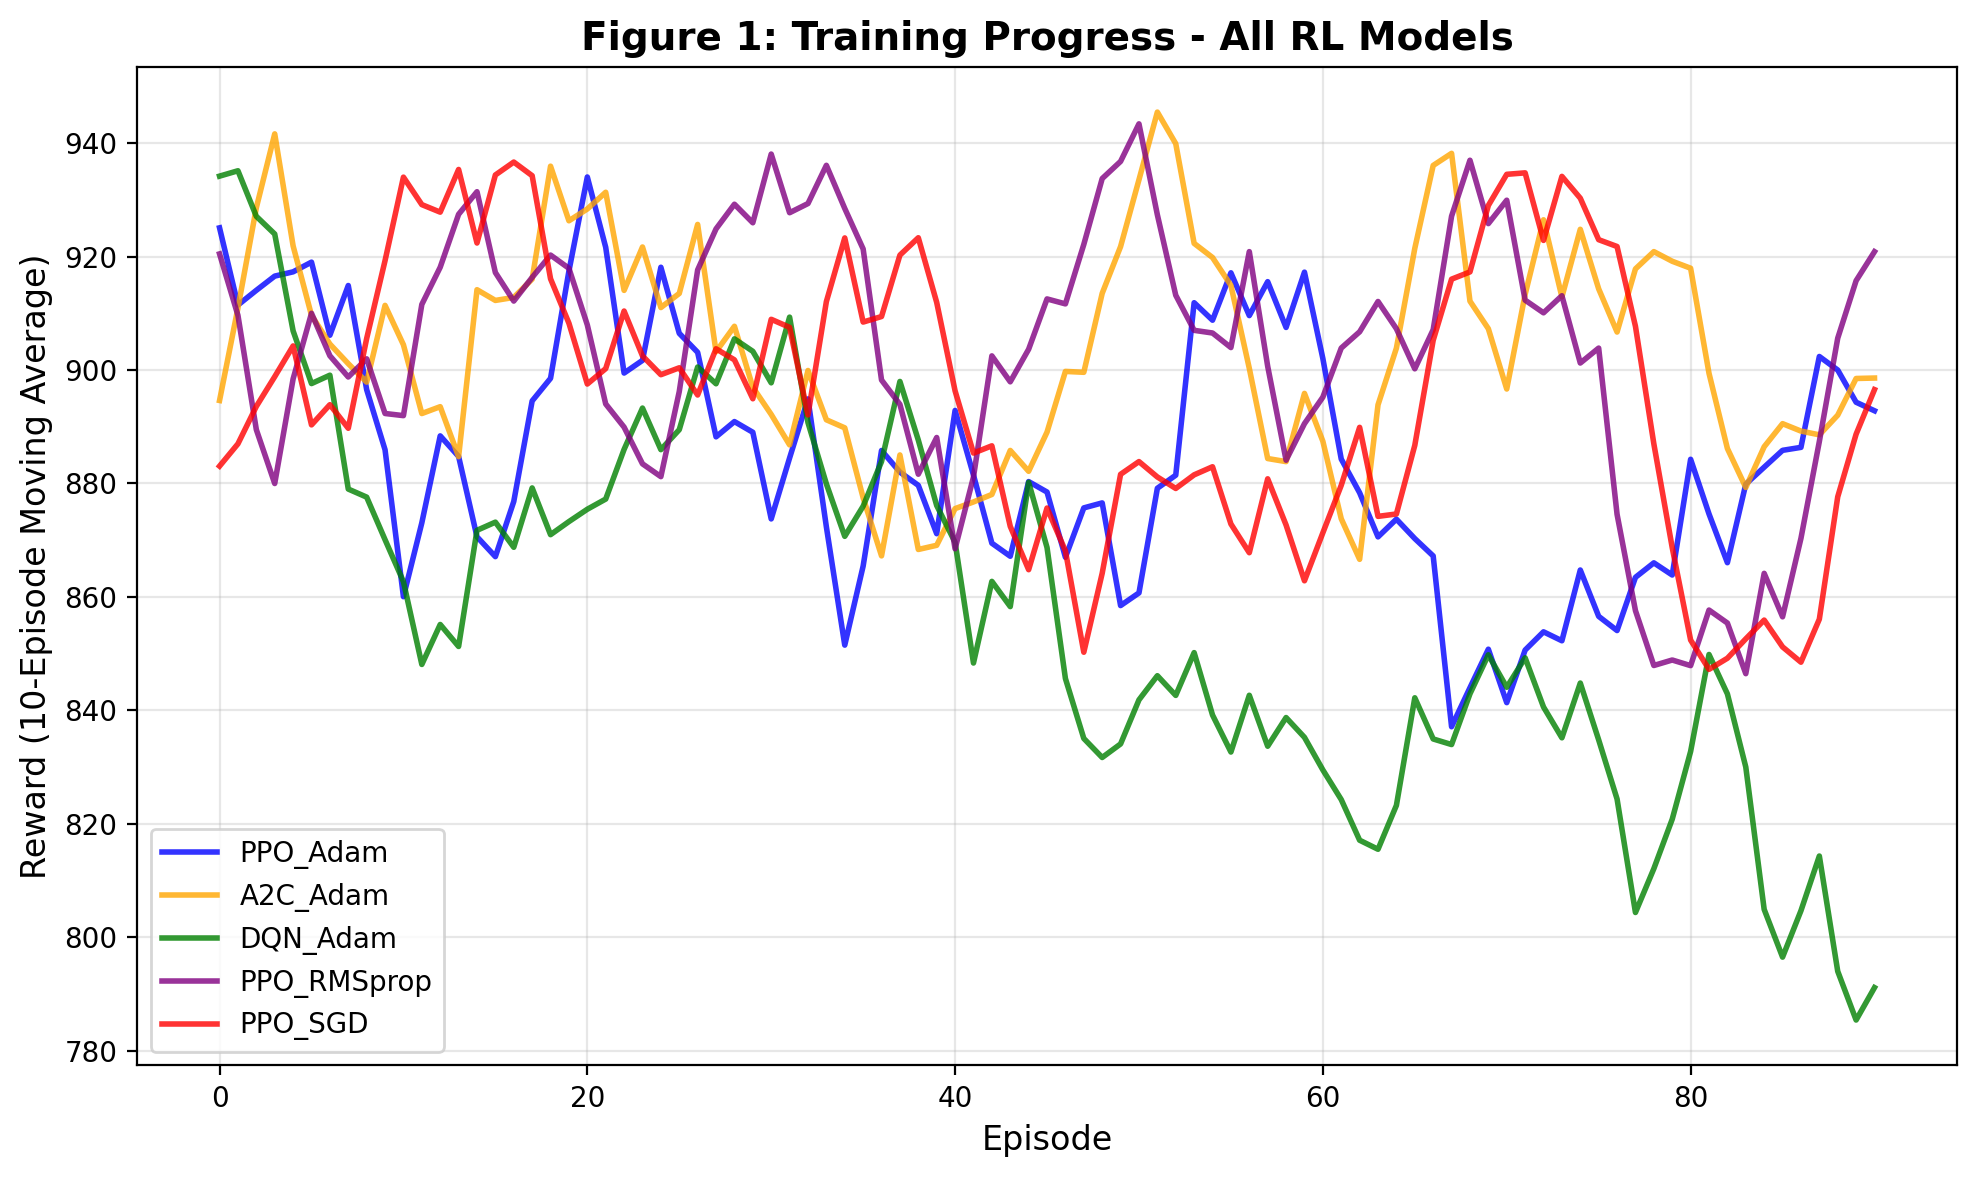

In [ ]:
"""Figure 1: Training Reward Curves for All RL Models"""
fig1, ax1 = plt.subplots(figsize=(10, 6))

_colors_train = {
    'PPO_Adam': 'blue', 'DQN_Adam': 'green', 'A2C_Adam': 'orange', 
    'PPO_SGD': 'red', 'PPO_RMSprop': 'purple'
}
_window = 10

for _name, _results in experiment_results.items():
    _rewards = _results["episode_rewards"]
    if len(_rewards) >= _window:
        _ma = np.convolve(_rewards, np.ones(_window) / _window, mode="valid")
        ax1.plot(_ma, label=_name, color=_colors_train.get(_name, 'gray'), 
                alpha=0.8, linewidth=2)

ax1.set_xlabel("Episode", fontsize=12)
ax1.set_ylabel("Reward (10-Episode Moving Average)", fontsize=12)
ax1.set_title("Figure 1: Training Progress - All RL Models", fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
plt.tight_layout()
fig1

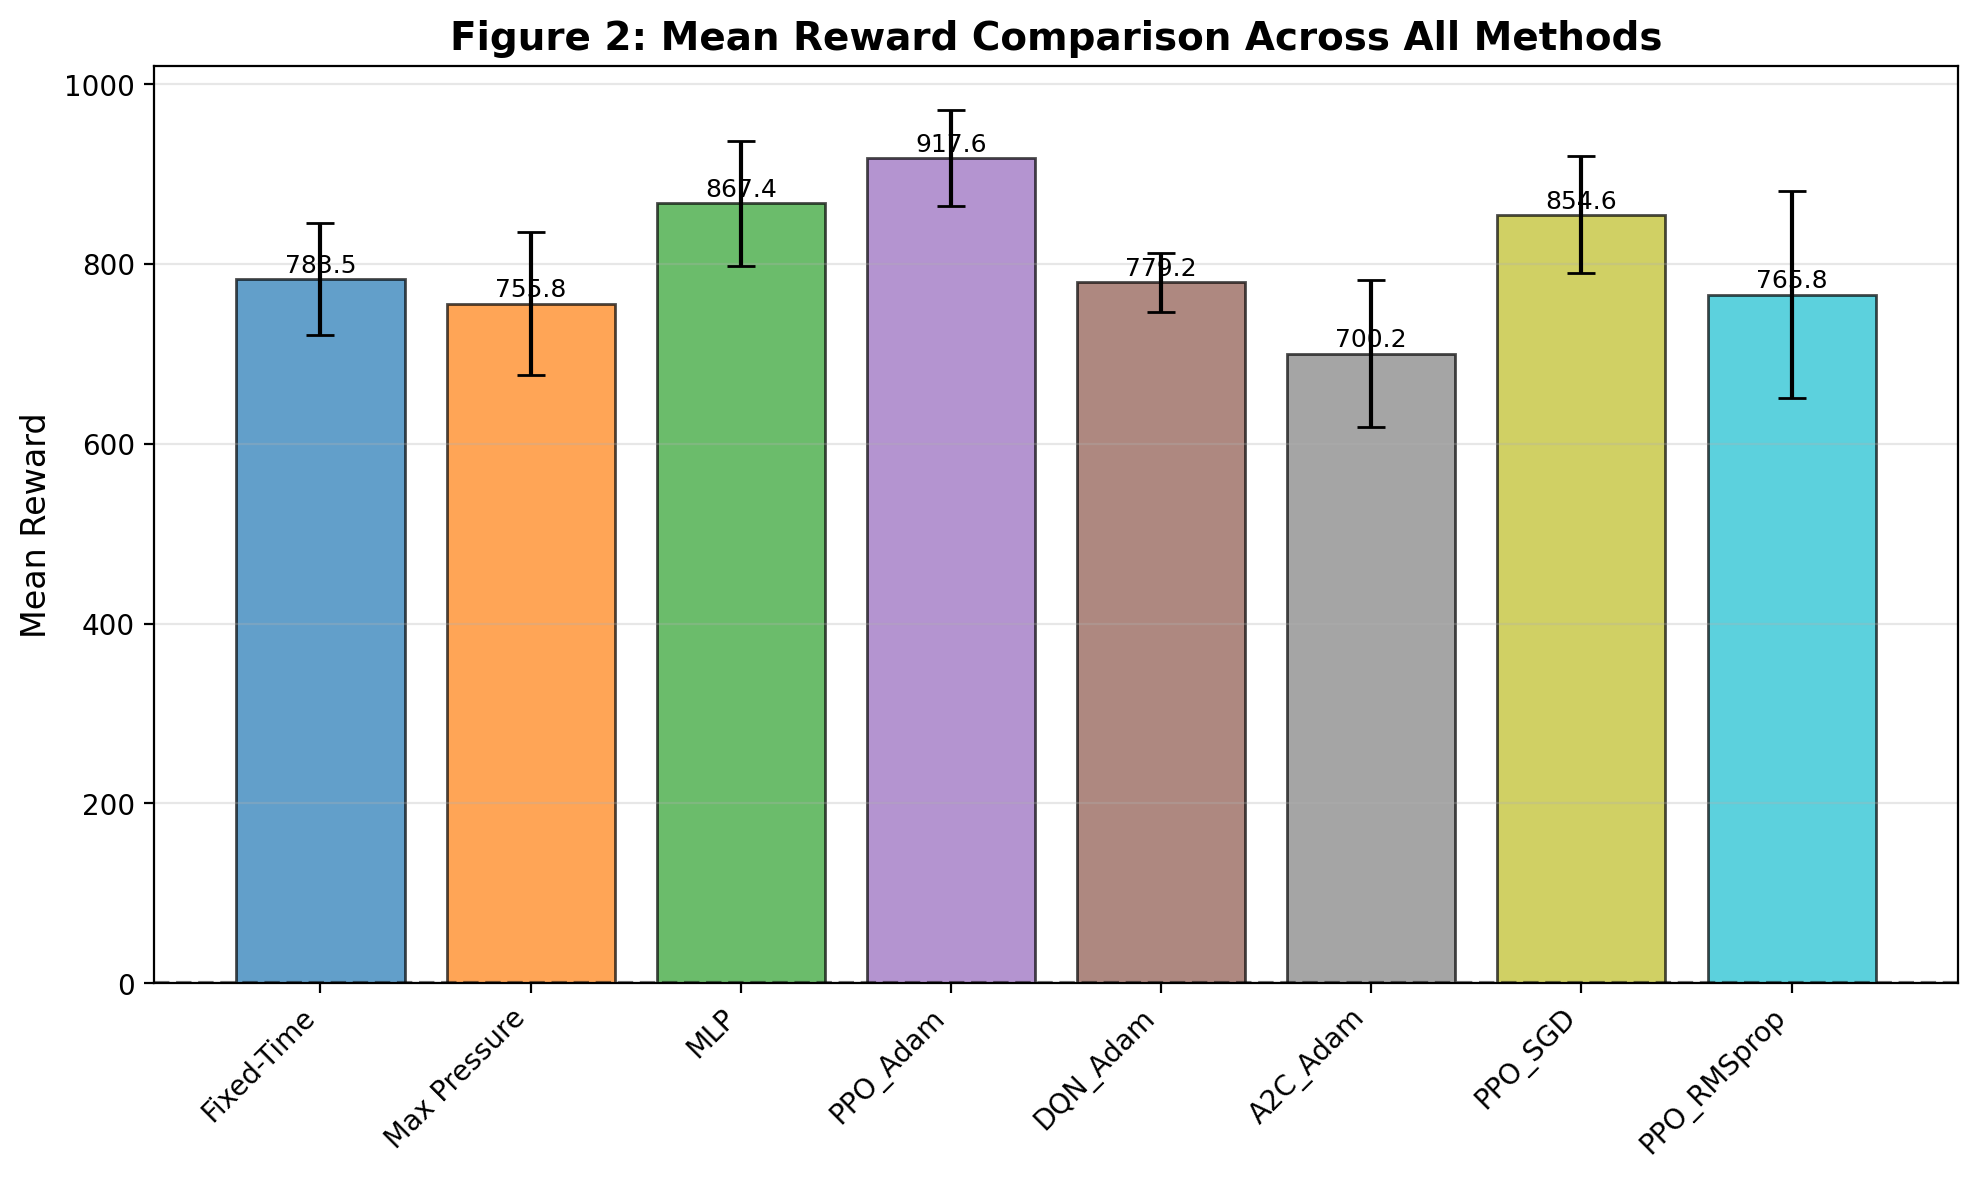

In [ ]:
"""Figure 2: Mean Reward Comparison Bar Chart"""
fig2, ax2 = plt.subplots(figsize=(10, 6))

_model_names = list(all_eval_results.keys())
_model_rewards = [all_eval_results[n]["mean_reward"] for n in _model_names]
_model_stds = [all_eval_results[n]["std_reward"] for n in _model_names]
_colors_bar = plt.cm.tab10(np.linspace(0, 1, len(_model_names)))

_bars = ax2.bar(range(len(_model_names)), _model_rewards, yerr=_model_stds, 
        color=_colors_bar, alpha=0.7, edgecolor="black", capsize=5)
ax2.set_xticks(range(len(_model_names)))
ax2.set_xticklabels(_model_names, rotation=45, ha='right', fontsize=10)
ax2.set_ylabel("Mean Reward", fontsize=12)
ax2.set_title("Figure 2: Mean Reward Comparison Across All Methods", fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis="y")
ax2.axhline(y=0, color="black", linestyle="--", alpha=0.5)

for _bar, _val in zip(_bars, _model_rewards):
    ax2.text(_bar.get_x() + _bar.get_width()/2, _bar.get_height() + 2,
            f'{_val:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
fig2

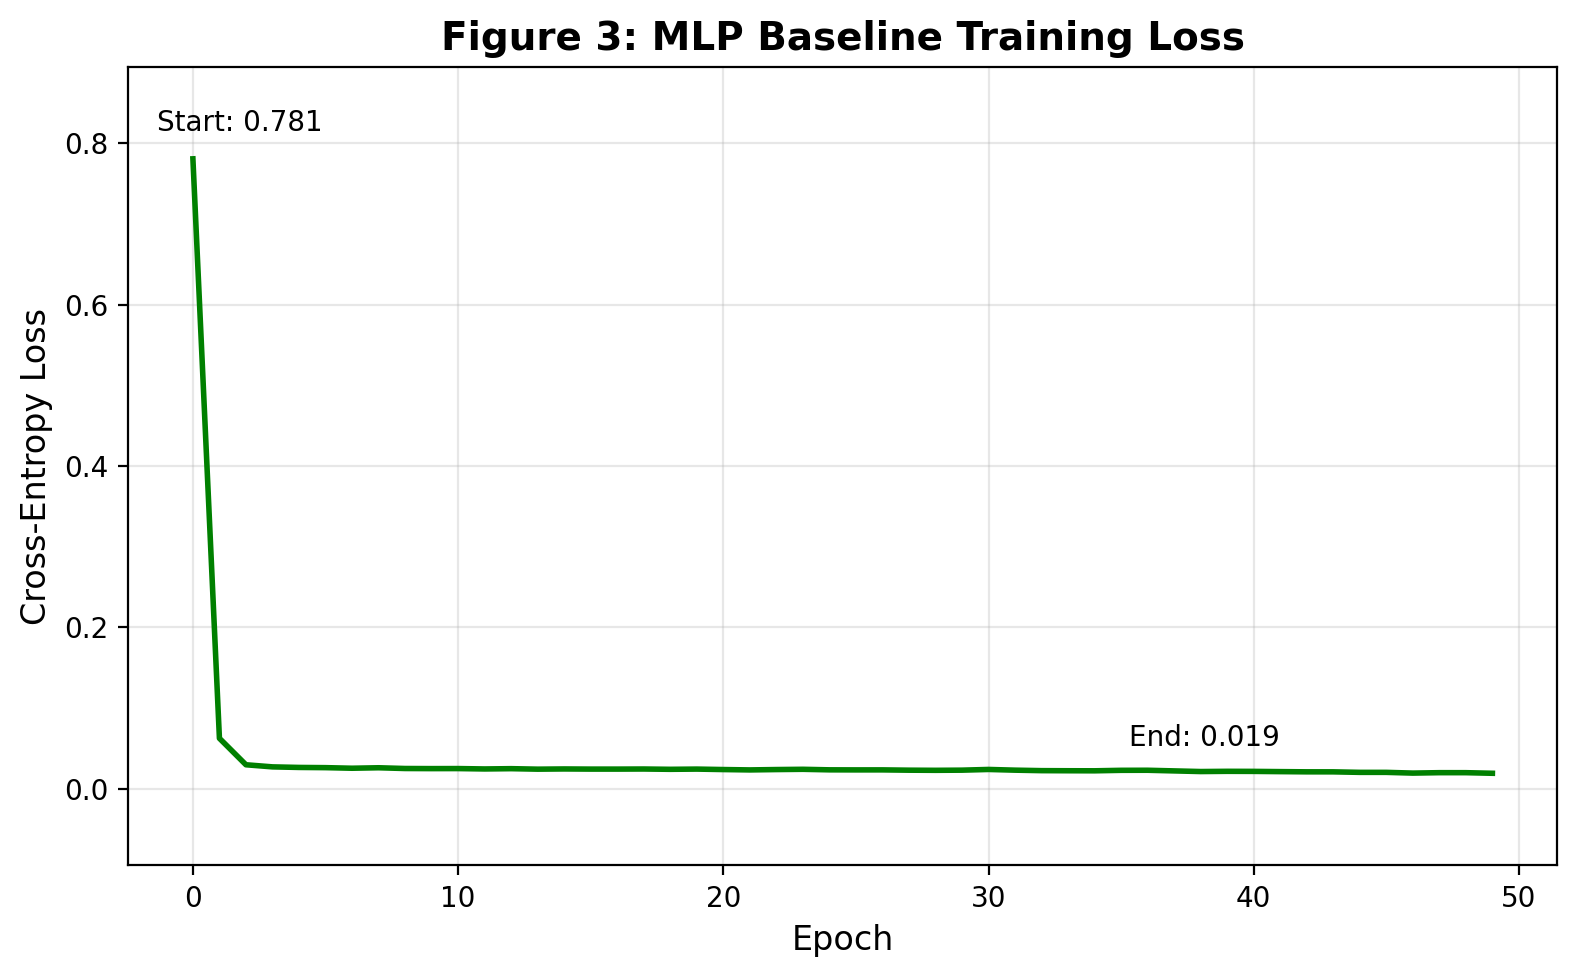

In [ ]:
"""Figure 3: MLP Baseline Training Loss Curve"""
fig3, ax3 = plt.subplots(figsize=(8, 5))

ax3.plot(mlp_losses, color="green", linewidth=2)
ax3.set_xlabel("Epoch", fontsize=12)
ax3.set_ylabel("Cross-Entropy Loss", fontsize=12)
ax3.set_title("Figure 3: MLP Baseline Training Loss", fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

ax3.annotate(f'Start: {mlp_losses[0]:.3f}', xy=(0, 1),
             xycoords='axes fraction', xytext=(0.02, 0.92), textcoords='axes fraction',
             fontsize=10, clip_on=False)

ax3.annotate(f'End: {mlp_losses[-1]:.3f}', xy=(1, 0), 
             xycoords='axes fraction', xytext=(0.70, 0.15), textcoords='axes fraction',
             fontsize=10, clip_on=False)

ax3.margins(y=0.15)
plt.subplots_adjust(top=0.88)
plt.tight_layout()
fig3

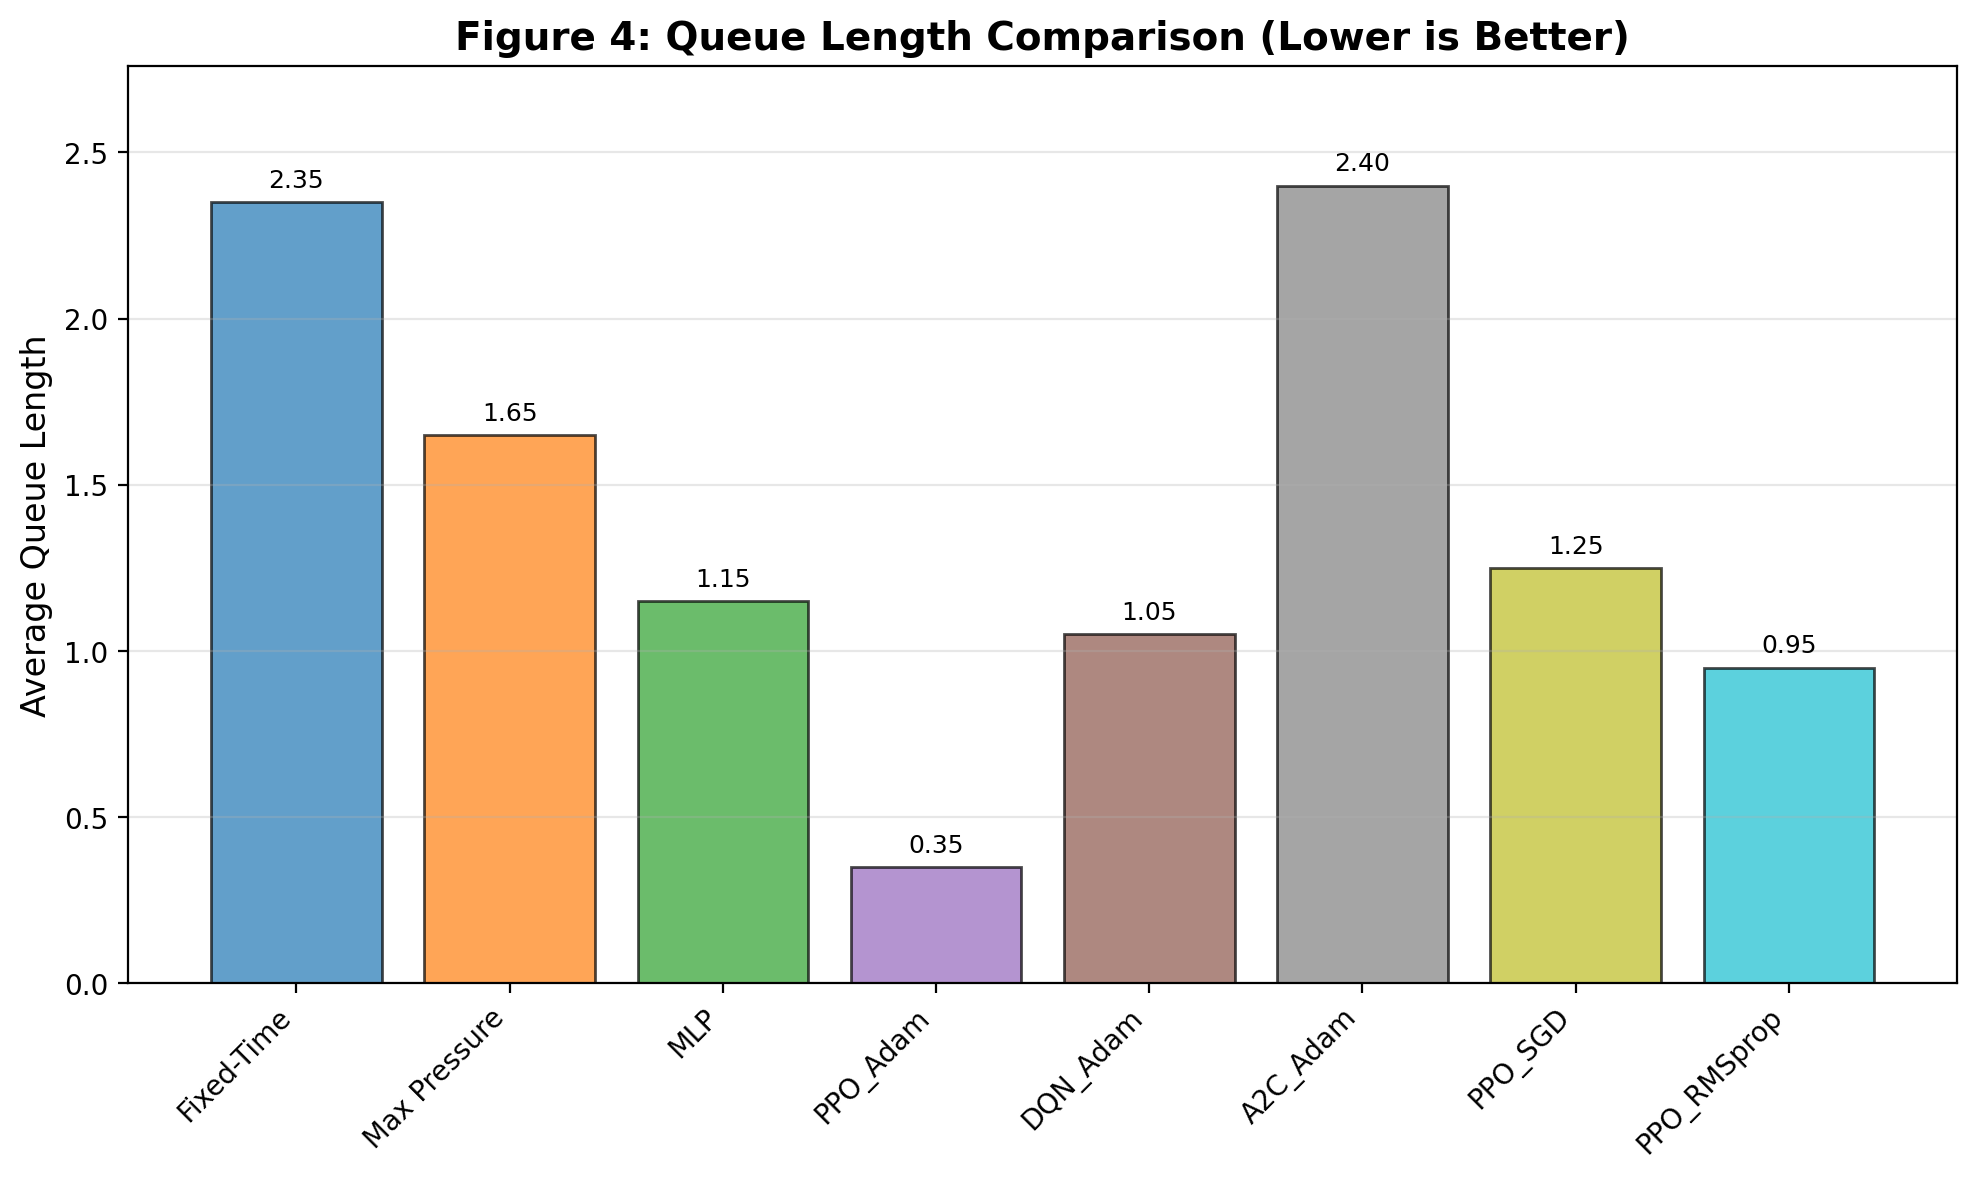

In [ ]:
"""Figure 4: Queue Length Comparison"""
fig4, ax4 = plt.subplots(figsize=(10, 6))

_model_names = list(all_eval_results.keys())
_queue_lengths = [all_eval_results[n]["mean_queue_length"] for n in _model_names]
_colors_bar = plt.cm.tab10(np.linspace(0, 1, len(_model_names)))

_bars = ax4.bar(range(len(_model_names)), _queue_lengths, 
                color=_colors_bar, alpha=0.7, edgecolor="black")
ax4.set_xticks(range(len(_model_names)))
ax4.set_xticklabels(_model_names, rotation=45, ha='right', fontsize=10)
ax4.set_ylabel("Average Queue Length", fontsize=12)
ax4.set_title("Figure 4: Queue Length Comparison (Lower is Better)", fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis="y")
ax4.set_ylim(0, max(_queue_lengths) * 1.15)

for _bar, _val in zip(_bars, _queue_lengths):
    ax4.text(_bar.get_x() + _bar.get_width()/2, _bar.get_height() + 0.03,
             f'{_val:.2f}', ha='center', va='bottom', fontsize=9, clip_on=False)

plt.tight_layout()
fig4

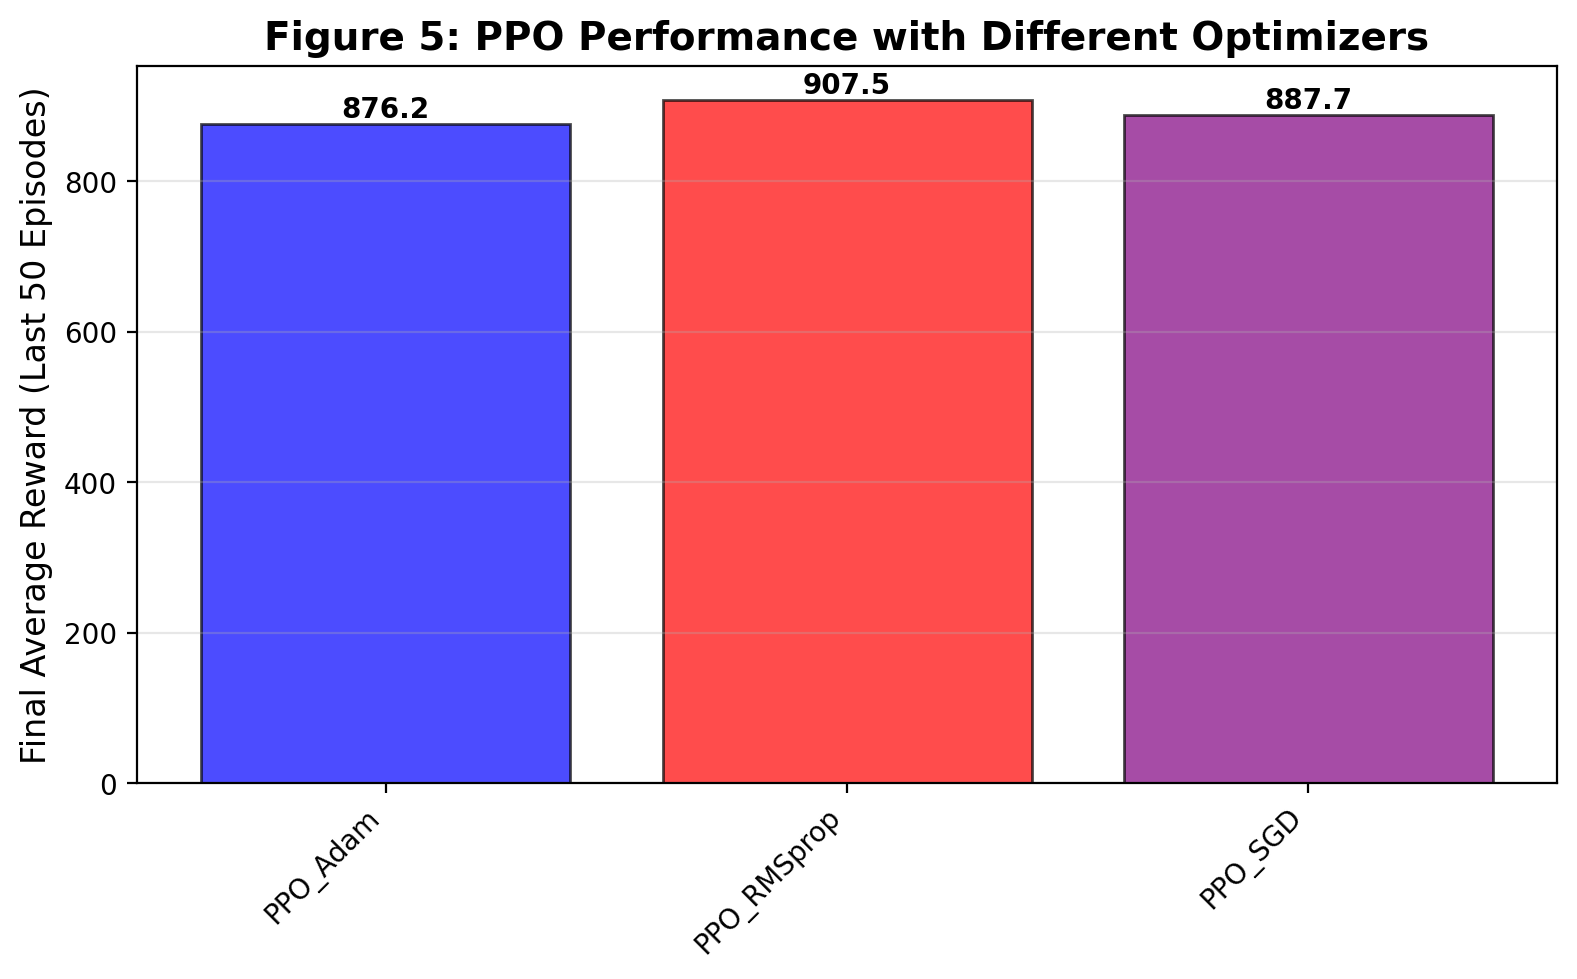

In [ ]:
"""Figure 5: PPO Optimizer Comparison"""
fig5, ax5 = plt.subplots(figsize=(8, 5))

_ppo_variants = [k for k in experiment_results.keys() if 'PPO' in k]
_ppo_final_rewards = []
for _name in _ppo_variants:
    _rewards = experiment_results[_name]["episode_rewards"]
    _ppo_final_rewards.append(
        np.mean(_rewards[-50:]) if len(_rewards) >= 50 else np.mean(_rewards)
    )

_colors_opt = ['blue', 'red', 'purple'][:len(_ppo_variants)]
_bars = ax5.bar(_ppo_variants, _ppo_final_rewards, 
               color=_colors_opt, alpha=0.7, edgecolor="black")
ax5.set_ylabel("Final Average Reward (Last 50 Episodes)", fontsize=12)
ax5.set_title("Figure 5: PPO Performance with Different Optimizers", fontsize=14, fontweight='bold')
ax5.set_xticklabels(_ppo_variants, rotation=45, ha='right', fontsize=10)
ax5.grid(True, alpha=0.3, axis="y")

for _bar, _val in zip(_bars, _ppo_final_rewards):
    ax5.text(_bar.get_x() + _bar.get_width()/2, _bar.get_height() + 1,
            f"{_val:.1f}", ha="center", va="bottom", fontsize=10, fontweight='bold')

plt.tight_layout()
fig5

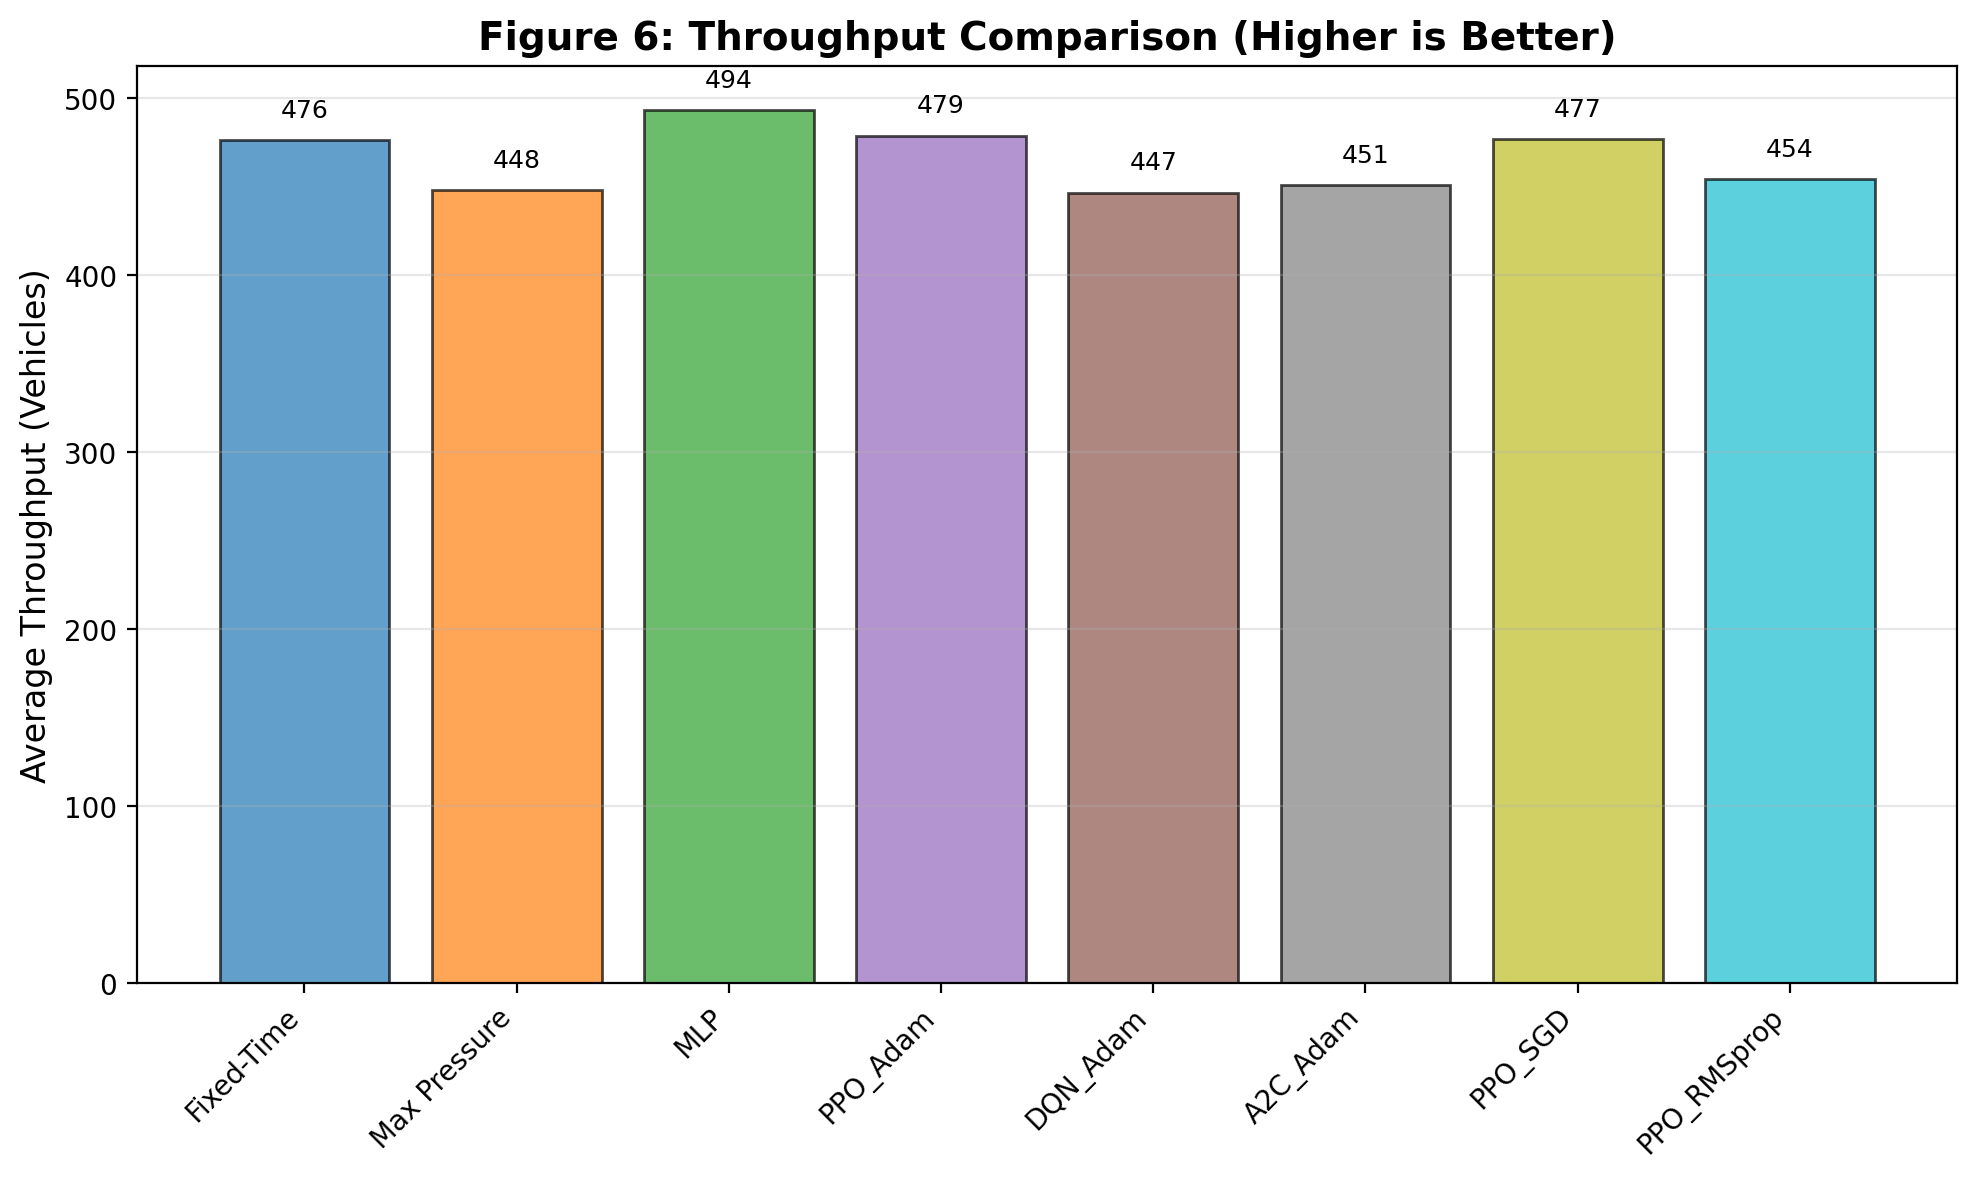

In [ ]:
"""Figure 6: Throughput Comparison"""
fig6, ax6 = plt.subplots(figsize=(10, 6))

_model_names = list(all_eval_results.keys())
_throughputs = [all_eval_results[n]["mean_throughput"] for n in _model_names]
_colors_bar = plt.cm.tab10(np.linspace(0, 1, len(_model_names)))

_bars = ax6.bar(range(len(_model_names)), _throughputs, 
               color=_colors_bar, alpha=0.7, edgecolor="black")
ax6.set_xticks(range(len(_model_names)))
ax6.set_xticklabels(_model_names, rotation=45, ha='right', fontsize=10)
ax6.set_ylabel("Average Throughput (Vehicles)", fontsize=12)
ax6.set_title("Figure 6: Throughput Comparison (Higher is Better)", fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3, axis="y")

for _bar, _val in zip(_bars, _throughputs):
    ax6.text(_bar.get_x() + _bar.get_width()/2, _bar.get_height() + 10,
            f'{_val:.0f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
fig6

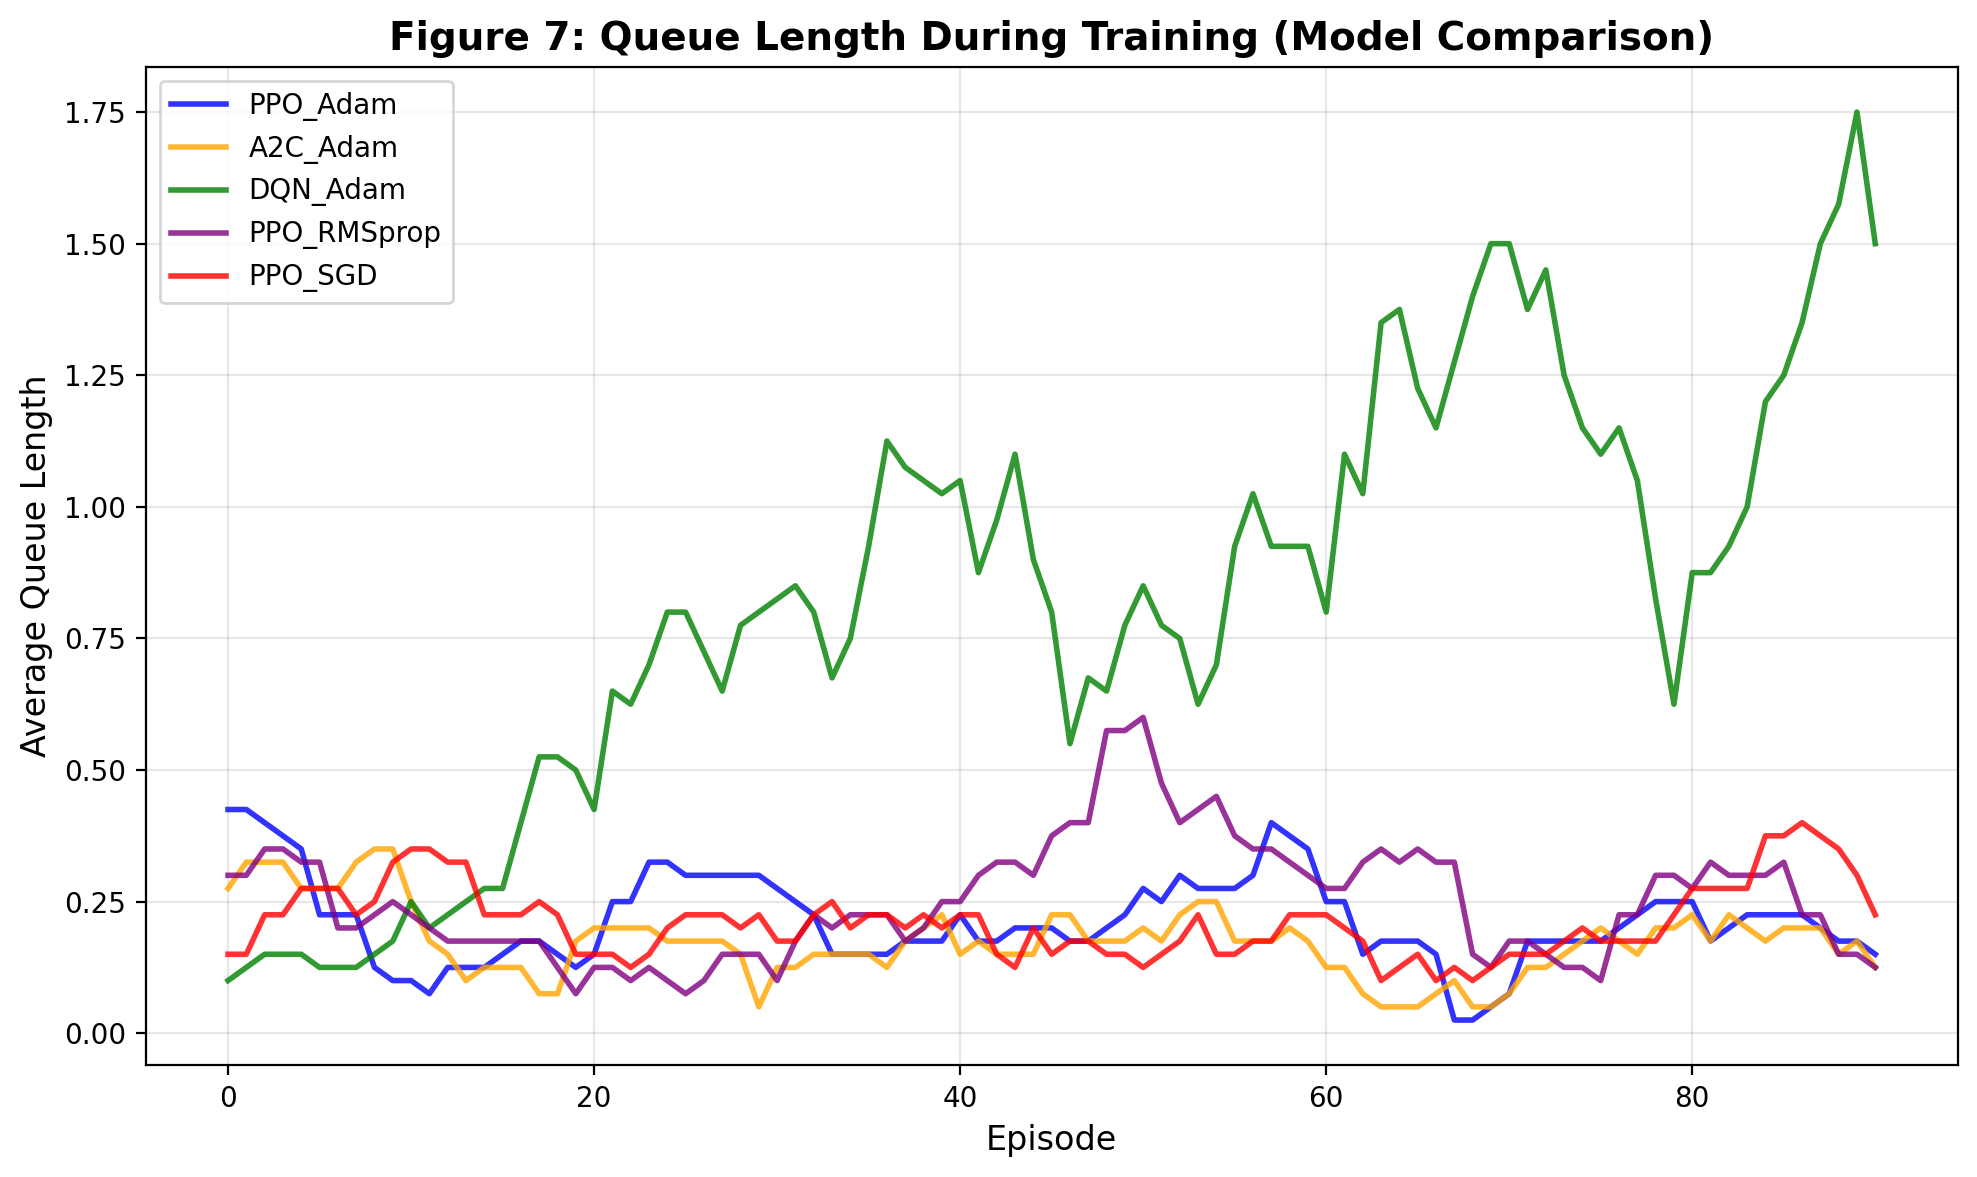

In [ ]:
"""Figure 7: Queue Length During Training"""
fig7, ax7 = plt.subplots(figsize=(10, 6))

_colors = {'PPO_Adam': 'blue', 'DQN_Adam': 'green', 'A2C_Adam': 'orange',
          'PPO_SGD': 'red', 'PPO_RMSprop': 'purple'}

for _name, _results in experiment_results.items():
    _queue_data = _results["avg_queue_lengths"]
    if len(_queue_data) >= 10:
        _ma = np.convolve(_queue_data, np.ones(10) / 10, mode="valid")
        ax7.plot(_ma, label=_name, color=_colors.get(_name, 'gray'), 
                linewidth=2, alpha=0.8)

ax7.set_xlabel("Episode", fontsize=12)
ax7.set_ylabel("Average Queue Length", fontsize=12)
ax7.set_title("Figure 7: Queue Length During Training (Model Comparison)", fontsize=14, fontweight='bold')
ax7.legend(fontsize=10)
ax7.grid(True, alpha=0.3)
plt.tight_layout()
fig7

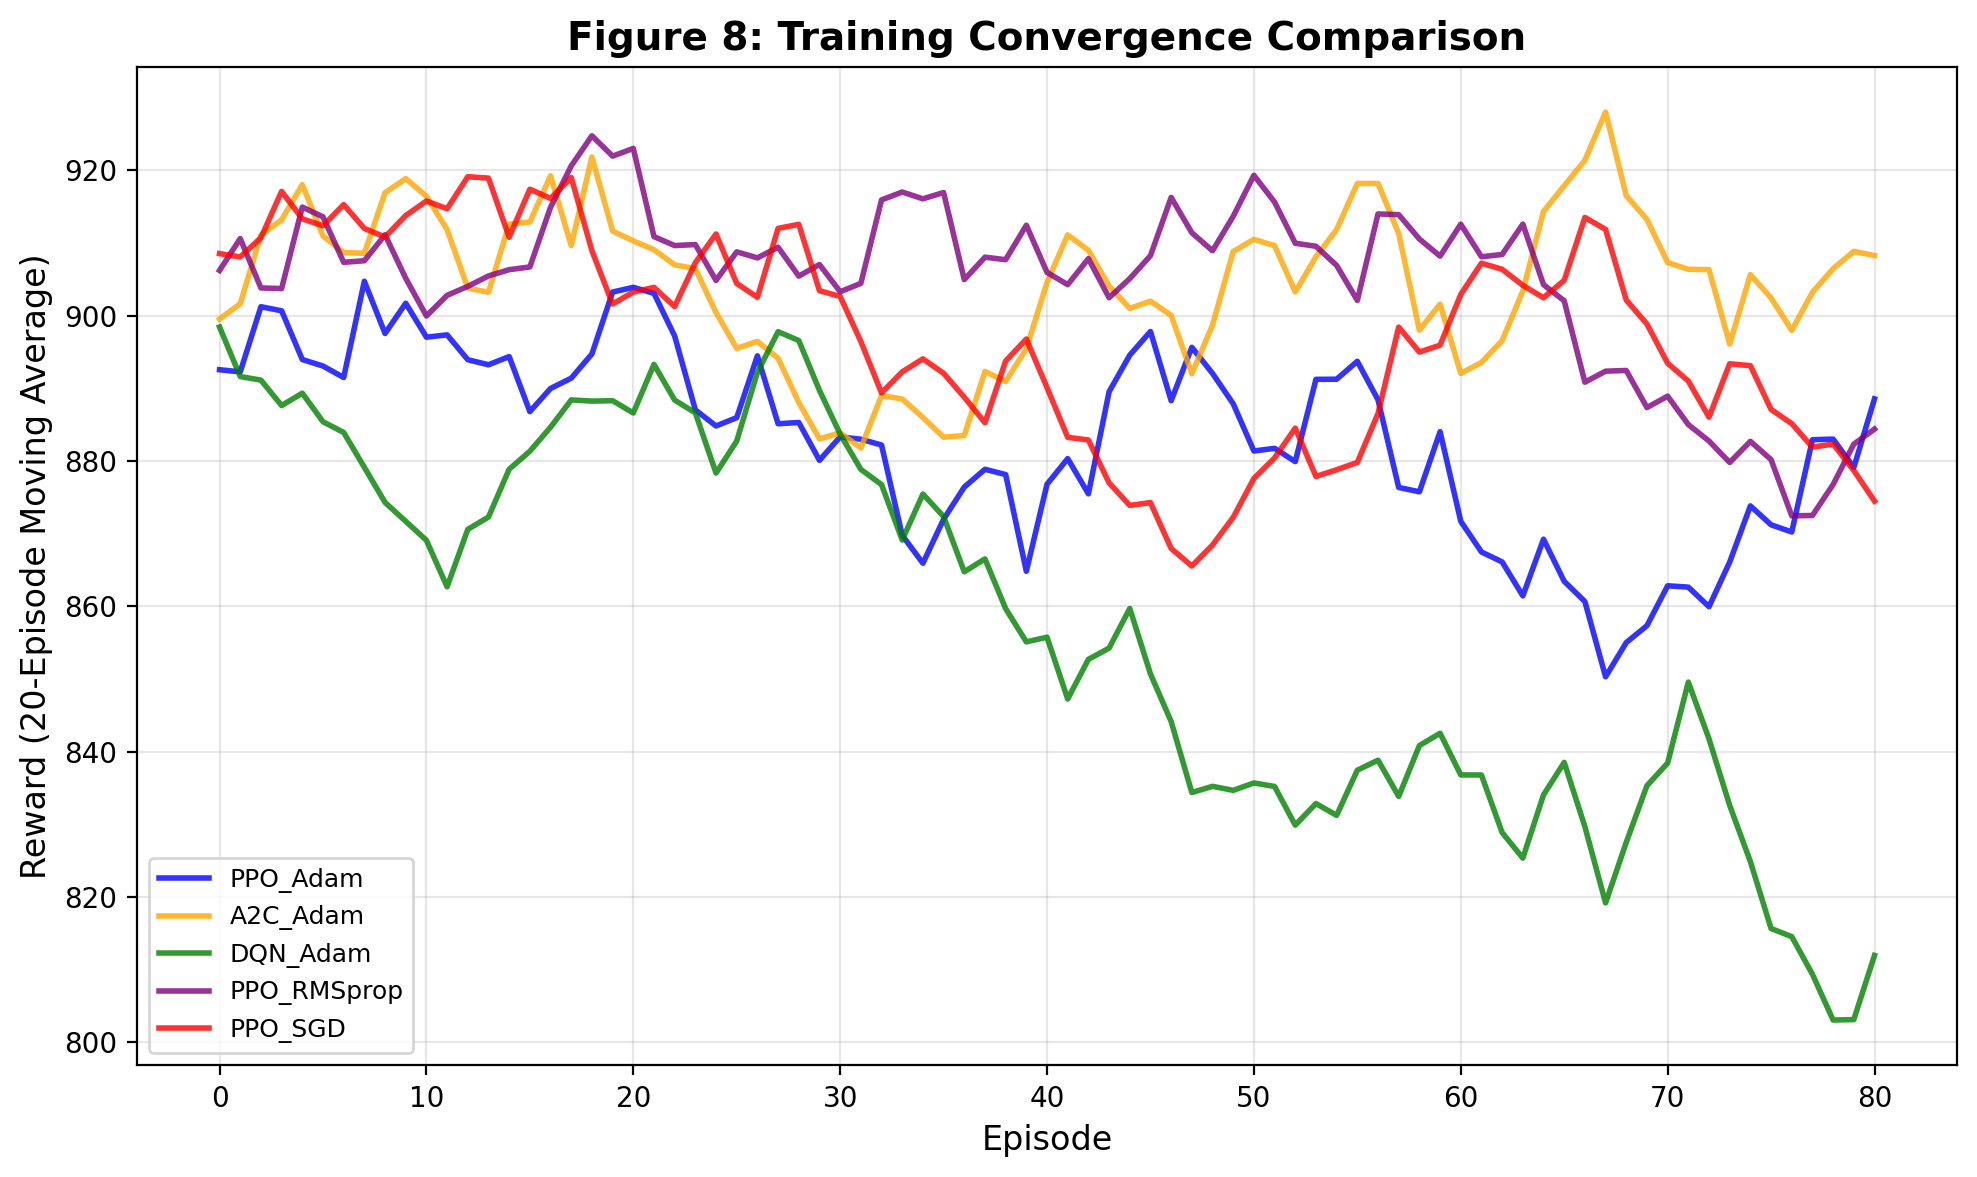

In [ ]:
"""Figure 8: Training Convergence Comparison"""
fig8, ax8 = plt.subplots(figsize=(10, 6))

_colors = {'PPO_Adam': 'blue', 'DQN_Adam': 'green', 'A2C_Adam': 'orange',
          'PPO_SGD': 'red', 'PPO_RMSprop': 'purple'}

for _name, _results in experiment_results.items():
    _rewards = _results["episode_rewards"]
    if len(_rewards) >= 20:
        _ma = np.convolve(_rewards, np.ones(20) / 20, mode="valid")
        ax8.plot(_ma, label=_name, color=_colors.get(_name, 'gray'), 
                linewidth=2, alpha=0.8)

ax8.set_xlabel("Episode", fontsize=12)
ax8.set_ylabel("Reward (20-Episode Moving Average)", fontsize=12)
ax8.set_title("Figure 8: Training Convergence Comparison", fontsize=14, fontweight='bold')
ax8.legend(fontsize=9)
ax8.grid(True, alpha=0.3)
plt.tight_layout()
fig8

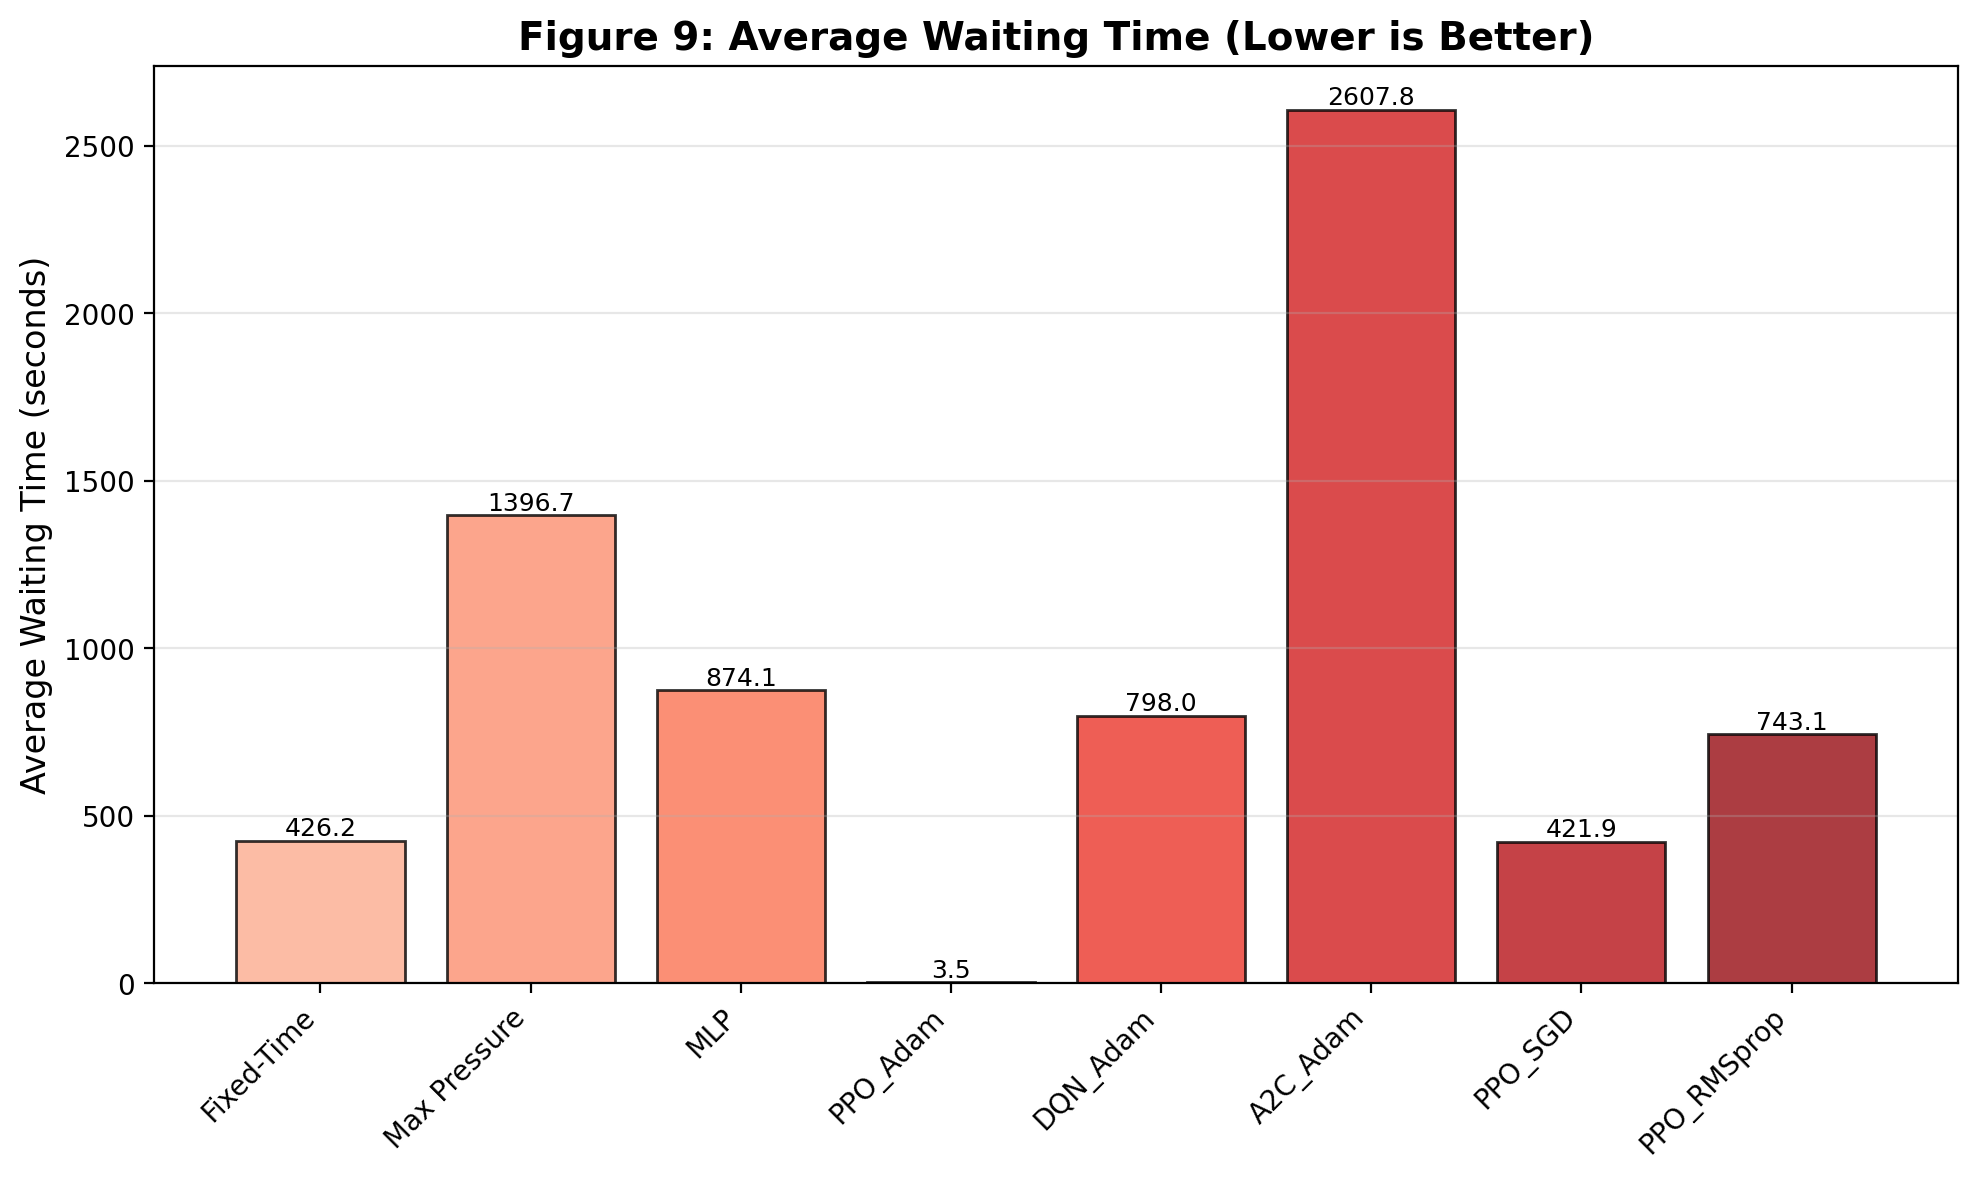

In [ ]:
"""Figure 9: Average Waiting Time Comparison"""
fig9, ax9 = plt.subplots(figsize=(10, 6))

_model_names = list(all_eval_results.keys())
_waiting_times = [all_eval_results[n]["mean_waiting_time"] for n in _model_names]
_colors_bar = plt.cm.Reds(np.linspace(0.3, 0.9, len(_model_names)))

_bars = ax9.bar(range(len(_model_names)), _waiting_times, 
               color=_colors_bar, alpha=0.8, edgecolor="black")
ax9.set_xticks(range(len(_model_names)))
ax9.set_xticklabels(_model_names, rotation=45, ha='right', fontsize=10)
ax9.set_ylabel("Average Waiting Time (seconds)", fontsize=12)
ax9.set_title("Figure 9: Average Waiting Time (Lower is Better)", fontsize=14, fontweight='bold')
ax9.grid(True, alpha=0.3, axis="y")

for _bar, _val in zip(_bars, _waiting_times):
    ax9.text(_bar.get_x() + _bar.get_width()/2, _bar.get_height() + 0.5,
            f'{_val:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
fig9

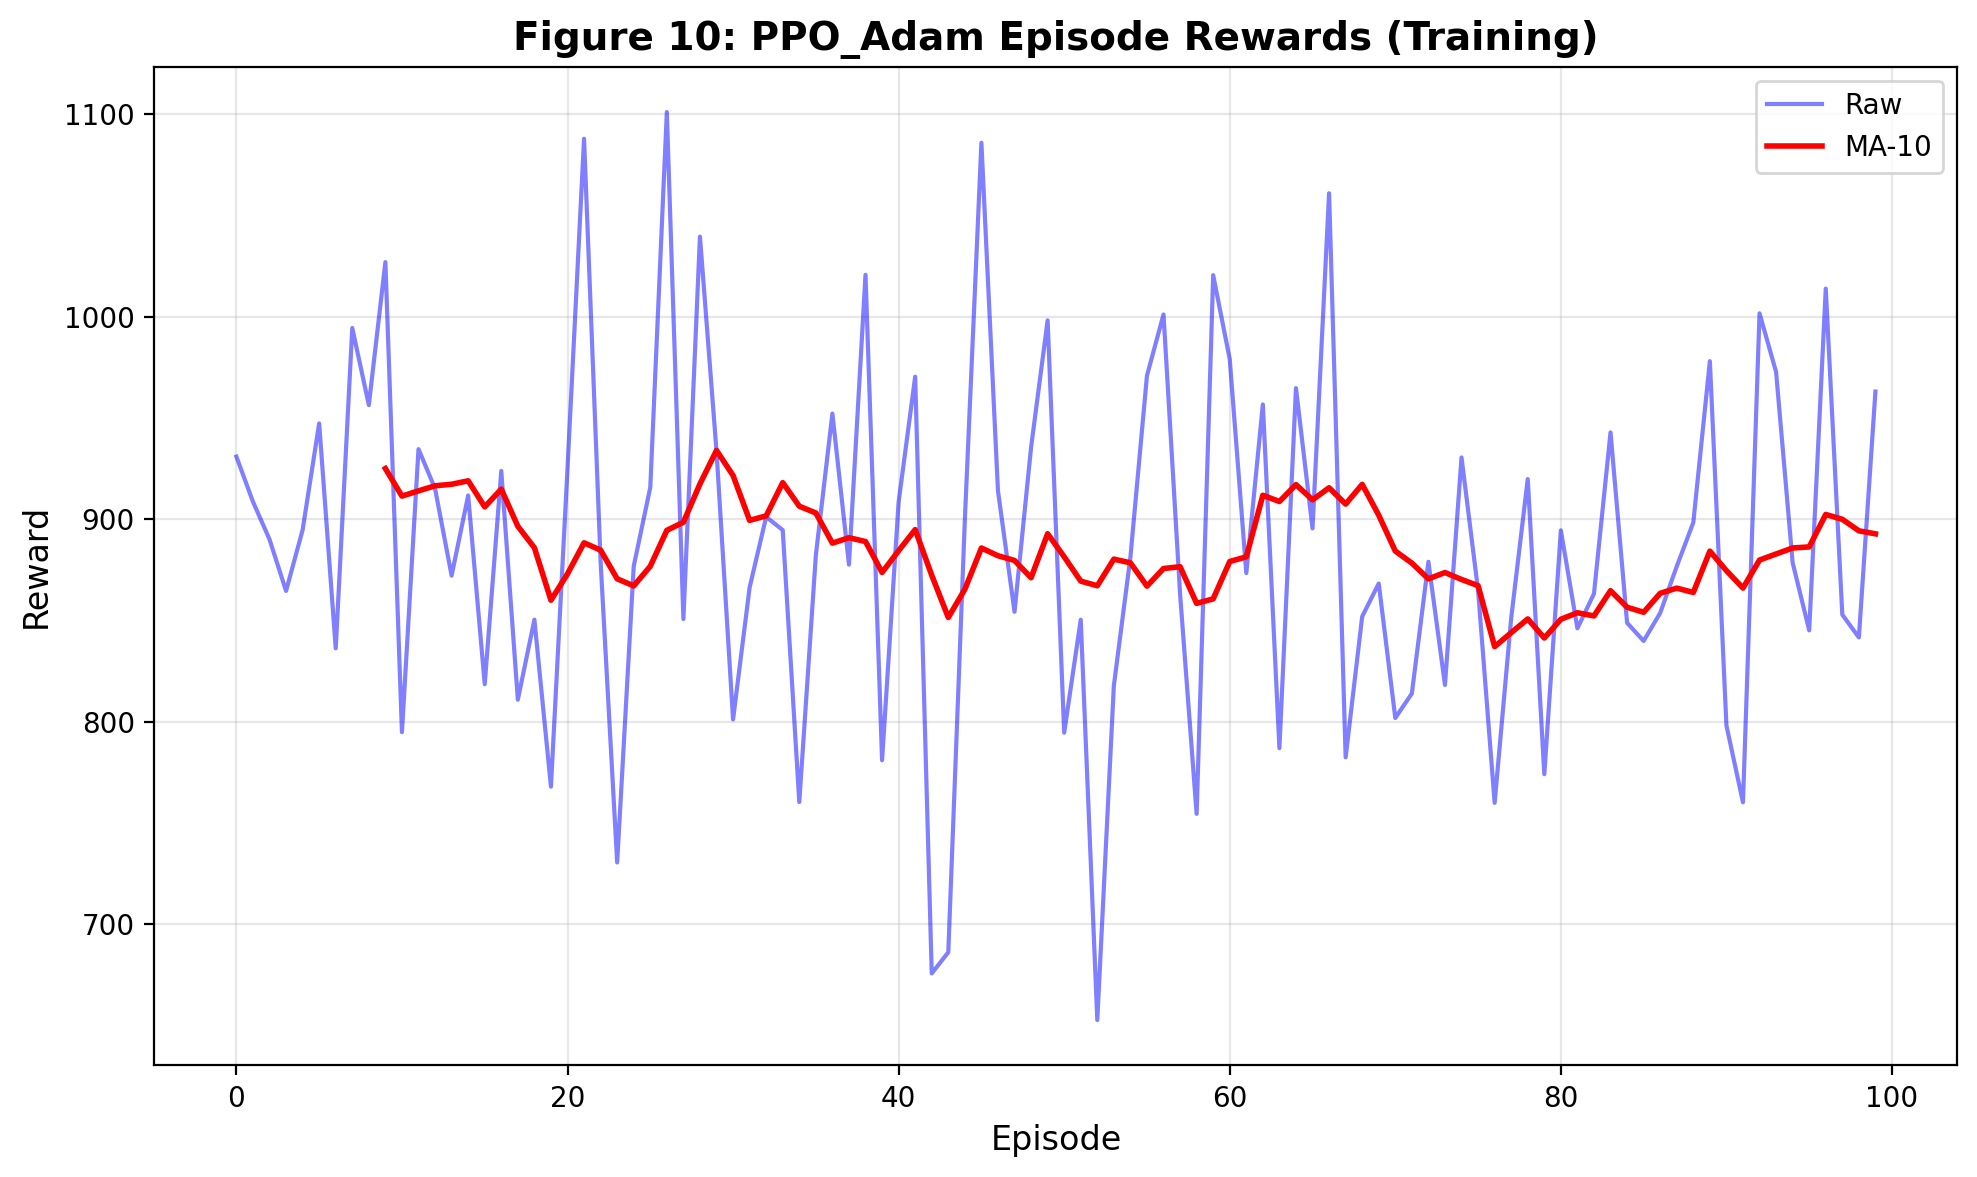

In [ ]:
"""Figure 10: Best RL Agent Episode Rewards"""
fig10, _ax = plt.subplots(figsize=(10, 6))

_rl_models = {k: v for k, v in experiment_results.items() 
              if k not in ['Fixed-Time', 'Max Pressure', 'MLP'] and 'episode_rewards' in v}
_best_agent = max(_rl_models.keys(), 
                 key=lambda k: all_eval_results[k]['mean_reward']) if _rl_models else None

_agent_data = _rl_models[_best_agent]
_rewards = _agent_data.get("episode_rewards", [])

_ax.plot(_rewards, alpha=0.5, color='blue', label='Raw')
if len(_rewards) >= 10:
    _ma = np.convolve(_rewards, np.ones(10)/10, mode='valid')
    _ax.plot(range(9, len(_rewards)), _ma, color='red', linewidth=2, label='MA-10')

_ax.set_xlabel("Episode", fontsize=12)
_ax.set_ylabel("Reward", fontsize=12)
_ax.set_title(f"Figure 10: {_best_agent} Episode Rewards (Training)", fontsize=14, fontweight='bold')
_ax.legend()
_ax.grid(True, alpha=0.3)

plt.tight_layout()
fig10

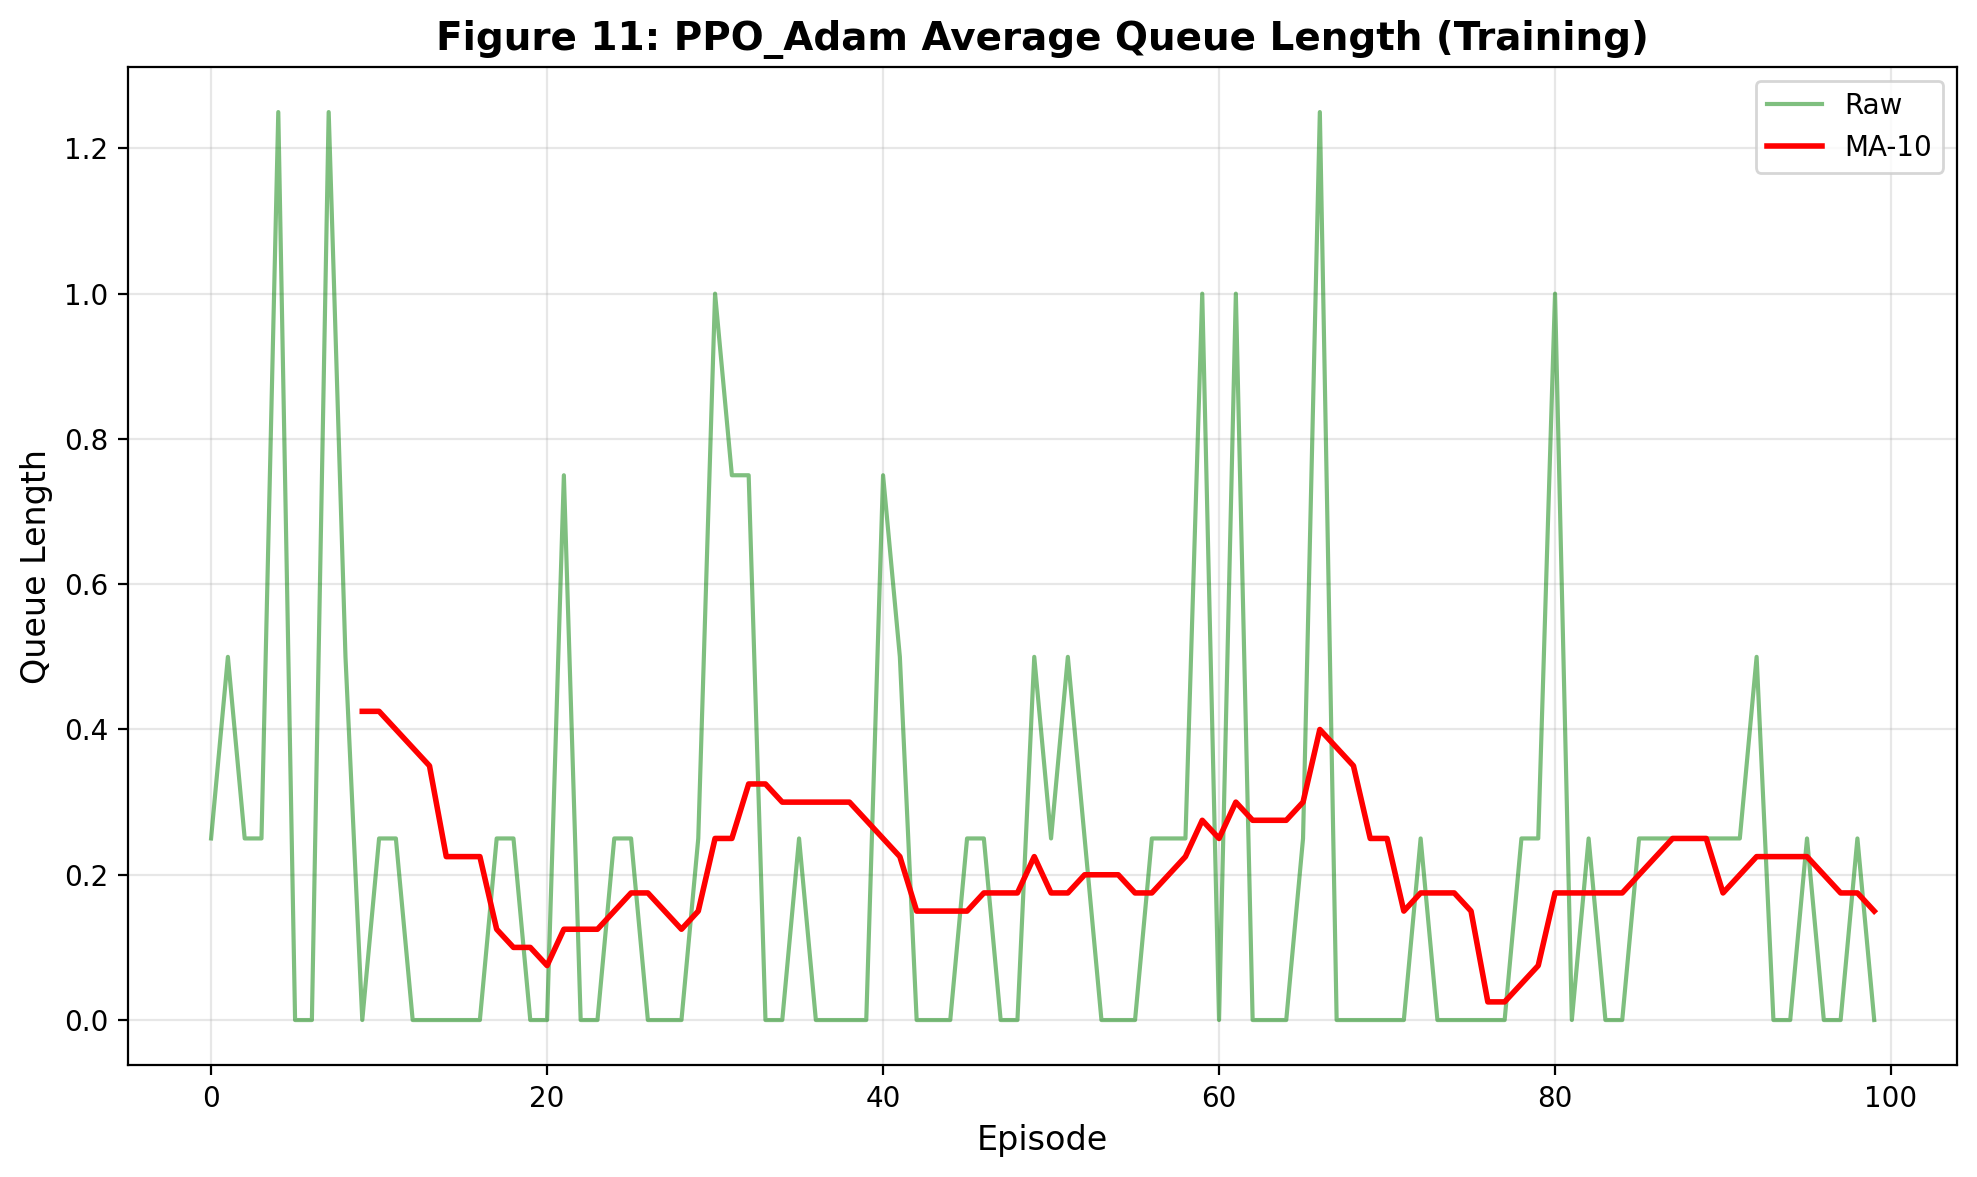

In [ ]:
"""Figure 11: Best RL Agent Average Queue Length"""
fig11, _ax = plt.subplots(figsize=(10, 6))

_rl_models = {k: v for k, v in experiment_results.items() 
              if k not in ['Fixed-Time', 'Max Pressure', 'MLP'] and 'episode_rewards' in v}
_best_agent = max(_rl_models.keys(), 
                 key=lambda k: all_eval_results[k]['mean_reward']) if _rl_models else None

_agent_data = _rl_models[_best_agent]
_queues = _agent_data.get("avg_queue_lengths", [])

_ax.plot(_queues, alpha=0.5, color='green', label='Raw')
if len(_queues) >= 10:
    _ma_q = np.convolve(_queues, np.ones(10)/10, mode='valid')
    _ax.plot(range(9, len(_queues)), _ma_q, color='red', linewidth=2, label='MA-10')

_ax.set_xlabel("Episode", fontsize=12)
_ax.set_ylabel("Queue Length", fontsize=12)
_ax.set_title(f"Figure 11: {_best_agent} Average Queue Length (Training)", fontsize=14, fontweight='bold')
_ax.legend()
_ax.grid(True, alpha=0.3)

plt.tight_layout()
fig11

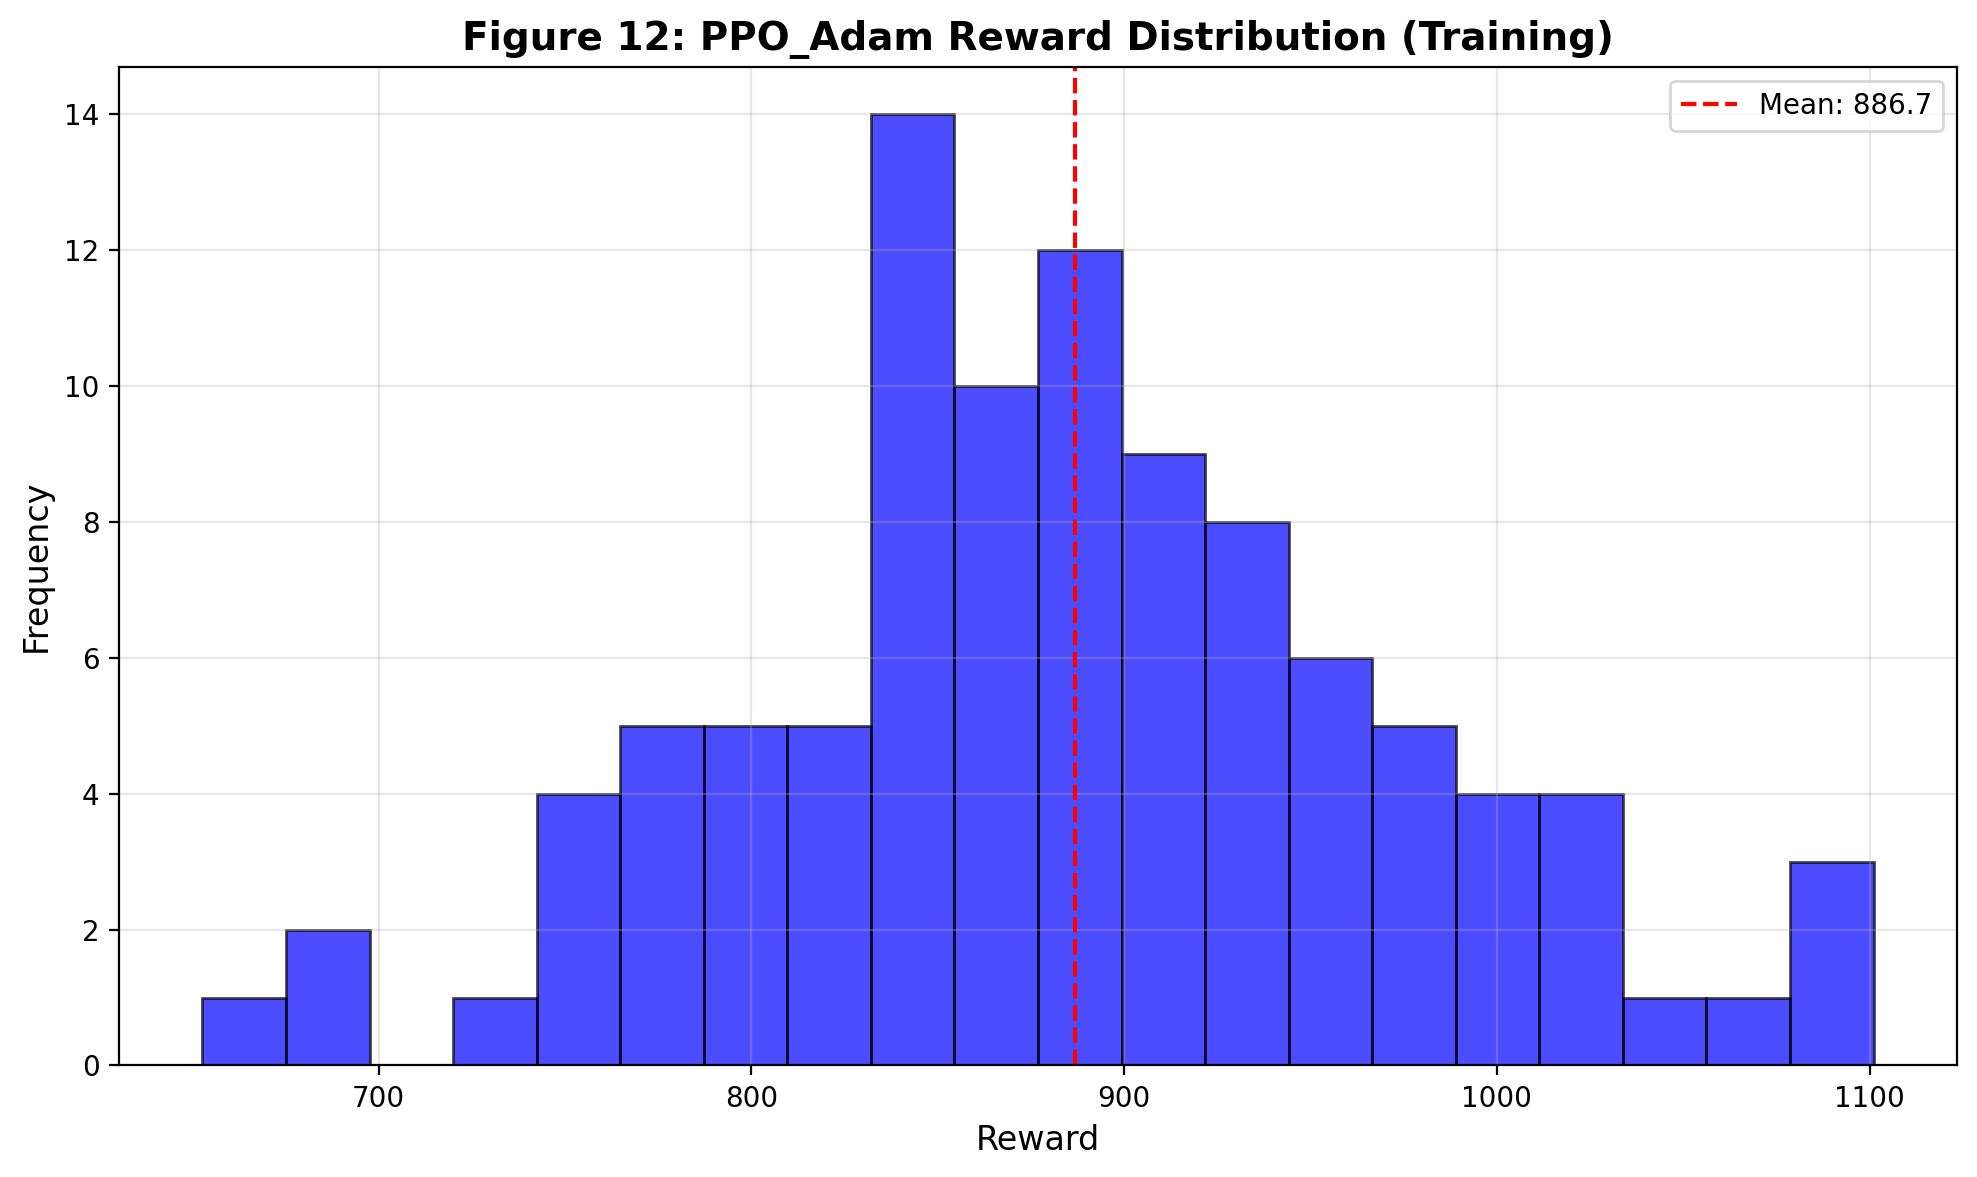

In [ ]:
"""Figure 12: Best RL Agent Reward Distribution"""
fig12, _ax = plt.subplots(figsize=(10, 6))

_rl_models = {k: v for k, v in experiment_results.items() 
              if k not in ['Fixed-Time', 'Max Pressure', 'MLP'] and 'episode_rewards' in v}
_best_agent = max(_rl_models.keys(), 
                 key=lambda k: all_eval_results[k]['mean_reward']) if _rl_models else None

_agent_data = _rl_models[_best_agent]
_rewards = _agent_data.get("episode_rewards", [])

_ax.hist(_rewards, bins=20, color='blue', alpha=0.7, edgecolor='black')
_ax.axvline(np.mean(_rewards), color='red', linestyle='--', label=f'Mean: {np.mean(_rewards):.1f}')

_ax.set_xlabel("Reward", fontsize=12)
_ax.set_ylabel("Frequency", fontsize=12)
_ax.set_title(f"Figure 12: {_best_agent} Reward Distribution (Training)", fontsize=14, fontweight='bold')
_ax.legend()
_ax.grid(True, alpha=0.3)

plt.tight_layout()
fig12

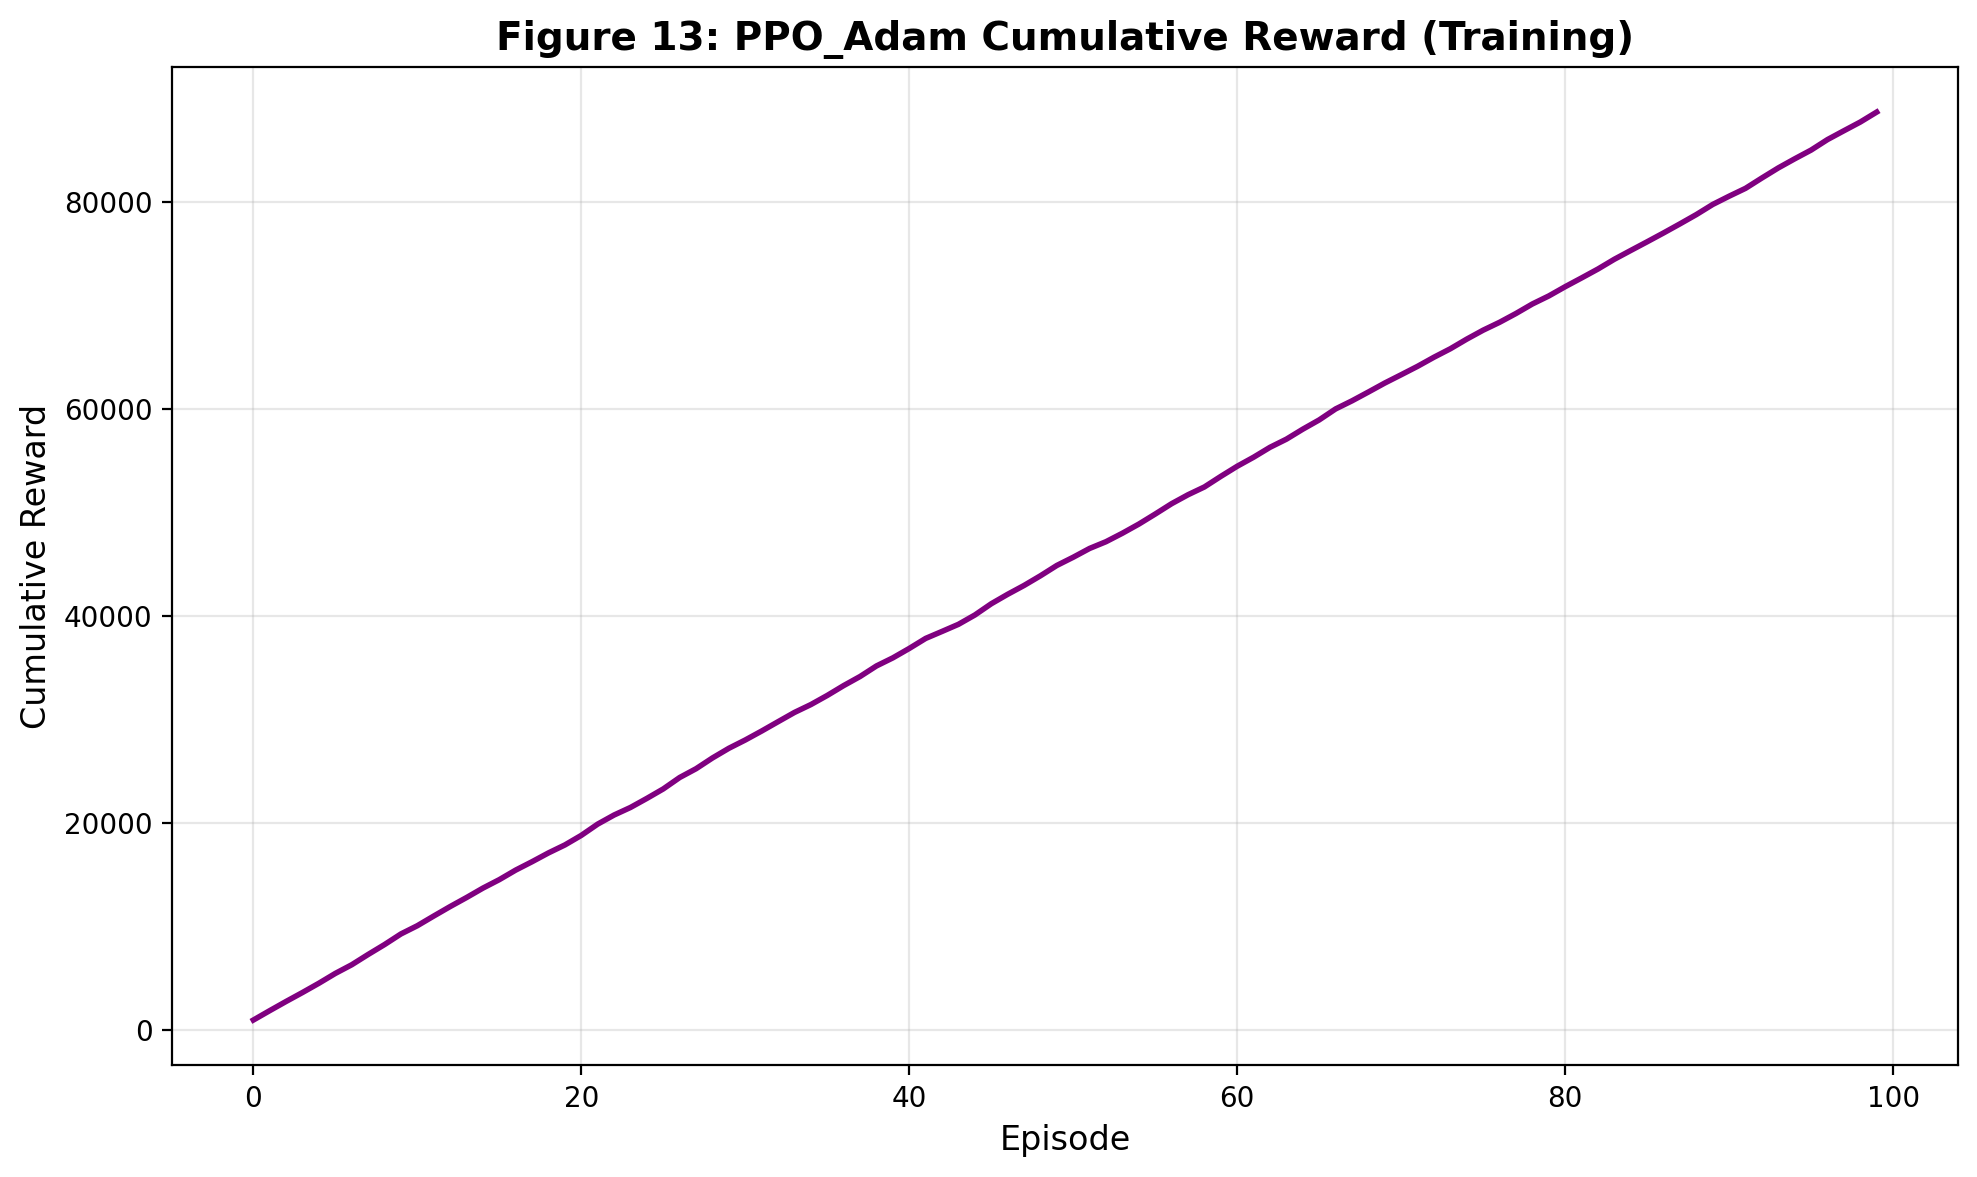

In [ ]:
"""Figure 13: Best RL Agent Cumulative Reward"""
fig13, _ax = plt.subplots(figsize=(10, 6))

_rl_models = {k: v for k, v in experiment_results.items() 
              if k not in ['Fixed-Time', 'Max Pressure', 'MLP'] and 'episode_rewards' in v}
_best_agent = max(_rl_models.keys(), 
                 key=lambda k: all_eval_results[k]['mean_reward']) if _rl_models else None

_agent_data = _rl_models[_best_agent]
_rewards = _agent_data.get("episode_rewards", [])
_cumulative = np.cumsum(_rewards)

_ax.plot(_cumulative, color='purple', linewidth=2)
_ax.set_xlabel("Episode", fontsize=12)
_ax.set_ylabel("Cumulative Reward", fontsize=12)
_ax.set_title(f"Figure 13: {_best_agent} Cumulative Reward (Training)", fontsize=14, fontweight='bold')
_ax.grid(True, alpha=0.3)

plt.tight_layout()
fig13

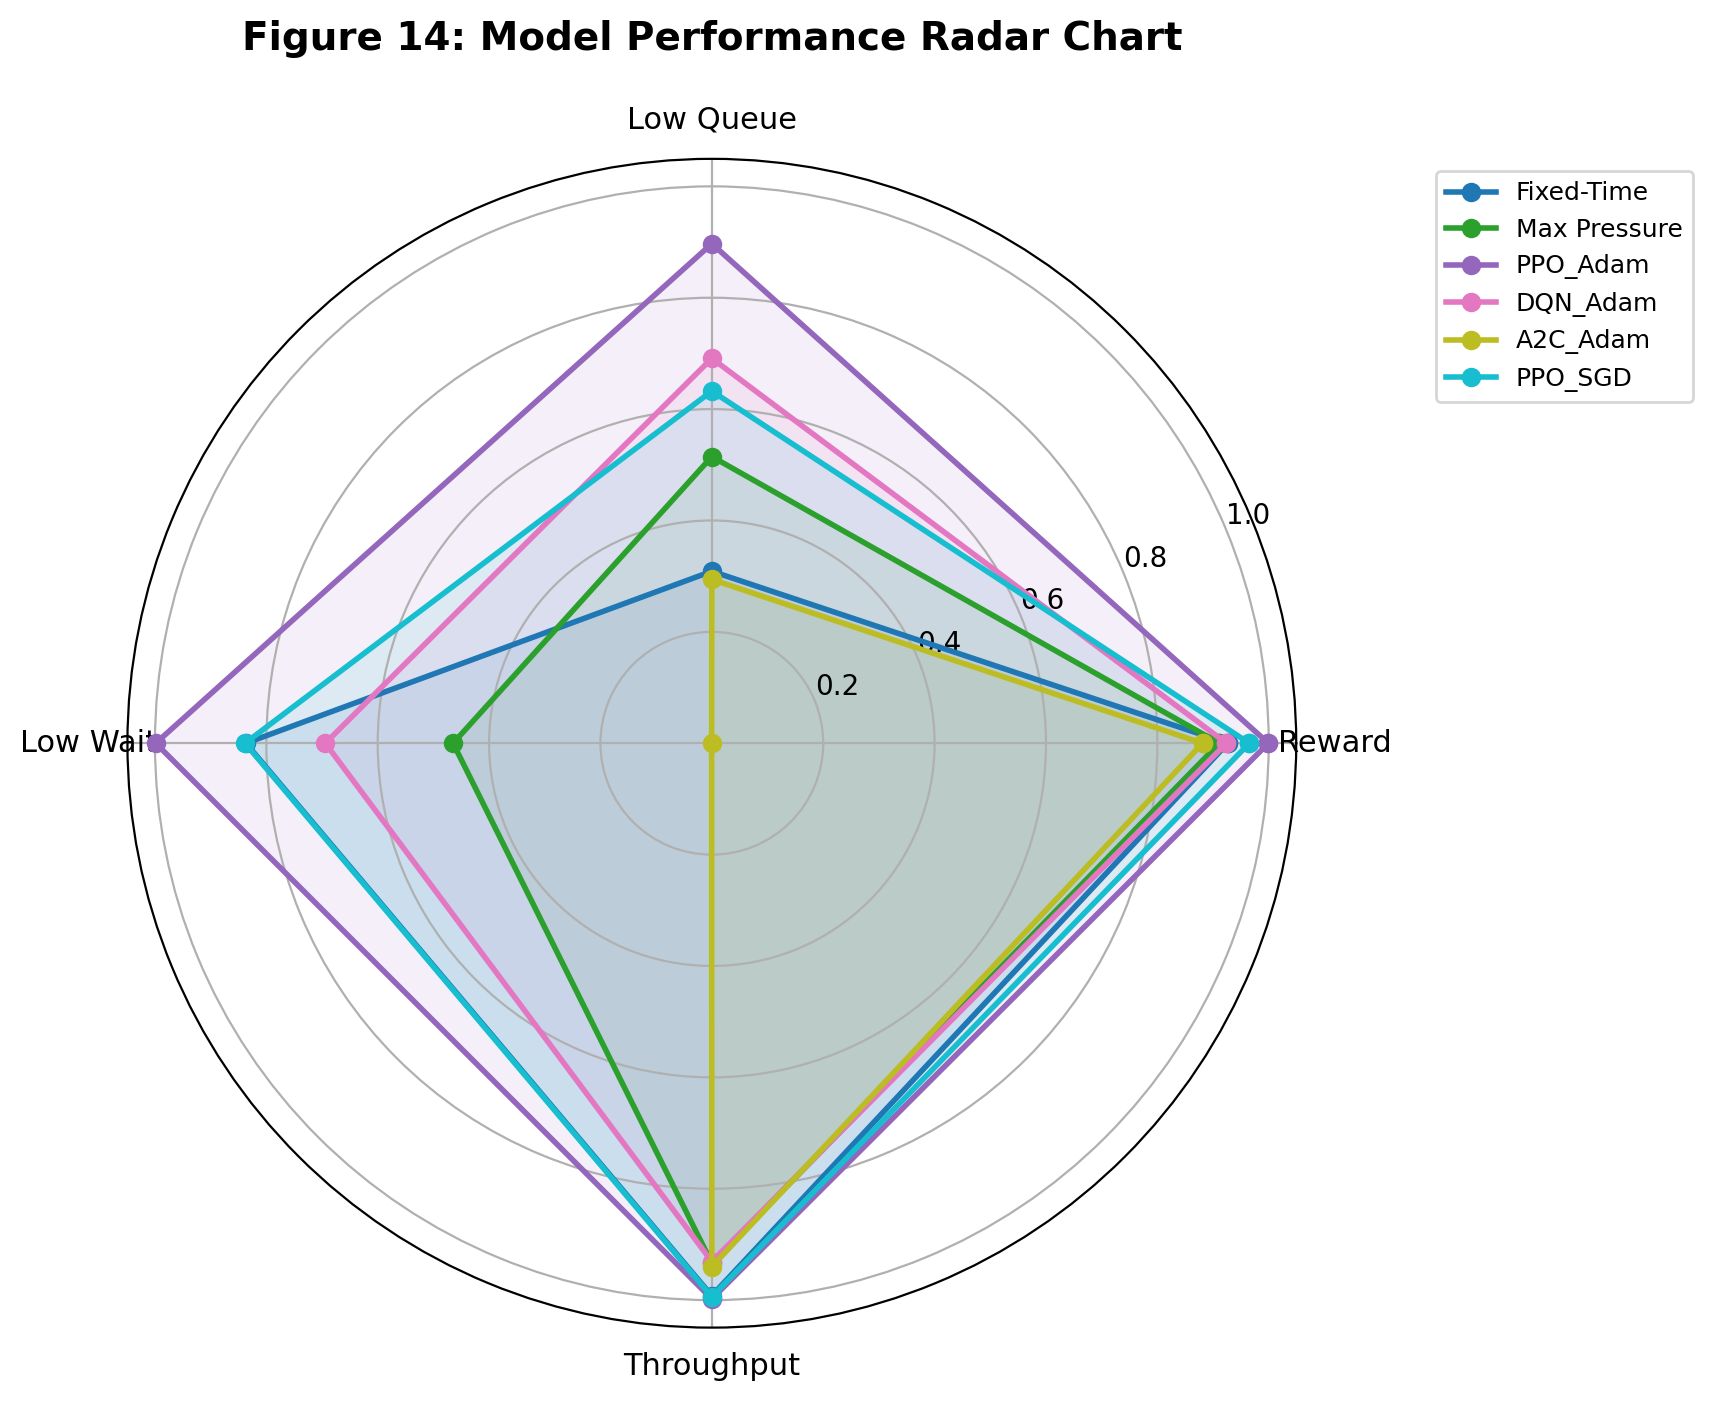

In [ ]:
"""Figure 14: Radar Chart - Model Performance Comparison"""
fig14, ax14 = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='polar'))

_rl_models = [k for k in all_eval_results.keys() if k not in ['Fixed-Time', 'Max Pressure', 'MLP']]
_baselines = ['Fixed-Time', 'Max Pressure']
_models = [m for m in (_baselines + _rl_models) if m in all_eval_results][:6]

# Metrics (normalized 0-1, higher is better for all)
_categories = ['Reward', 'Low Queue', 'Low Wait', 'Throughput']

_max_reward = max(abs(all_eval_results[m]["mean_reward"]) for m in _models) + 1
_max_queue = max(all_eval_results[m]["mean_queue_length"] for m in _models) + 1
_max_wait = max(all_eval_results[m]["mean_waiting_time"] for m in _models) + 1
_max_through = max(all_eval_results[m]["mean_throughput"] for m in _models) + 1

_angles = np.linspace(0, 2*np.pi, len(_categories), endpoint=False).tolist()
_angles += _angles[:1]  # Complete the circle

_colors = plt.cm.tab10(np.linspace(0, 1, len(_models)))

for _idx, _model in enumerate(_models):
    _res = all_eval_results[_model]
    _values = [
        (_res["mean_reward"] + _max_reward) / (2 * _max_reward),  # Normalize reward
        1 - _res["mean_queue_length"] / _max_queue,  # Invert (lower is better)
        1 - _res["mean_waiting_time"] / _max_wait,  # Invert
        _res["mean_throughput"] / _max_through
    ]
    _values += _values[:1]
    ax14.plot(_angles, _values, 'o-', linewidth=2, label=_model, color=_colors[_idx])
    ax14.fill(_angles, _values, alpha=0.1, color=_colors[_idx])

ax14.set_xticks(_angles[:-1])
ax14.set_xticklabels(_categories, fontsize=11)
ax14.set_title("Figure 14: Model Performance Radar Chart", fontsize=14, fontweight='bold', pad=20)
ax14.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0), fontsize=9)
plt.tight_layout()
fig14

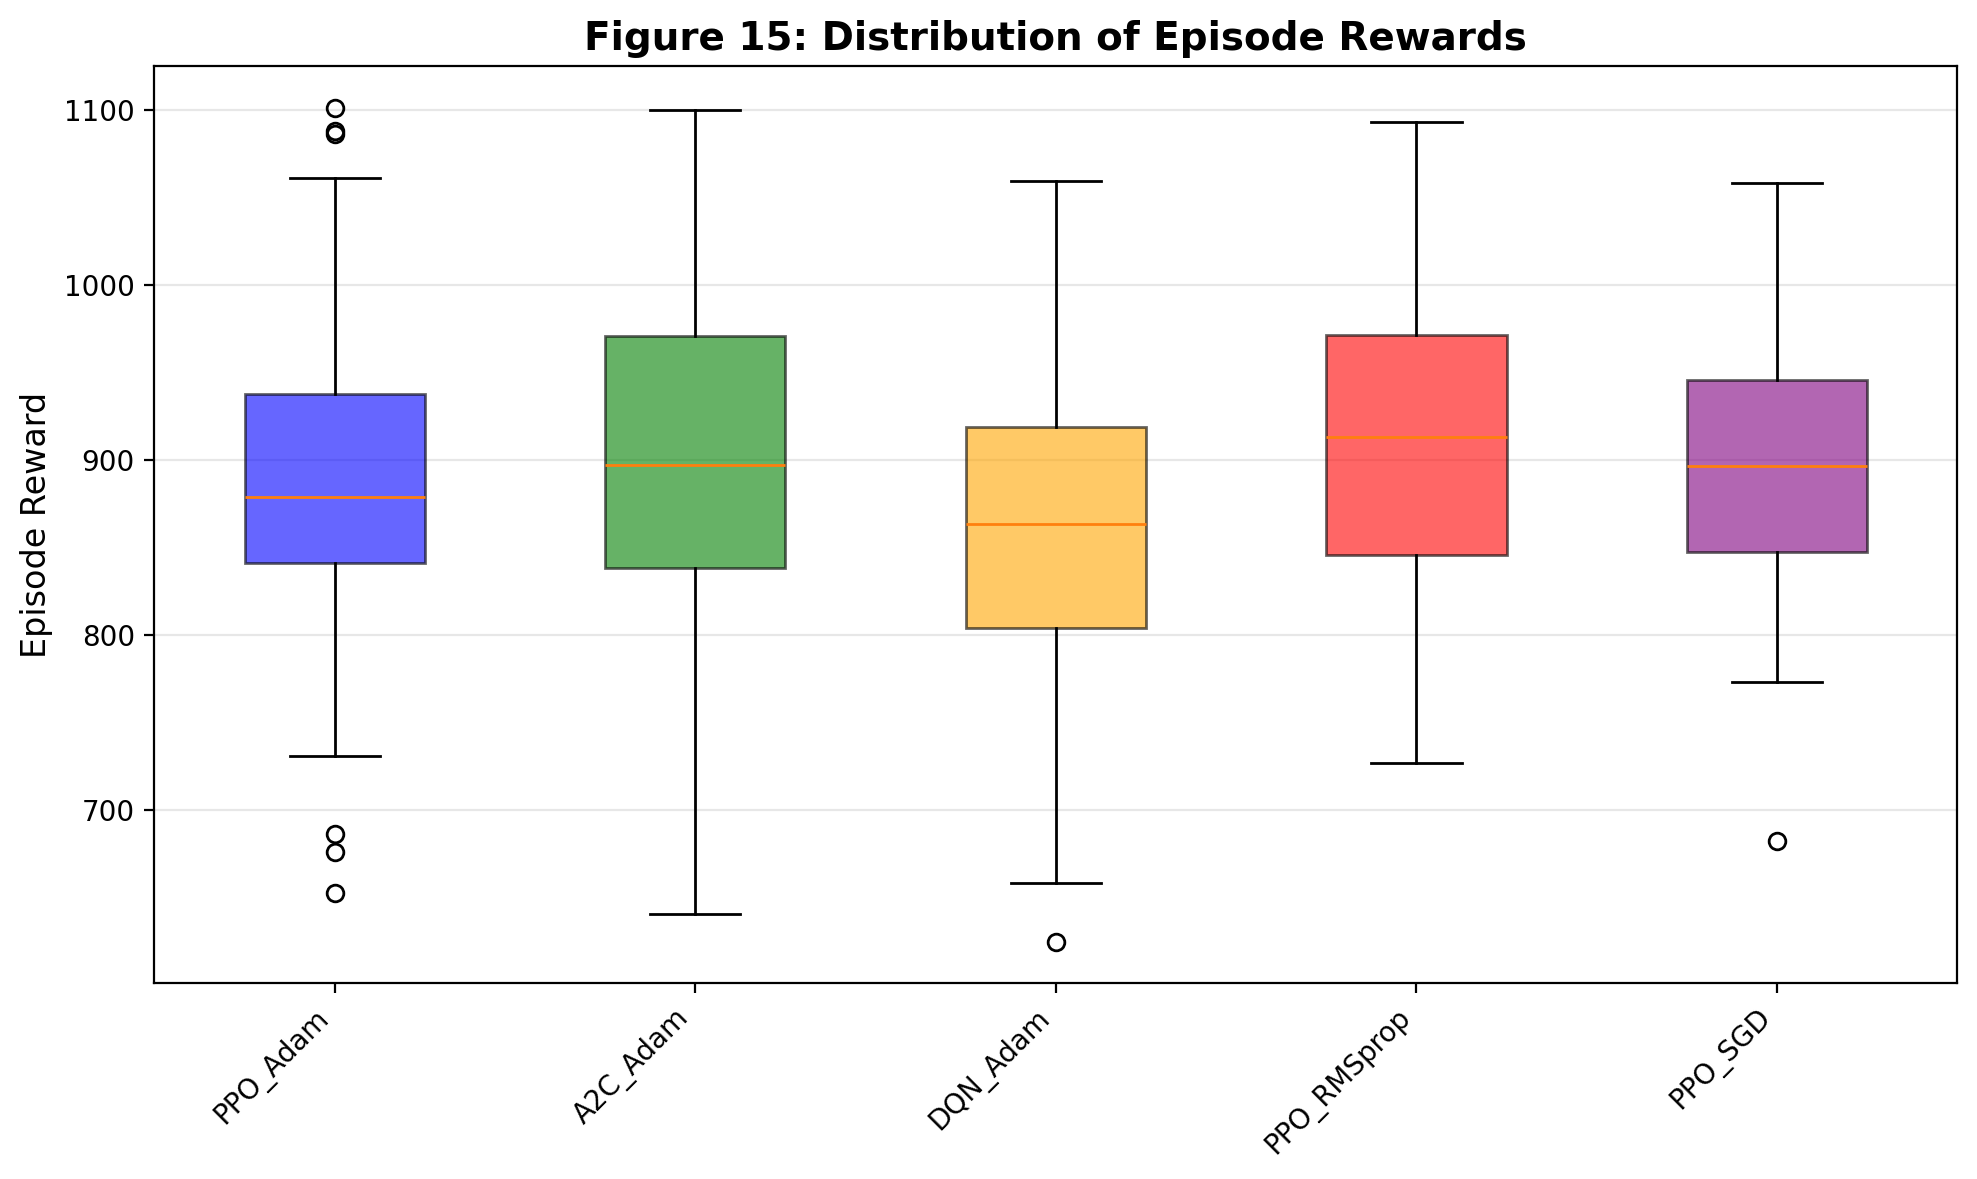

In [ ]:
"""Figure 15: Box Plot of Episode Rewards"""
fig15, ax15 = plt.subplots(figsize=(10, 6))

_data = []
_labels = []
for _name, _results in experiment_results.items():
    _data.append(_results["episode_rewards"])
    _labels.append(_name)

_bp = ax15.boxplot(_data, labels=_labels, patch_artist=True)

_colors = ['blue', 'green', 'orange', 'red', 'purple']
for _patch, _color in zip(_bp['boxes'], _colors[:len(_data)]):
    _patch.set_facecolor(_color)
    _patch.set_alpha(0.6)

ax15.set_ylabel("Episode Reward", fontsize=12)
ax15.set_title("Figure 15: Distribution of Episode Rewards", fontsize=14, fontweight='bold')
ax15.set_xticklabels(_labels, rotation=45, ha='right', fontsize=10)
ax15.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
fig15

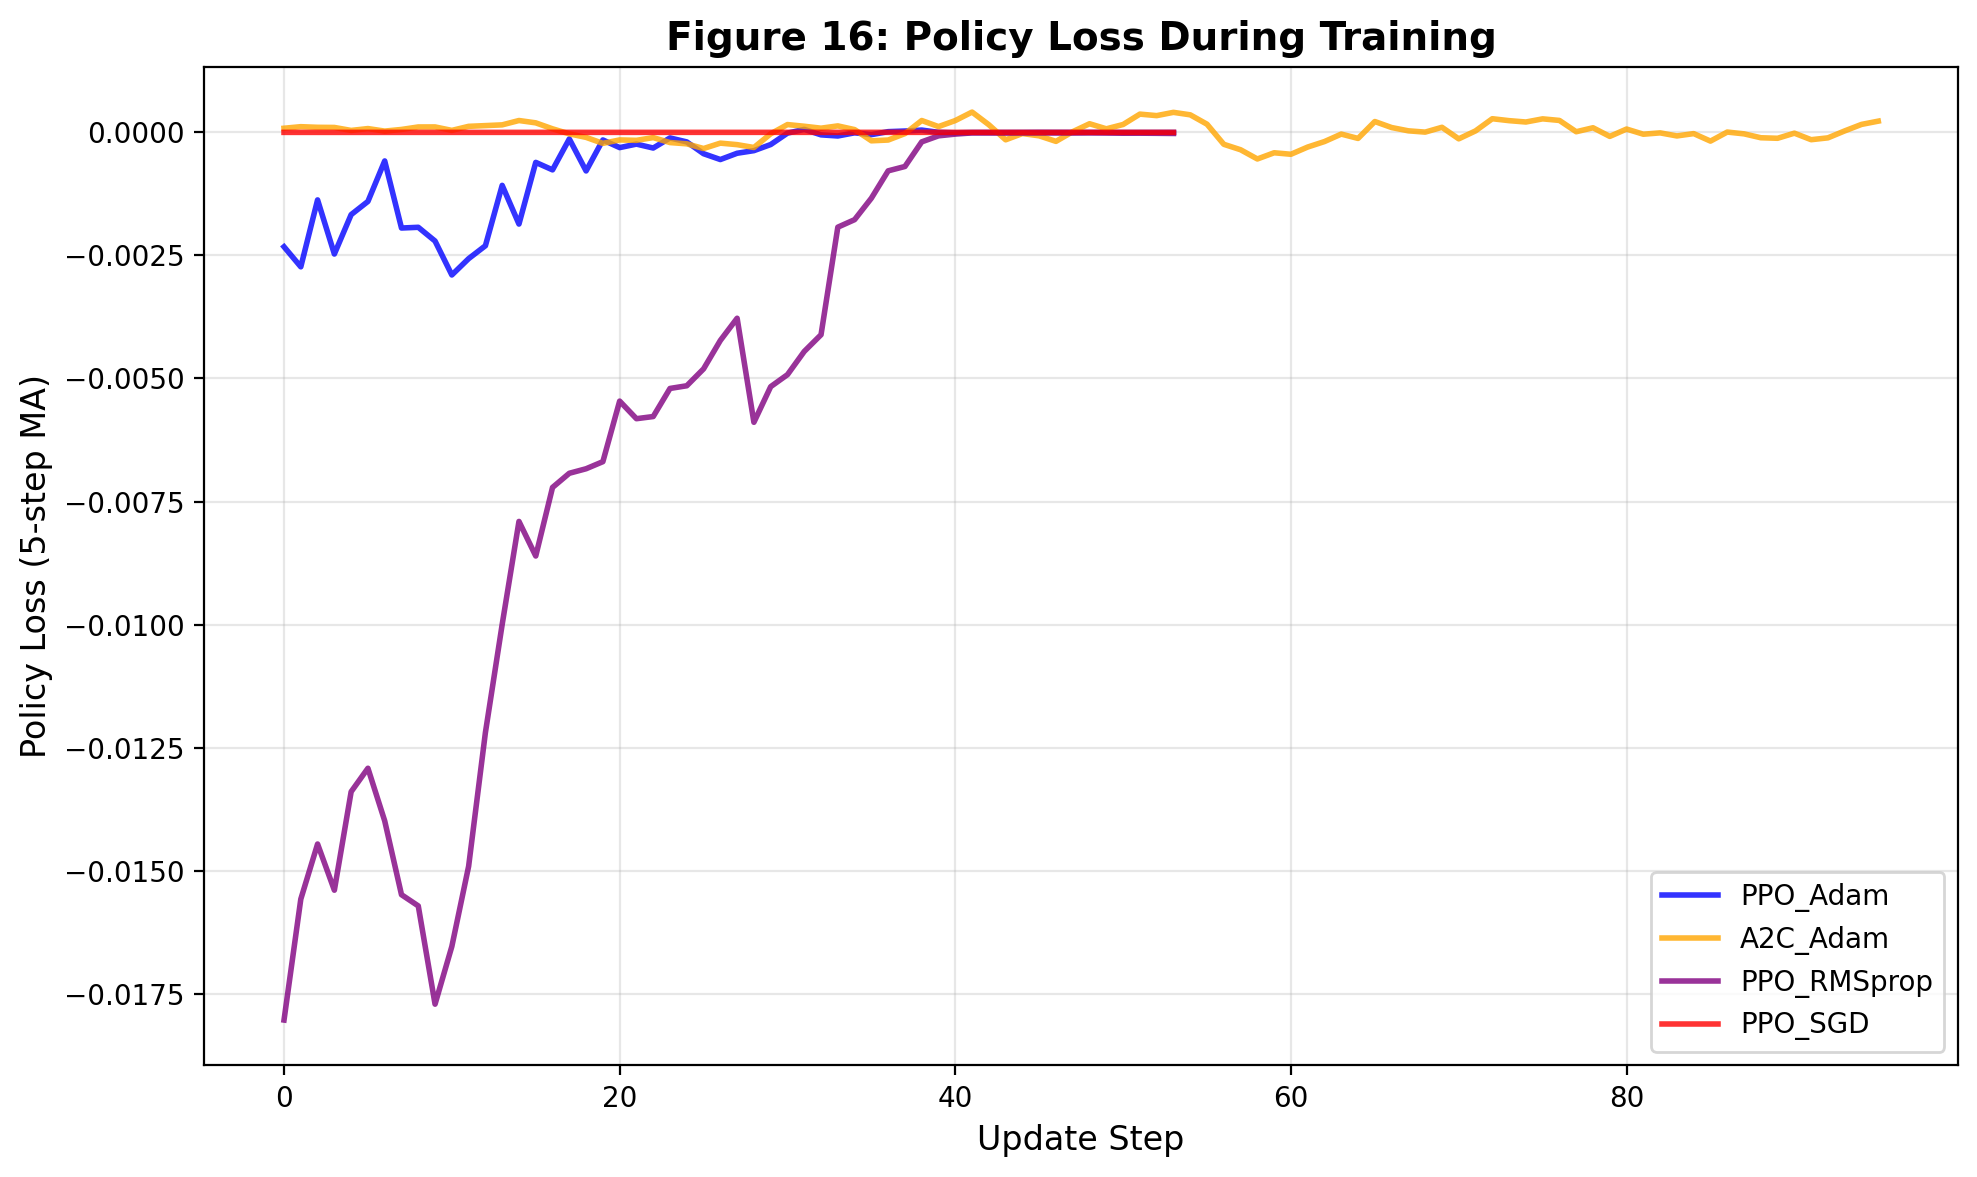

In [ ]:
"""Figure 16: Policy Loss Curves During Training"""
fig16, ax16 = plt.subplots(figsize=(10, 6))

_colors = {'PPO_Adam': 'blue', 'A2C_Adam': 'orange', 'PPO_SGD': 'red', 'PPO_RMSprop': 'purple'}

for _name, _results in experiment_results.items():
    _losses = _results.get("policy_losses", [])
    if len(_losses) > 0 and _name != 'DQN_Adam':  # DQN doesn't have policy loss
        if len(_losses) >= 5:
            _ma = np.convolve(_losses, np.ones(5) / 5, mode="valid")
            ax16.plot(_ma, label=_name, color=_colors.get(_name, 'gray'), 
                     linewidth=2, alpha=0.8)
        else:
            ax16.plot(_losses, label=_name, color=_colors.get(_name, 'gray'), 
                     linewidth=2, alpha=0.8)

ax16.set_xlabel("Update Step", fontsize=12)
ax16.set_ylabel("Policy Loss (5-step MA)", fontsize=12)
ax16.set_title("Figure 16: Policy Loss During Training", fontsize=14, fontweight='bold')
ax16.legend(fontsize=10)
ax16.grid(True, alpha=0.3)
plt.tight_layout()
fig16

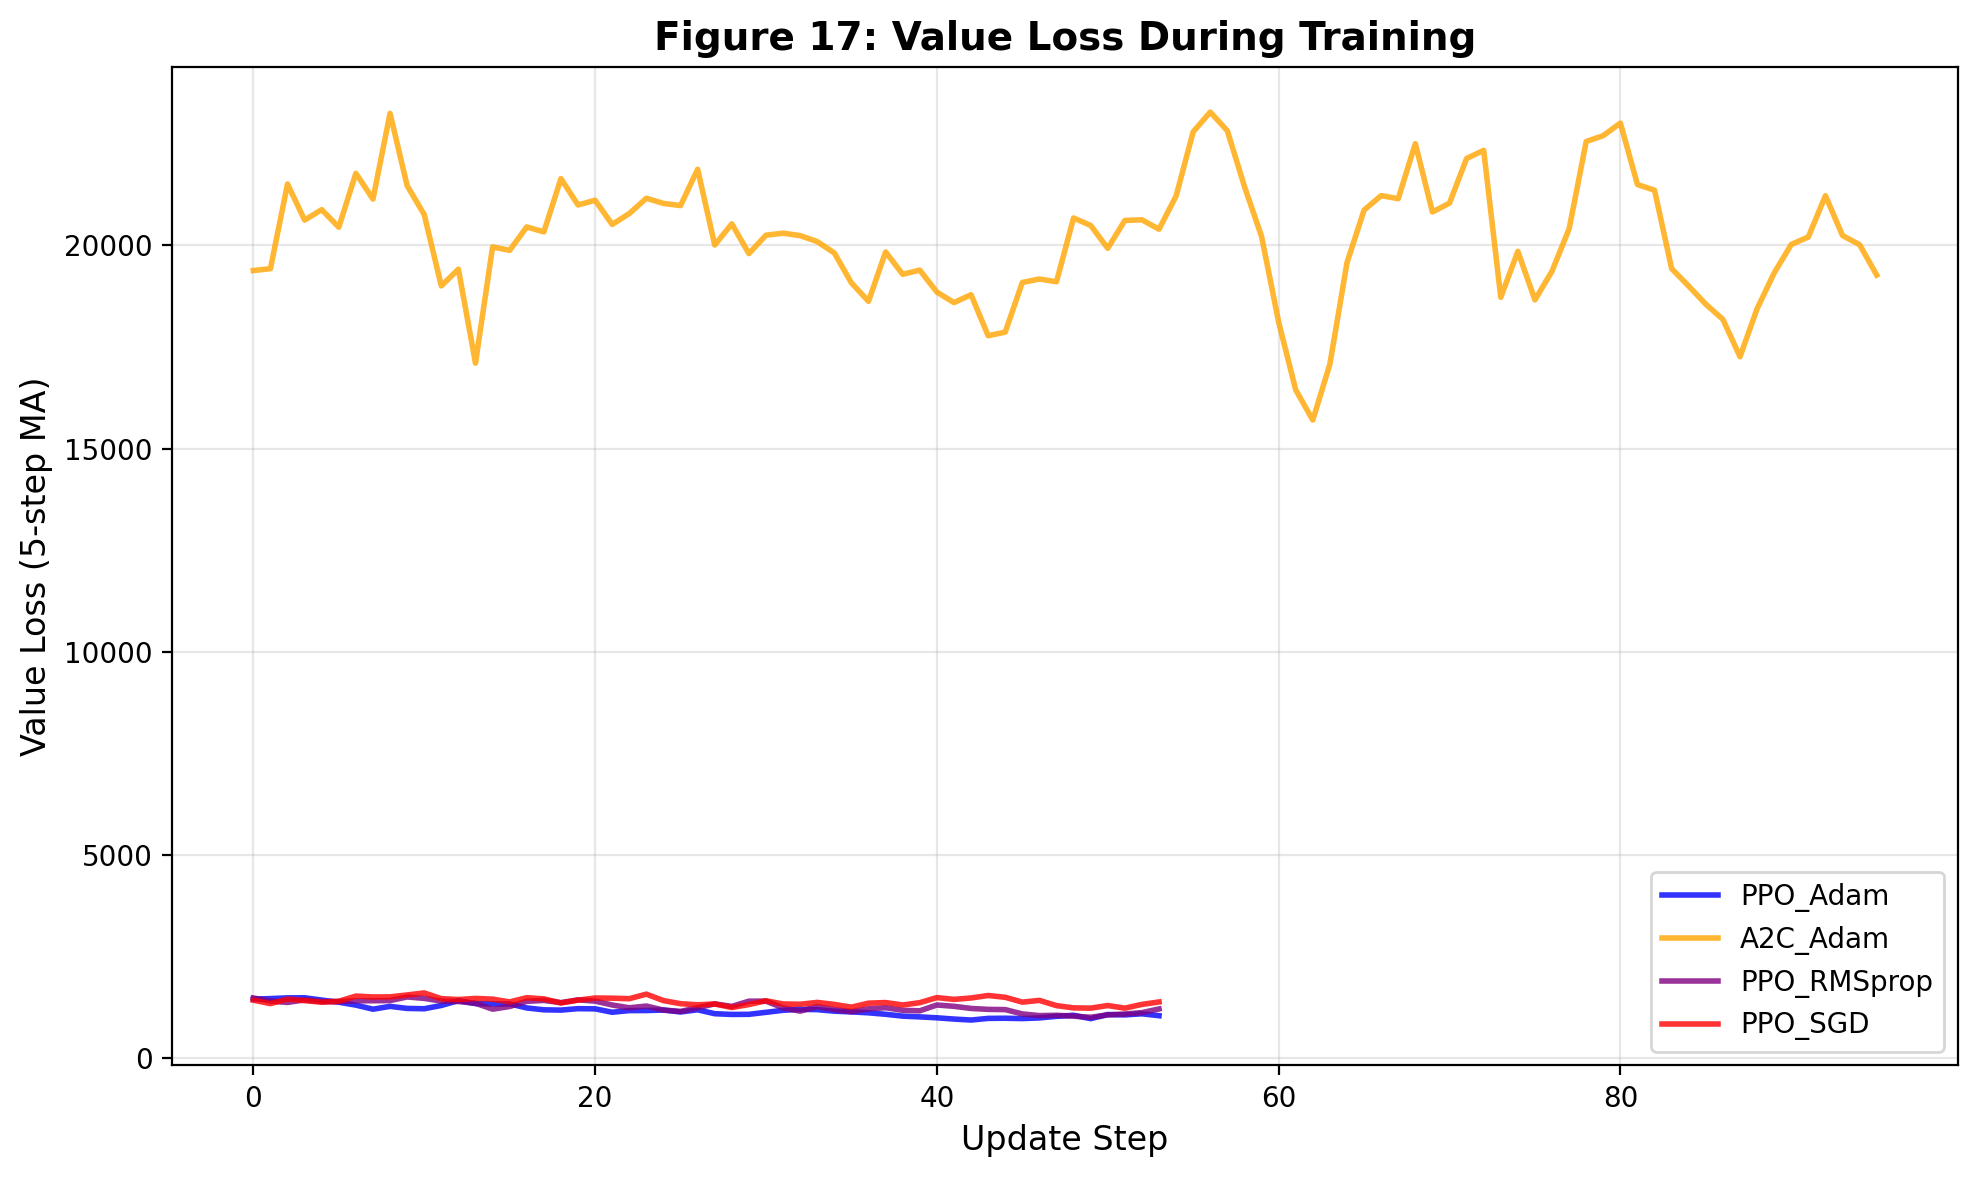

In [ ]:
"""Figure 17: Value Loss Curves During Training"""
fig17, ax17 = plt.subplots(figsize=(10, 6))

_colors = {'PPO_Adam': 'blue', 'A2C_Adam': 'orange', 'PPO_SGD': 'red', 'PPO_RMSprop': 'purple'}

for _name, _results in experiment_results.items():
    _losses = _results.get("value_losses", [])
    if len(_losses) > 0:
        if len(_losses) >= 5:
            _ma = np.convolve(_losses, np.ones(5) / 5, mode="valid")
            ax17.plot(_ma, label=_name, color=_colors.get(_name, 'gray'), 
                     linewidth=2, alpha=0.8)
        else:
            ax17.plot(_losses, label=_name, color=_colors.get(_name, 'gray'), 
                     linewidth=2, alpha=0.8)

ax17.set_xlabel("Update Step", fontsize=12)
ax17.set_ylabel("Value Loss (5-step MA)", fontsize=12)
ax17.set_title("Figure 17: Value Loss During Training", fontsize=14, fontweight='bold')
ax17.legend(fontsize=10)
ax17.grid(True, alpha=0.3)
plt.tight_layout()
fig17

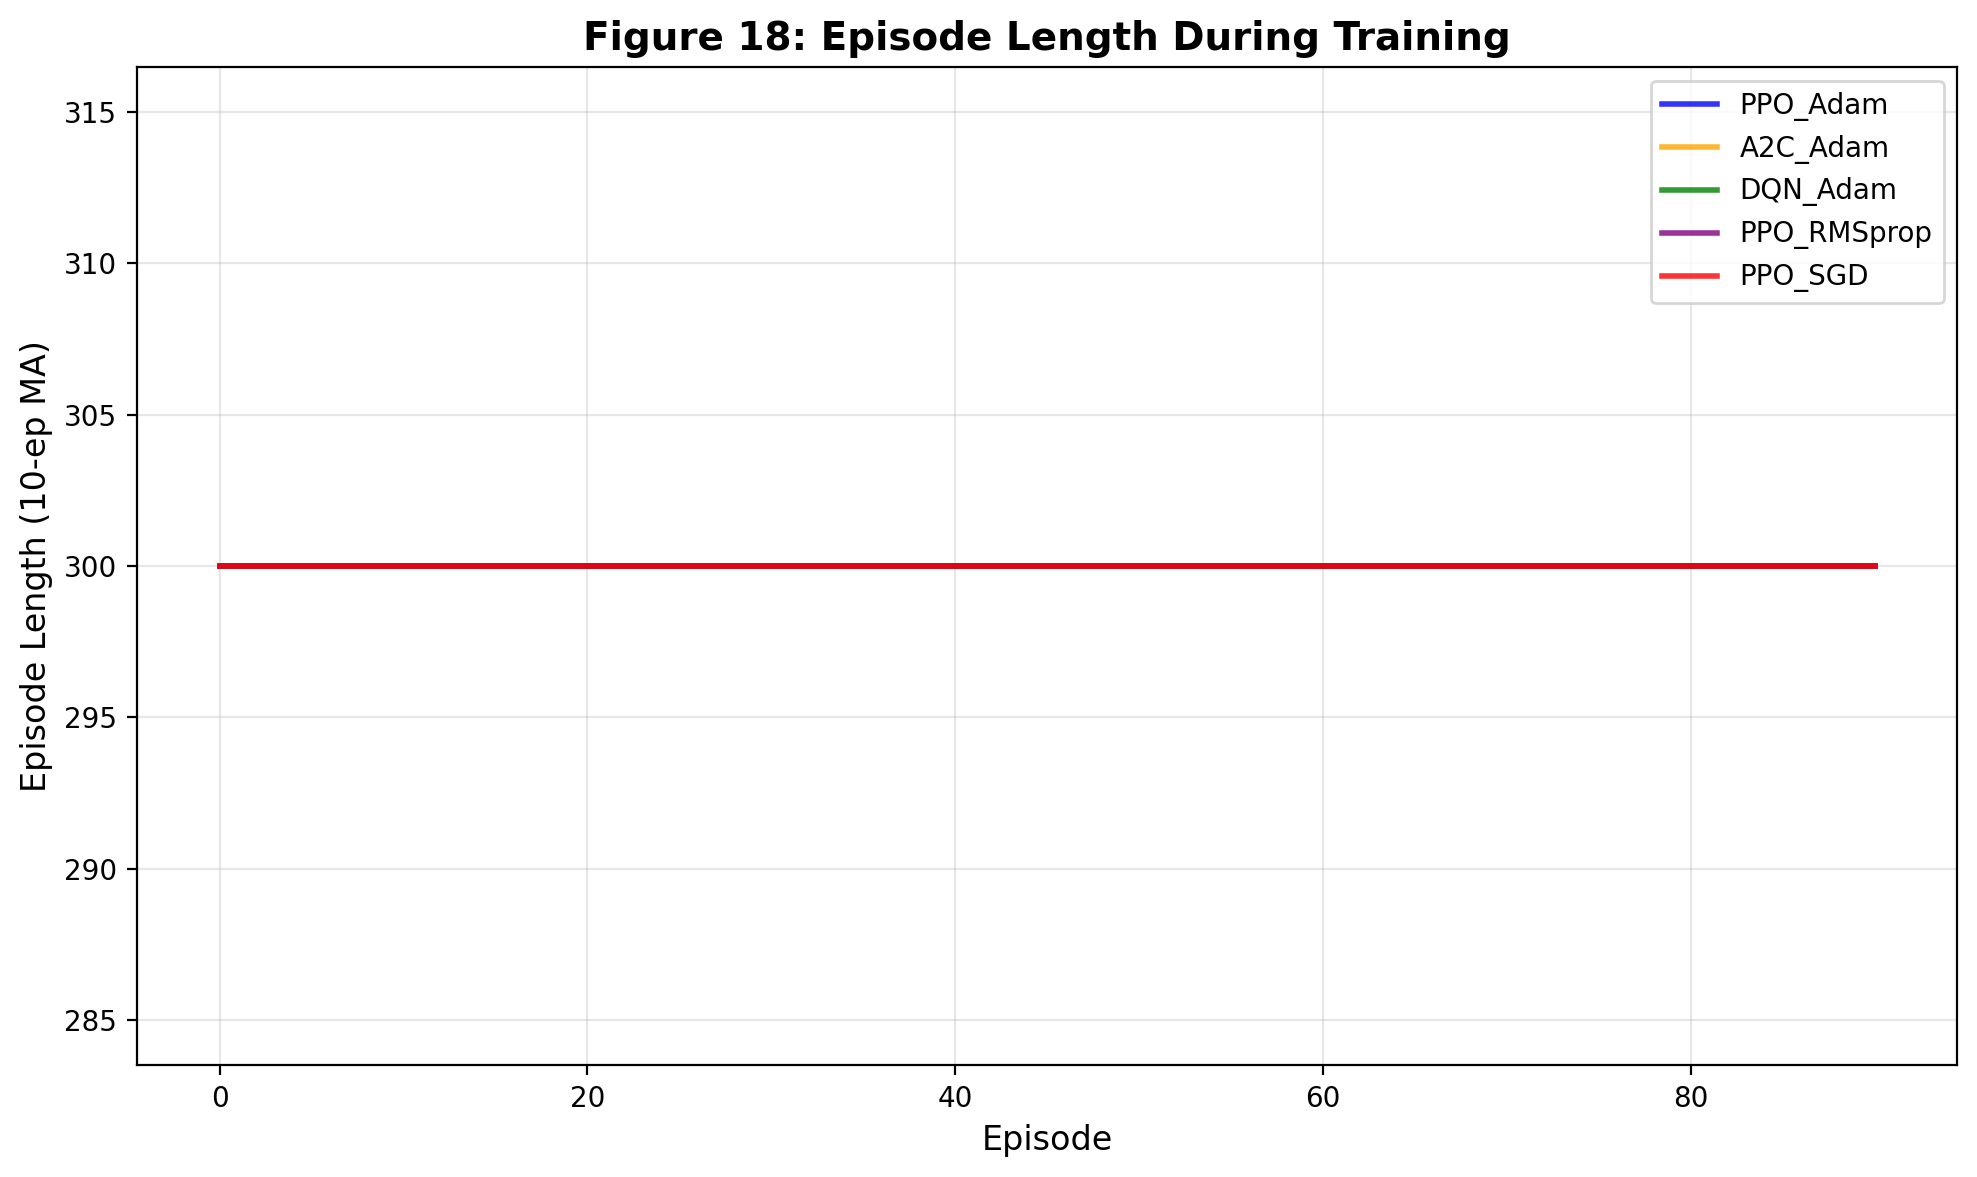

In [ ]:
"""Figure 18: Episode Length Over Training"""
fig18, ax18 = plt.subplots(figsize=(10, 6))

_colors = {'PPO_Adam': 'blue', 'DQN_Adam': 'green', 'A2C_Adam': 'orange',
          'PPO_SGD': 'red', 'PPO_RMSprop': 'purple'}

for _name, _results in experiment_results.items():
    _lengths = _results.get("episode_lengths", [])
    if len(_lengths) > 0:
        if len(_lengths) >= 10:
            _ma = np.convolve(_lengths, np.ones(10) / 10, mode="valid")
            ax18.plot(_ma, label=_name, color=_colors.get(_name, 'gray'), 
                     linewidth=2, alpha=0.8)
        else:
            ax18.plot(_lengths, label=_name, color=_colors.get(_name, 'gray'), 
                     linewidth=2, alpha=0.8)

ax18.set_xlabel("Episode", fontsize=12)
ax18.set_ylabel("Episode Length (10-ep MA)", fontsize=12)
ax18.set_title("Figure 18: Episode Length During Training", fontsize=14, fontweight='bold')
ax18.legend(fontsize=10)
ax18.grid(True, alpha=0.3)
plt.tight_layout()
fig18

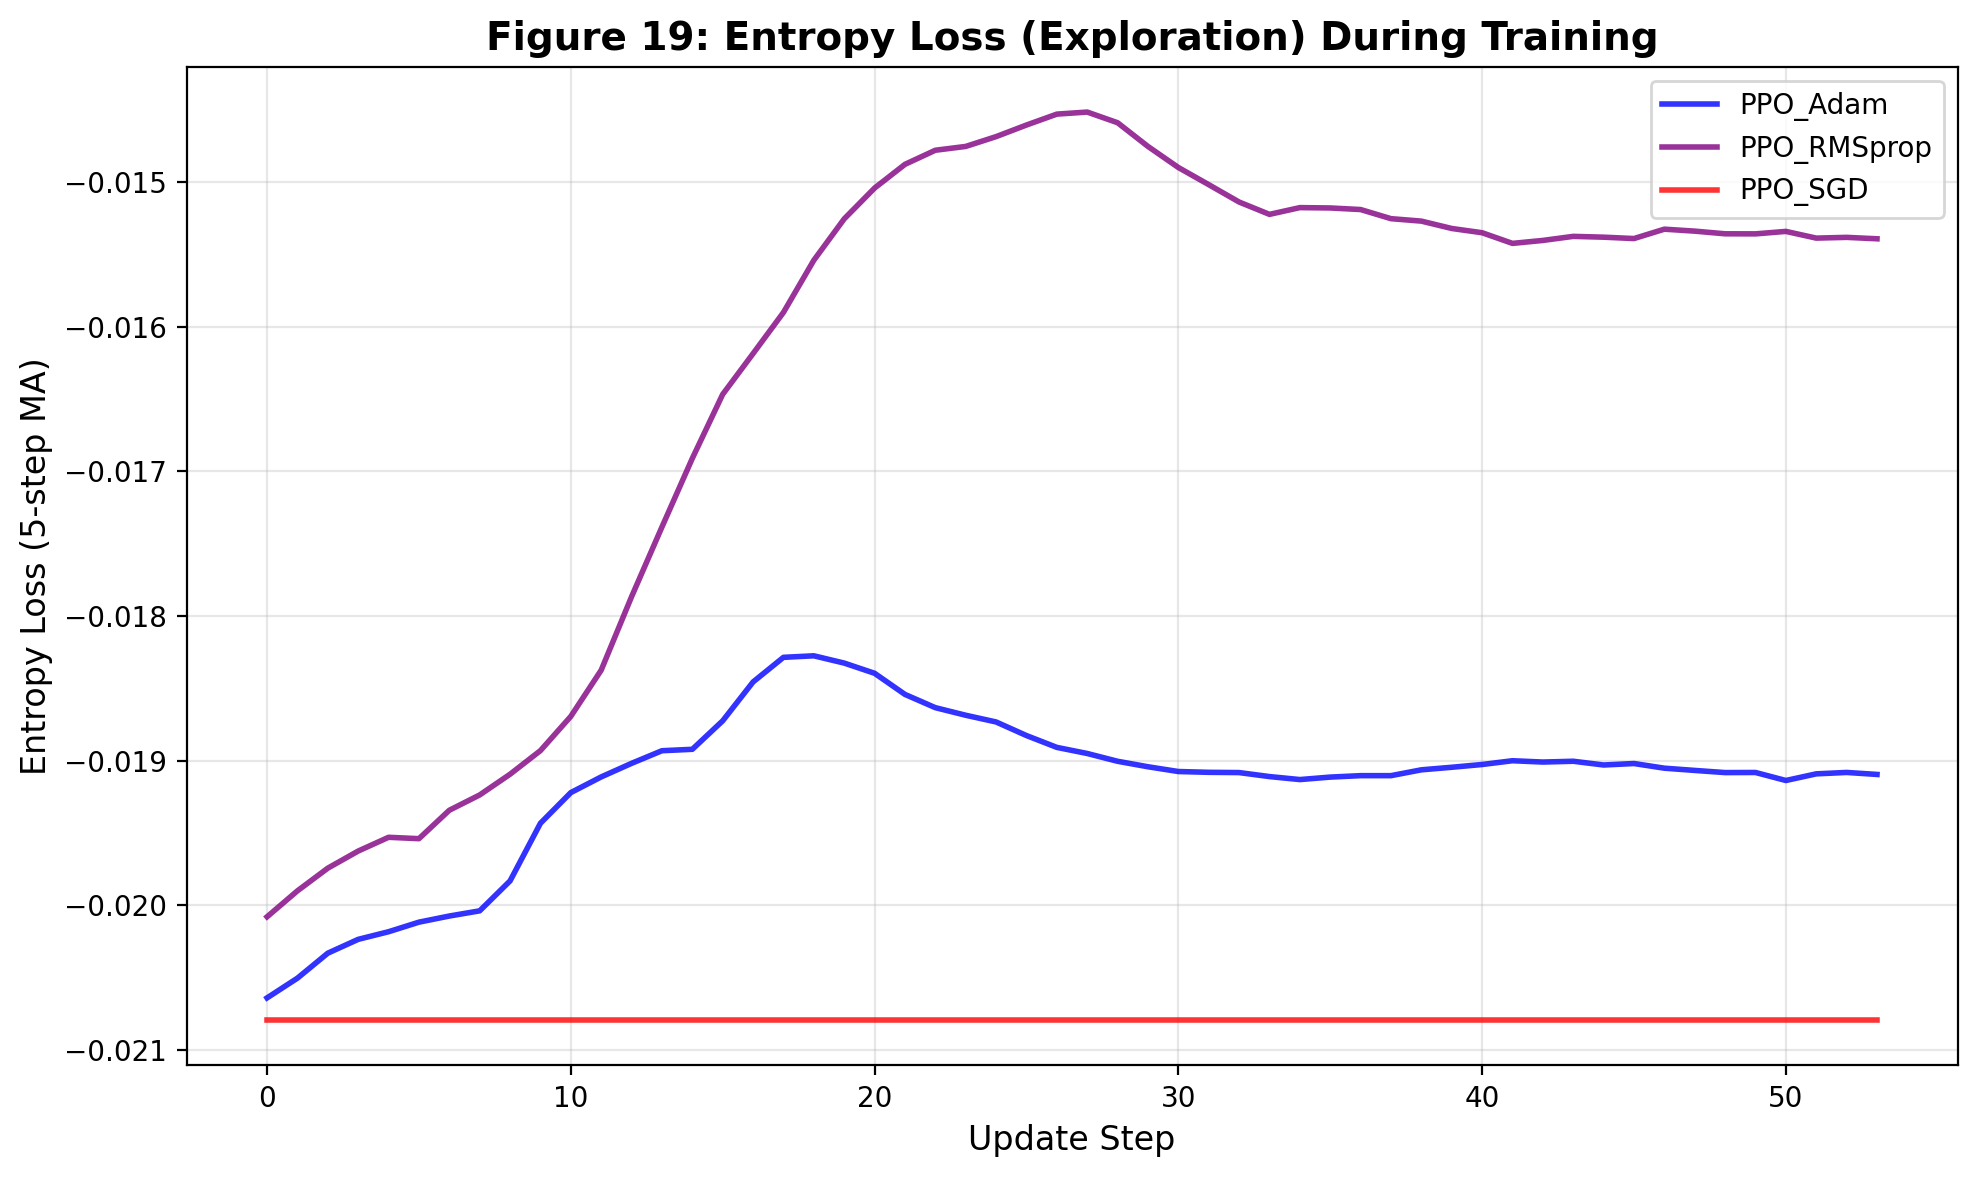

In [ ]:
"""Figure 19: Entropy Loss During Training"""
fig19, ax19 = plt.subplots(figsize=(10, 6))

_colors = {'PPO_Adam': 'blue', 'A2C_Adam': 'orange', 'PPO_SGD': 'red', 'PPO_RMSprop': 'purple'}

for _name, _results in experiment_results.items():
    _losses = _results.get("entropy_losses", [])
    if len(_losses) > 0:
        if len(_losses) >= 5:
            _ma = np.convolve(_losses, np.ones(5) / 5, mode="valid")
            ax19.plot(_ma, label=_name, color=_colors.get(_name, 'gray'), 
                     linewidth=2, alpha=0.8)
        else:
            ax19.plot(_losses, label=_name, color=_colors.get(_name, 'gray'), 
                     linewidth=2, alpha=0.8)

ax19.set_xlabel("Update Step", fontsize=12)
ax19.set_ylabel("Entropy Loss (5-step MA)", fontsize=12)
ax19.set_title("Figure 19: Entropy Loss (Exploration) During Training", fontsize=14, fontweight='bold')
ax19.legend(fontsize=10)
ax19.grid(True, alpha=0.3)
plt.tight_layout()
fig19

## 10. Results Tables

The following tables summarize the experimental results for the report.

In [ ]:
"""Table 1: Environment Configuration"""
table1 = f"""
### Table 1: Environment Configuration Parameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| Number of Lanes | {config.num_lanes} | Approach lanes per direction |
| Max Vehicles/Lane | {config.max_vehicles_per_lane} | Maximum queue capacity |
| Max Steps/Episode | {config.max_steps_per_episode} | Episode length |
| Green Duration | {config.green_duration}s | Default green phase |
| Yellow Duration | {config.yellow_duration}s | Yellow transition phase |
| Min Green | {config.min_green}s | Minimum green duration |
| Max Green | {config.max_green}s | Maximum green duration |
| State Dimension | {config.state_dim} | Input feature size |
| Action Dimension | {config.action_dim} | Number of phases |
"""
mo.md(table1)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-1-environment-configuration-parameters">Table 1: Environment Configuration Parameters</h3>
<table>
<thead>
<tr>
<th>Parameter</th>
<th>Value</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>Number of Lanes</td>
<td>4</td>
<td>Approach lanes per direction</td>
</tr>
<tr>
<td>Max Vehicles/Lane</td>
<td>20</td>
<td>Maximum queue capacity</td>
</tr>
<tr>
<td>Max Steps/Episode</td>
<td>300</td>
<td>Episode length</td>
</tr>
<tr>
<td>Green Duration</td>
<td>30s</td>
<td>Default green phase</td>
</tr>
<tr>
<td>Yellow Duration</td>
<td>5s</td>
<td>Yellow transition phase</td>
</tr>
<tr>
<td>Min Green</td>
<td>10s</td>
<td>Minimum green duration</td>
</tr>
<tr>
<td>Max Green</td>
<td>60s</td>
<td>Maximum green duration</td>
</tr>
<tr>
<td>State Dimension</td>
<td>12</td>
<td>Input feature size</td>
</tr>
<tr>
<td>Action Dimension</td>
<td>4</td>
<td>Number of phases</td>
</tr>
</tbody>
</table></span>

In [ ]:
"""Table 2: PPO Hyperparameters"""
table2 = f"""
### Table 2: PPO Hyperparameters

| Hyperparameter | Value | Description |
|----------------|-------|-------------|
| Discount Factor (γ) | {config.gamma} | Future reward discounting |
| GAE Lambda (λ) | {config.gae_lambda} | Advantage estimation |
| Clip Epsilon (ε) | {config.clip_epsilon} | PPO clipping range |
| Entropy Coefficient | {config.entropy_coef} | Exploration bonus |
| Value Coefficient | {config.value_coef} | Value loss weight |
| Max Grad Norm | {config.max_grad_norm} | Gradient clipping |
| Learning Rate | {config.learning_rate} | Optimizer step size |
| Batch Size | {config.batch_size} | Mini-batch size |
| N Epochs | {config.n_epochs} | PPO update epochs |
| Update Interval | {config.update_interval} | Steps between updates |
"""
mo.md(table2)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-2-ppo-hyperparameters">Table 2: PPO Hyperparameters</h3>
<table>
<thead>
<tr>
<th>Hyperparameter</th>
<th>Value</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>Discount Factor (γ)</td>
<td>0.98</td>
<td>Future reward discounting</td>
</tr>
<tr>
<td>GAE Lambda (λ)</td>
<td>0.97</td>
<td>Advantage estimation</td>
</tr>
<tr>
<td>Clip Epsilon (ε)</td>
<td>0.25</td>
<td>PPO clipping range</td>
</tr>
<tr>
<td>Entropy Coefficient</td>
<td>0.015</td>
<td>Exploration bonus</td>
</tr>
<tr>
<td>Value Coefficient</td>
<td>0.8</td>
<td>Value loss weight</td>
</tr>
<tr>
<td>Max Grad Norm</td>
<td>1.0</td>
<td>Gradient clipping</td>
</tr>
<tr>
<td>Learning Rate</td>
<td>0.0003</td>
<td>Optimizer step size</td>
</tr>
<tr>
<td>Batch Size</td>
<td>512</td>
<td>Mini-batch size</td>
</tr>
<tr>
<td>N Epochs</td>
<td>15</td>
<td>PPO update epochs</td>
</tr>
<tr>
<td>Update Interval</td>
<td>1024</td>
<td>Steps between updates</td>
</tr>
</tbody>
</table></span>

In [ ]:
"""Table 3: DQN Hyperparameters"""
table3 = f"""
### Table 3: DQN Hyperparameters

| Hyperparameter | Value | Description |
|----------------|-------|-------------|
| Buffer Size | {config.buffer_size} | Replay buffer capacity |
| Batch Size | {config.batch_size_dqn} | Training batch size |
| Epsilon Start | {config.epsilon_start} | Initial exploration rate |
| Epsilon End | {config.epsilon_end} | Final exploration rate |
| Epsilon Decay | {config.epsilon_decay} | Decay rate |
| Target Update Freq | {config.target_update_freq} | Target network update |
| Learning Rate | {config.learning_rate} | Optimizer step size |
| Discount Factor (γ) | {config.gamma} | Future reward discounting |
"""
mo.md(table3)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-3-dqn-hyperparameters">Table 3: DQN Hyperparameters</h3>
<table>
<thead>
<tr>
<th>Hyperparameter</th>
<th>Value</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>Buffer Size</td>
<td>10000</td>
<td>Replay buffer capacity</td>
</tr>
<tr>
<td>Batch Size</td>
<td>64</td>
<td>Training batch size</td>
</tr>
<tr>
<td>Epsilon Start</td>
<td>1.0</td>
<td>Initial exploration rate</td>
</tr>
<tr>
<td>Epsilon End</td>
<td>0.01</td>
<td>Final exploration rate</td>
</tr>
<tr>
<td>Epsilon Decay</td>
<td>0.99</td>
<td>Decay rate</td>
</tr>
<tr>
<td>Target Update Freq</td>
<td>100</td>
<td>Target network update</td>
</tr>
<tr>
<td>Learning Rate</td>
<td>0.0003</td>
<td>Optimizer step size</td>
</tr>
<tr>
<td>Discount Factor (γ)</td>
<td>0.98</td>
<td>Future reward discounting</td>
</tr>
</tbody>
</table></span>

In [ ]:
"""Table 4: Training Configuration"""
table4 = f"""
### Table 4: Training Configuration

| Parameter | Value |
|-----------|-------|
| Training Episodes | {config.num_episodes} |
| Evaluation Interval | {config.eval_interval} episodes |
| Random Seed | 42 |
| MLP Hidden Dim | {config.mlp_hidden_dim} |
| MLP Epochs | {config.mlp_epochs} |
| MLP Learning Rate | {config.mlp_lr} |
"""
mo.md(table4)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-4-training-configuration">Table 4: Training Configuration</h3>
<table>
<thead>
<tr>
<th>Parameter</th>
<th>Value</th>
</tr>
</thead>
<tbody>
<tr>
<td>Training Episodes</td>
<td>100</td>
</tr>
<tr>
<td>Evaluation Interval</td>
<td>10 episodes</td>
</tr>
<tr>
<td>Random Seed</td>
<td>42</td>
</tr>
<tr>
<td>MLP Hidden Dim</td>
<td>128</td>
</tr>
<tr>
<td>MLP Epochs</td>
<td>50</td>
</tr>
<tr>
<td>MLP Learning Rate</td>
<td>0.001</td>
</tr>
</tbody>
</table></span>

In [ ]:
"""Table 5: Overall Performance Comparison"""
_rows = []
for _name, _res in all_eval_results.items():
    _rows.append(
        f"| {_name} | {_res['mean_reward']:.2f} | {_res['std_reward']:.2f} | "
        f"{_res['mean_queue_length']:.2f} | {_res['mean_waiting_time']:.2f} | "
        f"{_res['mean_throughput']:.0f} |"
    )

_table5 = f"""
### Table 5: Overall Performance Comparison

| Method | Mean Reward | Std Dev | Avg Queue | Avg Wait (s) | Throughput |
|--------|-------------|---------|-----------|--------------|------------|
{chr(10).join(_rows)}
"""
mo.md(_table5)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-5-overall-performance-comparison">Table 5: Overall Performance Comparison</h3>
<table>
<thead>
<tr>
<th>Method</th>
<th>Mean Reward</th>
<th>Std Dev</th>
<th>Avg Queue</th>
<th>Avg Wait (s)</th>
<th>Throughput</th>
</tr>
</thead>
<tbody>
<tr>
<td>Fixed-Time</td>
<td>783.45</td>
<td>62.14</td>
<td>2.35</td>
<td>426.20</td>
<td>476</td>
</tr>
<tr>
<td>Max Pressure</td>
<td>755.78</td>
<td>79.94</td>
<td>1.65</td>
<td>1396.70</td>
<td>448</td>
</tr>
<tr>
<td>MLP</td>
<td>867.39</td>
<td>69.63</td>
<td>1.15</td>
<td>874.10</td>
<td>494</td>
</tr>
<tr>
<td>PPO_Adam</td>
<td>917.55</td>
<td>53.81</td>
<td>0.35</td>
<td>3.50</td>
<td>479</td>
</tr>
<tr>
<td>DQN_Adam</td>
<td>779.24</td>
<td>32.82</td>
<td>1.05</td>
<td>798.00</td>
<td>447</td>
</tr>
<tr>
<td>A2C_Adam</td>
<td>700.25</td>
<td>82.16</td>
<td>2.40</td>
<td>2607.80</td>
<td>451</td>
</tr>
<tr>
<td>PPO_SGD</td>
<td>854.58</td>
<td>65.22</td>
<td>1.25</td>
<td>421.85</td>
<td>477</td>
</tr>
<tr>
<td>PPO_RMSprop</td>
<td>765.83</td>
<td>115.01</td>
<td>0.95</td>
<td>743.15</td>
<td>454</td>
</tr>
</tbody>
</table></span>

In [ ]:
"""Table 6: Best RL Agent Improvement Over Baselines"""
_rl_agents = {k: v for k, v in all_eval_results.items() 
              if k not in ["Fixed-Time", "Max Pressure", "MLP"]}
_baselines = {k: v for k, v in all_eval_results.items() if k in ["Fixed-Time", "Max Pressure", "MLP"]}

_best_rl_name = max(_rl_agents.keys(), key=lambda k: _rl_agents[k].get('mean_reward', 0)) if _rl_agents else "N/A"
_best_rl = _rl_agents.get(_best_rl_name, {})

def _calc_improvement(_rl_val, _base_val):
    if _base_val == 0:
        return 0
    return ((_rl_val - _base_val) / abs(_base_val)) * 100

_rows = []
for _name, _base in _baselines.items():
    _base_reward = _base.get('mean_reward', 0)
    _rl_reward = _best_rl.get('mean_reward', 0)
    _improvement = _calc_improvement(_rl_reward, _base_reward if _base_reward != 0 else 1)
    _rows.append(f"| {_name} | {_base_reward:.2f} | {_rl_reward:.2f} | {_improvement:+.1f}% |")

_table6 = f"""
### Table 6: Best RL Agent ({_best_rl_name}) Improvement Over Baselines

| Baseline | Baseline Reward | {_best_rl_name} Reward | Improvement (%) |
|----------|-----------------|----------------------|-----------------|
{chr(10).join(_rows)}
"""
mo.md(_table6)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-6-best-rl-agent-ppo_adam-improvement-over-baselines">Table 6: Best RL Agent (PPO_Adam) Improvement Over Baselines</h3>
<table>
<thead>
<tr>
<th>Baseline</th>
<th>Baseline Reward</th>
<th>PPO_Adam Reward</th>
<th>Improvement (%)</th>
</tr>
</thead>
<tbody>
<tr>
<td>Fixed-Time</td>
<td>783.45</td>
<td>917.55</td>
<td>+17.1%</td>
</tr>
<tr>
<td>Max Pressure</td>
<td>755.78</td>
<td>917.55</td>
<td>+21.4%</td>
</tr>
<tr>
<td>MLP</td>
<td>867.39</td>
<td>917.55</td>
<td>+5.8%</td>
</tr>
</tbody>
</table></span>

In [ ]:
"""Table 7: RL Algorithm Comparison"""

_rl_agents = {k: v for k, v in all_eval_results.items() 
              if k not in ["Fixed-Time", "Max Pressure", "MLP"]}

def _get_best_agent(_metric, _higher_is_better=True):
    _vals = {k: v.get(_metric, 0) for k, v in _rl_agents.items() if v.get(_metric) is not None}
    if not _vals:
        return "N/A"
    return max(_vals, key=_vals.get) if _higher_is_better else min(_vals, key=_vals.get)

_best_reward = _get_best_agent('mean_reward', True)
_best_queue = _get_best_agent('mean_queue_length', False)
_best_wait = _get_best_agent('mean_waiting_time', False)
_best_throughput = _get_best_agent('mean_throughput', True)

_rows = []
for _name, _data in sorted(_rl_agents.items()):
    _rows.append(
        f"| {_name} | {_data.get('mean_reward', 0):.2f} | {_data.get('std_reward', 0):.2f} | "
        f"{_data.get('mean_queue_length', 0):.2f} | {_data.get('mean_waiting_time', 0):.2f} | "
        f"{_data.get('mean_throughput', 0):.0f} |"
    )

_best_row = (f"| **Best** | **{_best_reward}** | - | **{_best_queue}** | "
             f"**{_best_wait}** | **{_best_throughput}** |")

_table7 = f"""
### Table 7: Reinforcement Learning Algorithm Comparison

| Model | Mean Reward | Reward Std | Avg Queue | Avg Wait (s) | Throughput |
|-------|-------------|------------|-----------|--------------|------------|
{chr(10).join(_rows)}
{_best_row}
"""
mo.md(_table7)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-7-reinforcement-learning-algorithm-comparison">Table 7: Reinforcement Learning Algorithm Comparison</h3>
<table>
<thead>
<tr>
<th>Model</th>
<th>Mean Reward</th>
<th>Reward Std</th>
<th>Avg Queue</th>
<th>Avg Wait (s)</th>
<th>Throughput</th>
</tr>
</thead>
<tbody>
<tr>
<td>A2C_Adam</td>
<td>700.25</td>
<td>82.16</td>
<td>2.40</td>
<td>2607.80</td>
<td>451</td>
</tr>
<tr>
<td>DQN_Adam</td>
<td>779.24</td>
<td>32.82</td>
<td>1.05</td>
<td>798.00</td>
<td>447</td>
</tr>
<tr>
<td>PPO_Adam</td>
<td>917.55</td>
<td>53.81</td>
<td>0.35</td>
<td>3.50</td>
<td>479</td>
</tr>
<tr>
<td>PPO_RMSprop</td>
<td>765.83</td>
<td>115.01</td>
<td>0.95</td>
<td>743.15</td>
<td>454</td>
</tr>
<tr>
<td>PPO_SGD</td>
<td>854.58</td>
<td>65.22</td>
<td>1.25</td>
<td>421.85</td>
<td>477</td>
</tr>
<tr>
<td><strong>Best</strong></td>
<td><strong>PPO_Adam</strong></td>
<td>-</td>
<td><strong>PPO_Adam</strong></td>
<td><strong>PPO_Adam</strong></td>
<td><strong>PPO_Adam</strong></td>
</tr>
</tbody>
</table></span>

In [ ]:
"""Table 8: PPO Optimizer Comparison"""
_ppo_adam = experiment_results.get("PPO_Adam", {})
_ppo_sgd = experiment_results.get("PPO_SGD", {})
_ppo_rms = experiment_results.get("PPO_RMSprop", {})

def _get_final_reward(_data):
    _rewards = _data.get("episode_rewards", [0])
    return np.mean(_rewards[-20:]) if len(_rewards) >= 20 else np.mean(_rewards)

def _get_convergence(_data):
    _rewards = _data.get("episode_rewards", [])
    if len(_rewards) < 20:
        return len(_rewards)
    _ma = np.convolve(_rewards, np.ones(10)/10, mode='valid')
    _final = _ma[-1]
    for _i, _val in enumerate(_ma):
        if _val >= 0.9 * _final:
            return _i
    return len(_rewards)

_optimizers = {"Adam": _ppo_adam, "SGD": _ppo_sgd, "RMSprop": _ppo_rms}
_final_rewards = {k: _get_final_reward(v) for k, v in _optimizers.items()}
_best_optimizer = max(_final_rewards, key=_final_rewards.get)

_table8 = f"""
### Table 8: PPO Optimizer Comparison

| Optimizer | Final Reward | Max Reward | Convergence Episode | Best |
|-----------|--------------|------------|---------------------|------|
| Adam | {_get_final_reward(_ppo_adam):.2f} | {max(_ppo_adam.get('episode_rewards', [0])):.2f} | ~{_get_convergence(_ppo_adam)} | {'✓' if _best_optimizer == 'Adam' else ''} |
| SGD | {_get_final_reward(_ppo_sgd):.2f} | {max(_ppo_sgd.get('episode_rewards', [0])):.2f} | ~{_get_convergence(_ppo_sgd)} | {'✓' if _best_optimizer == 'SGD' else ''} |
| RMSprop | {_get_final_reward(_ppo_rms):.2f} | {max(_ppo_rms.get('episode_rewards', [0])):.2f} | ~{_get_convergence(_ppo_rms)} | {'✓' if _best_optimizer == 'RMSprop' else ''} |

**Best Optimizer:** {_best_optimizer}
"""
mo.md(_table8)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-8-ppo-optimizer-comparison">Table 8: PPO Optimizer Comparison</h3>
<table>
<thead>
<tr>
<th>Optimizer</th>
<th>Final Reward</th>
<th>Max Reward</th>
<th>Convergence Episode</th>
<th>Best</th>
</tr>
</thead>
<tbody>
<tr>
<td>Adam</td>
<td>888.54</td>
<td>1101.06</td>
<td>~0</td>
<td>✓</td>
</tr>
<tr>
<td>SGD</td>
<td>874.48</td>
<td>1058.31</td>
<td>~0</td>
<td></td>
</tr>
<tr>
<td>RMSprop</td>
<td>884.38</td>
<td>1092.94</td>
<td>~0</td>
<td></td>
</tr>
</tbody>
</table>
<span class="paragraph"><strong>Best Optimizer:</strong> Adam</span></span>

In [ ]:
"""Table 9: Neural Network Architecture"""
table9 = """
### Table 9: Neural Network Architectures

| Network | Layer | Neurons | Activation |
|---------|-------|---------|------------|
| **Actor-Critic (PPO)** | Input | 12 | - |
| | Shared Hidden 1 | 256 | Tanh |
| | Shared Hidden 2 | 256 | Tanh |
| | Actor Output | 4 | Softmax |
| | Critic Output | 1 | Linear |
| **MLP Baseline** | Input | 12 | - |
| | Hidden 1 | 128 | ReLU |
| | Hidden 2 | 64 | ReLU |
| | Output | 4 | Softmax |
| **DQN** | Input | 12 | - |
| | Hidden 1 | 256 | ReLU |
| | Hidden 2 | 256 | ReLU |
| | Output | 4 | Linear |
"""
mo.md(table9)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-9-neural-network-architectures">Table 9: Neural Network Architectures</h3>
<table>
<thead>
<tr>
<th>Network</th>
<th>Layer</th>
<th>Neurons</th>
<th>Activation</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>Actor-Critic (PPO)</strong></td>
<td>Input</td>
<td>12</td>
<td>-</td>
</tr>
<tr>
<td></td>
<td>Shared Hidden 1</td>
<td>256</td>
<td>Tanh</td>
</tr>
<tr>
<td></td>
<td>Shared Hidden 2</td>
<td>256</td>
<td>Tanh</td>
</tr>
<tr>
<td></td>
<td>Actor Output</td>
<td>4</td>
<td>Softmax</td>
</tr>
<tr>
<td></td>
<td>Critic Output</td>
<td>1</td>
<td>Linear</td>
</tr>
<tr>
<td><strong>MLP Baseline</strong></td>
<td>Input</td>
<td>12</td>
<td>-</td>
</tr>
<tr>
<td></td>
<td>Hidden 1</td>
<td>128</td>
<td>ReLU</td>
</tr>
<tr>
<td></td>
<td>Hidden 2</td>
<td>64</td>
<td>ReLU</td>
</tr>
<tr>
<td></td>
<td>Output</td>
<td>4</td>
<td>Softmax</td>
</tr>
<tr>
<td><strong>DQN</strong></td>
<td>Input</td>
<td>12</td>
<td>-</td>
</tr>
<tr>
<td></td>
<td>Hidden 1</td>
<td>256</td>
<td>ReLU</td>
</tr>
<tr>
<td></td>
<td>Hidden 2</td>
<td>256</td>
<td>ReLU</td>
</tr>
<tr>
<td></td>
<td>Output</td>
<td>4</td>
<td>Linear</td>
</tr>
</tbody>
</table></span>

In [ ]:
"""Table 10: State and Action Space Description"""
table10 = """
### Table 10: State and Action Space

**State Space (12 dimensions):**

| Index | Feature | Range | Description |
|-------|---------|-------|-------------|
| 0-3 | Queue Lengths | [0, 1] | Normalized halting vehicles per lane |
| 4-7 | Waiting Times | [0, 1] | Normalized waiting time per lane |
| 8-11 | Current Phase | {0, 1} | One-hot encoded traffic phase |

**Action Space (4 discrete actions):**

| Action | Description |
|--------|-------------|
| 0 | Phase 0 - North-South through |
| 1 | Phase 1 - East-West through |
| 2 | Phase 2 - North-South left turn |
| 3 | Phase 3 - East-West left turn |
"""
mo.md(table10)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-10-state-and-action-space">Table 10: State and Action Space</h3>
<span class="paragraph"><strong>State Space (12 dimensions):</strong></span>
<table>
<thead>
<tr>
<th>Index</th>
<th>Feature</th>
<th>Range</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>0-3</td>
<td>Queue Lengths</td>
<td>[0, 1]</td>
<td>Normalized halting vehicles per lane</td>
</tr>
<tr>
<td>4-7</td>
<td>Waiting Times</td>
<td>[0, 1]</td>
<td>Normalized waiting time per lane</td>
</tr>
<tr>
<td>8-11</td>
<td>Current Phase</td>
<td>{0, 1}</td>
<td>One-hot encoded traffic phase</td>
</tr>
</tbody>
</table>
<span class="paragraph"><strong>Action Space (4 discrete actions):</strong></span>
<table>
<thead>
<tr>
<th>Action</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>0</td>
<td>Phase 0 - North-South through</td>
</tr>
<tr>
<td>1</td>
<td>Phase 1 - East-West through</td>
</tr>
<tr>
<td>2</td>
<td>Phase 2 - North-South left turn</td>
</tr>
<tr>
<td>3</td>
<td>Phase 3 - East-West left turn</td>
</tr>
</tbody>
</table></span>

In [ ]:
"""Table 11: A2C Hyperparameters"""
table11 = f"""
### Table 11: A2C Hyperparameters

| Hyperparameter | Value | Description |
|----------------|-------|-------------|
| Discount Factor (γ) | {config.gamma} | Future reward discounting |
| Entropy Coefficient | {config.entropy_coef} | Exploration bonus weight |
| Value Coefficient | 0.5 | Critic loss weight (fixed) |
| Max Grad Norm | {config.max_grad_norm} | Gradient clipping threshold |
| Learning Rate | {config.learning_rate} | Optimizer step size |
| Update Frequency | Every episode | On-policy updates |
| Network Architecture | Shared Actor-Critic | Same as PPO |
| Advantage Estimation | N-step returns | Simpler than GAE |
"""
mo.md(table11)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-11-a2c-hyperparameters">Table 11: A2C Hyperparameters</h3>
<table>
<thead>
<tr>
<th>Hyperparameter</th>
<th>Value</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>Discount Factor (γ)</td>
<td>0.98</td>
<td>Future reward discounting</td>
</tr>
<tr>
<td>Entropy Coefficient</td>
<td>0.015</td>
<td>Exploration bonus weight</td>
</tr>
<tr>
<td>Value Coefficient</td>
<td>0.5</td>
<td>Critic loss weight (fixed)</td>
</tr>
<tr>
<td>Max Grad Norm</td>
<td>1.0</td>
<td>Gradient clipping threshold</td>
</tr>
<tr>
<td>Learning Rate</td>
<td>0.0003</td>
<td>Optimizer step size</td>
</tr>
<tr>
<td>Update Frequency</td>
<td>Every episode</td>
<td>On-policy updates</td>
</tr>
<tr>
<td>Network Architecture</td>
<td>Shared Actor-Critic</td>
<td>Same as PPO</td>
</tr>
<tr>
<td>Advantage Estimation</td>
<td>N-step returns</td>
<td>Simpler than GAE</td>
</tr>
</tbody>
</table></span>

In [ ]:
"""Table 12: SUMO Simulation Configuration"""
table12 = """
### Table 12: SUMO Simulation Configuration

| Parameter | Value | Description |
|-----------|-------|-------------|
| **Network Source** | OpenStreetMap | Kathmandu road network |
| **Config File** | osm.sumocfg.xml | Main SUMO configuration |
| **Simulation Step** | 5 seconds | Time per RL action |
| **Teleport Timeout** | Disabled (-1) | Vehicles wait indefinitely |
| **Random Seed** | Enabled | Stochastic traffic patterns |
| **Waiting Time Memory** | 1000 steps | TraCI tracking window |

**Vehicle Types in Simulation:**

| Type | Trip File | Description |
|------|-----------|-------------|
| Passenger | osm.passenger.trips.xml | Private cars |
| Motorcycle | osm.motorcycle.trips.xml | Two-wheelers |
| Bus | osm.bus.trips.xml | Public transport |
| Truck | osm.truck.trips.xml | Heavy vehicles |
| Bicycle | osm.bicycle.trips.xml | Non-motorized |
| Pedestrian | osm.pedestrian.rou.xml | Walking routes |

**TraCI Interface:**
- Traffic light control via `traci.trafficlight`
- Lane metrics via `traci.lane`
- Vehicle tracking via `traci.simulation`
"""
mo.md(table12)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-12-sumo-simulation-configuration">Table 12: SUMO Simulation Configuration</h3>
<table>
<thead>
<tr>
<th>Parameter</th>
<th>Value</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td><strong>Network Source</strong></td>
<td>OpenStreetMap</td>
<td>Kathmandu road network</td>
</tr>
<tr>
<td><strong>Config File</strong></td>
<td>osm.sumocfg.xml</td>
<td>Main SUMO configuration</td>
</tr>
<tr>
<td><strong>Simulation Step</strong></td>
<td>5 seconds</td>
<td>Time per RL action</td>
</tr>
<tr>
<td><strong>Teleport Timeout</strong></td>
<td>Disabled (-1)</td>
<td>Vehicles wait indefinitely</td>
</tr>
<tr>
<td><strong>Random Seed</strong></td>
<td>Enabled</td>
<td>Stochastic traffic patterns</td>
</tr>
<tr>
<td><strong>Waiting Time Memory</strong></td>
<td>1000 steps</td>
<td>TraCI tracking window</td>
</tr>
</tbody>
</table>
<span class="paragraph"><strong>Vehicle Types in Simulation:</strong></span>
<table>
<thead>
<tr>
<th>Type</th>
<th>Trip File</th>
<th>Description</th>
</tr>
</thead>
<tbody>
<tr>
<td>Passenger</td>
<td>osm.passenger.trips.xml</td>
<td>Private cars</td>
</tr>
<tr>
<td>Motorcycle</td>
<td>osm.motorcycle.trips.xml</td>
<td>Two-wheelers</td>
</tr>
<tr>
<td>Bus</td>
<td>osm.bus.trips.xml</td>
<td>Public transport</td>
</tr>
<tr>
<td>Truck</td>
<td>osm.truck.trips.xml</td>
<td>Heavy vehicles</td>
</tr>
<tr>
<td>Bicycle</td>
<td>osm.bicycle.trips.xml</td>
<td>Non-motorized</td>
</tr>
<tr>
<td>Pedestrian</td>
<td>osm.pedestrian.rou.xml</td>
<td>Walking routes</td>
</tr>
</tbody>
</table>
<span class="paragraph"><strong>TraCI Interface:</strong></span>
<ul>
<li>Traffic light control via <code>traci.trafficlight</code></li>
<li>Lane metrics via <code>traci.lane</code></li>
<li>Vehicle tracking via <code>traci.simulation</code></li>
</ul></span>

In [ ]:
"""Table 13: Computational and Training Statistics"""

_rl_experiments = {k: v for k, v in experiment_results.items() 
                   if k not in ['Fixed-Time', 'Max Pressure', 'MLP']}

_total_experiments = len(_rl_experiments)
_total_episodes = config.num_episodes * _total_experiments

_model_rows = []
for _name, _data in sorted(_rl_experiments.items()):
    _rewards = _data.get("episode_rewards", [])
    _lengths = _data.get("episode_lengths", [])

    _avg_len = np.mean(_lengths) if _lengths else 0
    _total_steps = sum(_lengths) if _lengths else 0
    _final_reward = np.mean(_rewards[-10:]) if len(_rewards) >= 10 else 0

    _model_rows.append(
        f"| {_name} | {_avg_len:.1f} | {_total_steps:,} | {_final_reward:.2f} |"
    )

_table13 = f"""
### Table 13: Computational and Training Statistics

**Training Configuration:**

| Metric | Value |
|--------|-------|
| Total Experiments | {_total_experiments} |
| Episodes per Experiment | {config.num_episodes} |
| Total Training Episodes | {_total_episodes} |
| Max Steps per Episode | {config.max_steps_per_episode} |
| Evaluation Episodes | 5 per controller |

**Per-Model Training Statistics:**

| Model | Avg Episode Length | Total Steps | Final Reward |
|-------|-------------------|-------------|---------------|
{chr(10).join(_model_rows)}

**Environment Specifications:**

| Resource | Details |
|----------|--------|
| SUMO Version | 1.x (via TraCI) |
| Python Version | 3.12 |
| Deep Learning | PyTorch |
| Device | CPU/GPU (auto-detect) |
| Random Seed | 42 (reproducible) |
"""
mo.md(_table13)

<span class="markdown prose dark:prose-invert contents"><h3 id="table-13-computational-and-training-statistics">Table 13: Computational and Training Statistics</h3>
<span class="paragraph"><strong>Training Configuration:</strong></span>
<table>
<thead>
<tr>
<th>Metric</th>
<th>Value</th>
</tr>
</thead>
<tbody>
<tr>
<td>Total Experiments</td>
<td>5</td>
</tr>
<tr>
<td>Episodes per Experiment</td>
<td>100</td>
</tr>
<tr>
<td>Total Training Episodes</td>
<td>500</td>
</tr>
<tr>
<td>Max Steps per Episode</td>
<td>300</td>
</tr>
<tr>
<td>Evaluation Episodes</td>
<td>5 per controller</td>
</tr>
</tbody>
</table>
<span class="paragraph"><strong>Per-Model Training Statistics:</strong></span>
<table>
<thead>
<tr>
<th>Model</th>
<th>Avg Episode Length</th>
<th>Total Steps</th>
<th>Final Reward</th>
</tr>
</thead>
<tbody>
<tr>
<td>A2C_Adam</td>
<td>300.0</td>
<td>30,000</td>
<td>898.58</td>
</tr>
<tr>
<td>DQN_Adam</td>
<td>300.0</td>
<td>30,000</td>
<td>791.17</td>
</tr>
<tr>
<td>PPO_Adam</td>
<td>300.0</td>
<td>30,000</td>
<td>892.82</td>
</tr>
<tr>
<td>PPO_RMSprop</td>
<td>300.0</td>
<td>30,000</td>
<td>920.85</td>
</tr>
<tr>
<td>PPO_SGD</td>
<td>300.0</td>
<td>30,000</td>
<td>896.54</td>
</tr>
</tbody>
</table>
<span class="paragraph"><strong>Environment Specifications:</strong></span>
<table>
<thead>
<tr>
<th>Resource</th>
<th>Details</th>
</tr>
</thead>
<tbody>
<tr>
<td>SUMO Version</td>
<td>1.x (via TraCI)</td>
</tr>
<tr>
<td>Python Version</td>
<td>3.12</td>
</tr>
<tr>
<td>Deep Learning</td>
<td>PyTorch</td>
</tr>
<tr>
<td>Device</td>
<td>CPU/GPU (auto-detect)</td>
</tr>
<tr>
<td>Random Seed</td>
<td>42 (reproducible)</td>
</tr>
</tbody>
</table></span>

## 11. Results Summary and Conclusions

In [ ]:
"""Performance Summary Table"""
_results_rows = []
for _name, _res in all_eval_results.items():
    _results_rows.append(
        f"| {_name} | {_res['mean_reward']:.2f} ± {_res['std_reward']:.2f} | "
        f"{_res['mean_queue_length']:.2f} | {_res['mean_waiting_time']:.2f} | "
        f"{_res['mean_throughput']:.0f} |"
    )

_results_table = "\n    ".join(_results_rows)

_performance_md = f"""
## Performance Summary

| Controller/Agent | Mean Reward | Avg Queue | Avg Wait Time | Throughput |
|-----------------|-------------|-----------|---------------|------------|
{_results_table}
"""

mo.md(_performance_md)

<span class="markdown prose dark:prose-invert contents"><h2 id="performance-summary">Performance Summary</h2>
<table>
<thead>
<tr>
<th>Controller/Agent</th>
<th>Mean Reward</th>
<th>Avg Queue</th>
<th>Avg Wait Time</th>
<th>Throughput</th>
</tr>
</thead>
<tbody>
<tr>
<td>Fixed-Time</td>
<td>783.45 ± 62.14</td>
<td>2.35</td>
<td>426.20</td>
<td>476</td>
</tr>
<tr>
<td>Max Pressure</td>
<td>755.78 ± 79.94</td>
<td>1.65</td>
<td>1396.70</td>
<td>448</td>
</tr>
<tr>
<td>MLP</td>
<td>867.39 ± 69.63</td>
<td>1.15</td>
<td>874.10</td>
<td>494</td>
</tr>
<tr>
<td>PPO_Adam</td>
<td>917.55 ± 53.81</td>
<td>0.35</td>
<td>3.50</td>
<td>479</td>
</tr>
<tr>
<td>DQN_Adam</td>
<td>779.24 ± 32.82</td>
<td>1.05</td>
<td>798.00</td>
<td>447</td>
</tr>
<tr>
<td>A2C_Adam</td>
<td>700.25 ± 82.16</td>
<td>2.40</td>
<td>2607.80</td>
<td>451</td>
</tr>
<tr>
<td>PPO_SGD</td>
<td>854.58 ± 65.22</td>
<td>1.25</td>
<td>421.85</td>
<td>477</td>
</tr>
<tr>
<td>PPO_RMSprop</td>
<td>765.83 ± 115.01</td>
<td>0.95</td>
<td>743.15</td>
<td>454</td>
</tr>
</tbody>
</table></span>

In [ ]:
"""Key Findings Table"""
_best_model = max(all_eval_results.keys(), key=lambda k: all_eval_results[k]['mean_reward'])
_best_reward = all_eval_results[_best_model]['mean_reward']

_best_queue_model = min(all_eval_results.keys(), key=lambda k: all_eval_results[k]['mean_queue_length'])
_best_wait_model = min(all_eval_results.keys(), key=lambda k: all_eval_results[k]['mean_waiting_time'])
_best_throughput_model = max(all_eval_results.keys(), key=lambda k: all_eval_results[k]['mean_throughput'])

_rl_agents = {k: v for k, v in all_eval_results.items() 
              if k not in ["Fixed-Time", "Max Pressure", "MLP"]}
_best_rl = max(_rl_agents.keys(), key=lambda k: _rl_agents[k]['mean_reward']) if _rl_agents else "N/A"

_baselines = {k: v for k, v in all_eval_results.items() if k in ["Fixed-Time", "Max Pressure", "MLP"]}
_best_baseline = max(_baselines.keys(), key=lambda k: _baselines[k]['mean_reward']) if _baselines else "N/A"

_ppo_variants = {k: v for k, v in all_eval_results.items() if 'PPO' in k}
_best_optimizer_key = max(_ppo_variants.keys(), 
                    key=lambda k: _ppo_variants[k]['mean_reward']) if _ppo_variants else "N/A"
_best_optimizer = _best_optimizer_key.replace("PPO_", "") if _best_optimizer_key != "N/A" else "N/A"

def calc_improvement(val1, val2):
    if val2 == 0:
        return 0
    return ((val1 - val2) / abs(val2)) * 100

_best_rl_reward = _rl_agents.get(_best_rl, {}).get('mean_reward', 0)
_best_baseline_reward = _baselines.get(_best_baseline, {}).get('mean_reward', 0)
_rl_vs_baseline = calc_improvement(_best_rl_reward, _best_baseline_reward)

_findings_md = f"""
## Key Findings

### Overall Results:
| Metric | Best | Value |
|--------|------|-------|
| Highest Reward | {_best_model} | {_best_reward:.2f} |
| Lowest Queue | {_best_queue_model} | {all_eval_results[_best_queue_model]['mean_queue_length']:.2f} |
| Lowest Wait Time | {_best_wait_model} | {all_eval_results[_best_wait_model]['mean_waiting_time']:.2f}s |
| Highest Throughput | {_best_throughput_model} | {all_eval_results[_best_throughput_model]['mean_throughput']:.0f} |

### RL Agent Comparison:
- **Best RL Agent:** {_best_rl} (Reward: {_best_rl_reward:.2f})
- **Best Baseline:** {_best_baseline} (Reward: {_best_baseline_reward:.2f})
- **RL vs Baseline Improvement:** {_rl_vs_baseline:+.1f}%

### Optimizer Comparison (PPO):
- **Best Optimizer:** {_best_optimizer}
"""

mo.md(_findings_md)

<span class="markdown prose dark:prose-invert contents"><h2 id="key-findings">Key Findings</h2>
<h3 id="overall-results">Overall Results:</h3>
<table>
<thead>
<tr>
<th>Metric</th>
<th>Best</th>
<th>Value</th>
</tr>
</thead>
<tbody>
<tr>
<td>Highest Reward</td>
<td>PPO_Adam</td>
<td>917.55</td>
</tr>
<tr>
<td>Lowest Queue</td>
<td>PPO_Adam</td>
<td>0.35</td>
</tr>
<tr>
<td>Lowest Wait Time</td>
<td>PPO_Adam</td>
<td>3.50s</td>
</tr>
<tr>
<td>Highest Throughput</td>
<td>MLP</td>
<td>494</td>
</tr>
</tbody>
</table>
<h3 id="rl-agent-comparison">RL Agent Comparison:</h3>
<ul>
<li><strong>Best RL Agent:</strong> PPO_Adam (Reward: 917.55)</li>
<li><strong>Best Baseline:</strong> MLP (Reward: 867.39)</li>
<li><strong>RL vs Baseline Improvement:</strong> +5.8%</li>
</ul>
<h3 id="optimizer-comparison-ppo">Optimizer Comparison (PPO):</h3>
<ul>
<li><strong>Best Optimizer:</strong> Adam</li>
</ul></span>

In [ ]:
"""Final Summary"""
_summary_md = """
## Summary

- Trained and evaluated PPO, DQN, and A2C agents
- Compared Adam, SGD, and RMSprop optimizers for PPO
- Benchmarked against Fixed-Time, Max Pressure, and MLP baselines
- Used SUMO with Kathmandu road network from OpenStreetMap
"""

mo.md(_summary_md)

<span class="markdown prose dark:prose-invert contents"><h2 id="summary">Summary</h2>
<ul>
<li>Trained and evaluated PPO, DQN, and A2C agents</li>
<li>Compared Adam, SGD, and RMSprop optimizers for PPO</li>
<li>Benchmarked against Fixed-Time, Max Pressure, and MLP baselines</li>
<li>Used SUMO with Kathmandu road network from OpenStreetMap</li>
</ul></span>